Problem Statement

The objective is to develop an intelligent credit scoring system for a global financial institution. The company has accumulated extensive customer data, including personal bank details and credit-related information. Currently, credit assessment is largely manual, time-consuming, and prone to inconsistencies.

The goal is to automate credit score classification by leveraging machine learning techniques. Given a customer’s financial and credit-related attributes (such as income, existing debts, payment history, loan types, etc.), the system should accurately categorize them into predefined credit score brackets (e.g., Poor, Average, Good, Excellent).

This system will:

* Reduce manual effort in credit assessment.

* Enable faster loan approvals and risk evaluation.

* Help the company identify high-risk customers and improve decision-making.

Key Deliverables:

* A machine learning model capable of predicting credit score categories.

* Evaluation metrics to assess model performance (accuracy, precision, recall, F1-score).

* A deployable solution for integration into the company’s banking system for real-time credit evaluation

# import Module According to requirements

In [ ]:
!pip install kagglehub

In [ ]:
!pip install xgboost

In [ ]:
!pip install catboost lightgbm

In [ ]:
!pip install kds

In [ ]:
import kagglehub
import pandas as pd
from pyspark.sql.session import SparkSession
import numpy as np
from pydantic import BaseModel
import warnings
import torch
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import animation
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.templates.default = "plotly_white"
import warnings
warnings.filterwarnings("ignore")
import logging
logger = logging.getLogger(__name__)
from scipy import stats
from sklearn.preprocessing import StandardScaler , label_binarize , MinMaxScaler
from sklearn.model_selection import train_test_split , GridSearchCV , cross_val_score , RandomizedSearchCV , StratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import Lasso  #Module for Feature selection
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier , plot_tree
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier , VotingClassifier , StackingClassifier
from sklearn.feature_selection import chi2
from mlxtend.plotting import plot_decision_regions
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score , precision_recall_curve , f1_score , roc_auc_score , roc_curve , RocCurveDisplay , ConfusionMatrixDisplay , classification_report , class_likelihood_ratios
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight  #assigning manually each weight for each class
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.cluster import KMeans  #Module for Risk Segment clusters
from sklearn.calibration import CalibratedClassifierCV
from tensorflow import keras
from tensorflow.keras.layers import Dense , BatchNormalization , Dropout
from tensorflow.keras.activations import softmax , relu , sigmoid , tanh
from tensorflow.keras.optimizers import Adam , SGD , RMSprop , Adagrad
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

import shap
import joblib , pickle

In [ ]:
#validate the Kaggle Online Credentials to pull the data from open source
import json


#file location for Kaggle API token authentication
#kaggle_API_token = "/content/kaggle.json"

#with open(kaggle_API_token) as file:
  #kagglehub_token = json.load(file)   #load the kaggle authentication credentials


#authtenticate the kaggle credentials with Login Aunthentication for Open source Datasets
def Authtenticate_kaggle_credentials(kagglehub):
  logger.info("Authenticating Kaggle Credentials")
  kagglehub.login(validate_credentials=True)   #apply the Login functionality
  logger.info("Kaggle Credentials Authenticated")
  return kagglehub

#call the authentication function with main function
if __name__ == "__main__":
  kagglehub = Authtenticate_kaggle_credentials(kagglehub)

# Pull  the Open source dataset from Kaggle  with CSV file

In [ ]:
#validate the Pull request
import os

#request Schema for Storing the Pull request into Colab Location
class Validate_pull_request(BaseModel):
  customer_records_location : str    #Validating the Pull request Location in static data type format

def pull_customer_records(kagglehub,customer_records_location):
  logger.info("Validating the Pull request")
  dataset = kagglehub.dataset_download(customer_records_location)
  logger.info("Pull request validated")
  if dataset is None:
    return logger.info("Error in Pull request")
  else:
    return dataset

customer_records_location = "parisrohan/credit-score-classification"

#call the pull request function
dataset = pull_customer_records(kagglehub,customer_records_location)
global file_location
file_location = dataset

#print the result with file location in colab cache
print(f" file location for the dataset is {file_location}")

#load the file location in file mode as 'r' and allow the request for csv file
file_location = str(os.path.join(file_location,'train.csv'))
with open(file_location, 'r') as f:
    try:
       logger.info("Load the DataFrame from file location")
       credit_score_df = pd.read_csv(filepath_or_buffer = file_location)  #read the csv file only
    except Exception as e:
      logger.warning(e)
    except FileNotFoundError as e:
      logger.warning(e)
    finally:
      print(credit_score_df.head(10))   #view top 10 rows
      logger.info("DataFrame loaded successfully")

100%|██████████| 9.51M/9.51M [00:00<00:00, 65.9MB/s]

Extracting files...


 file location for the dataset is /root/.cache/kagglehub/datasets/parisrohan/credit-score-classification/versions/1
       ID Customer_ID     Month             Name   Age          SSN  \
0  0x1602   CUS_0xd40   January    Aaron Maashoh    23  821-00-0265   
1  0x1603   CUS_0xd40  February    Aaron Maashoh    23  821-00-0265   
2  0x1604   CUS_0xd40     March    Aaron Maashoh  -500  821-00-0265   
3  0x1605   CUS_0xd40     April    Aaron Maashoh    23  821-00-0265   
4  0x1606   CUS_0xd40       May    Aaron Maashoh    23  821-00-0265   
5  0x1607   CUS_0xd40      June    Aaron Maashoh    23  821-00-0265   
6  0x1608   CUS_0xd40      July    Aaron Maashoh    23  821-00-0265   
7  0x1609   CUS_0xd40    August              NaN    23    #F%$D@*&8   
8  0x160e  CUS_0x21b1   January  Rick Rothackerj   28_  004-07-5839   
9  0x160f  CUS_0x21b1  February  Rick Rothackerj    28  004-07-5839   

  Occupation Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  ...  \
0  Scientist      19114.1

# View Customer Credit Information Description and Summary

In [ ]:
#create an information summary regarding the columns and structure of customer records
generate_info_summary = credit_score_df.info(verbose=True,max_cols=5)
print(generate_info_summary)

#generate an description summary regrading the columns and structure of customer reocrds
generate_description_summary = credit_score_df.describe()
print(generate_description_summary)

#view total number of columns and rows
total_number_columns_rows = credit_score_df.shape
print(f"Total number of columns and rows are {total_number_columns_rows}")

#total number of records for credit based customers
total_number_actual_size = credit_score_df.size
print(f"Total number of actual size is {total_number_actual_size}")

#memory used by each columns for credit base customers
for columns in credit_score_df.columns:
  print(f"Memory used by {columns} is {(credit_score_df[columns].memory_usage(deep=True))}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   ID                        object 
 1   Customer_ID               object 
 2   Month                     object 
 3   Name                      object 
 4   Age                       object 
 5   SSN                       object 
 6   Occupation                object 
 7   Annual_Income             object 
 8   Monthly_Inhand_Salary     float64
 9   Num_Bank_Accounts         int64  
 10  Num_Credit_Card           int64  
 11  Interest_Rate             int64  
 12  Num_of_Loan               object 
 13  Type_of_Loan              object 
 14  Delay_from_due_date       int64  
 15  Num_of_Delayed_Payment    object 
 16  Changed_Credit_Limit      object 
 17  Num_Credit_Inquiries      float64
 18  Credit_Mix                object 
 19  Outstanding_Debt          object 
 20  Credit_Utilization_Ratio  f

# Data Cleaning

1. Identify columns/Features containg Null or Empty values

In [ ]:
#identify the Null values and duplicate values containing columns

#create an specific function each for null values columns and other for duplicate values columns
def identify_null_columns(credit_score_df,null_value_contains_columns):
  """ Create an Exception handling"""
  try:
    for column in credit_score_df.columns:
      null_values = credit_score_df[column].isna().sum()

      #define threshold for null values column finding
      threshold = 0.0 * len(credit_score_df)
      if null_values > threshold:   #if threshold exceeds the limit of search
        null_value_contains_columns.append(column)  #append the columns to  lsit

    return null_value_contains_columns
  except Exception as e:
    logger.warning(e)

#initialize the list containig null values columns
null_value_contains_columns = []

#call the function
identify_null_columns(credit_score_df,null_value_contains_columns)

#convert the list into df
null_value_contains_columns = credit_score_df[null_value_contains_columns]
print(null_value_contains_columns.head(10))

              Name  Monthly_Inhand_Salary  \
0    Aaron Maashoh            1824.843333   
1    Aaron Maashoh                    NaN   
2    Aaron Maashoh                    NaN   
3    Aaron Maashoh                    NaN   
4    Aaron Maashoh            1824.843333   
5    Aaron Maashoh                    NaN   
6    Aaron Maashoh            1824.843333   
7              NaN            1824.843333   
8  Rick Rothackerj            3037.986667   
9  Rick Rothackerj            3037.986667   

                                        Type_of_Loan Num_of_Delayed_Payment  \
0  Auto Loan, Credit-Builder Loan, Personal Loan,...                      7   
1  Auto Loan, Credit-Builder Loan, Personal Loan,...                    NaN   
2  Auto Loan, Credit-Builder Loan, Personal Loan,...                      7   
3  Auto Loan, Credit-Builder Loan, Personal Loan,...                      4   
4  Auto Loan, Credit-Builder Loan, Personal Loan,...                    NaN   
5  Auto Loan, Credit-Builder L

In [ ]:
null_columns_df_1 = null_value_contains_columns  #initialize the null columns into dataframe
print(null_columns_df_1)

                Name  Monthly_Inhand_Salary  \
0      Aaron Maashoh            1824.843333   
1      Aaron Maashoh                    NaN   
2      Aaron Maashoh                    NaN   
3      Aaron Maashoh                    NaN   
4      Aaron Maashoh            1824.843333   
...              ...                    ...   
99995          Nicks            3359.415833   
99996          Nicks            3359.415833   
99997          Nicks            3359.415833   
99998          Nicks            3359.415833   
99999          Nicks            3359.415833   

                                            Type_of_Loan  \
0      Auto Loan, Credit-Builder Loan, Personal Loan,...   
1      Auto Loan, Credit-Builder Loan, Personal Loan,...   
2      Auto Loan, Credit-Builder Loan, Personal Loan,...   
3      Auto Loan, Credit-Builder Loan, Personal Loan,...   
4      Auto Loan, Credit-Builder Loan, Personal Loan,...   
...                                                  ...   
99995          

In [ ]:
#split the Type of Loan Categories with Delimiter
delimiter = ','
null_columns_df_1['Type_of_Loan'] = null_columns_df_1['Type_of_Loan'].str.split(delimiter)

null_columns_df_1 = null_columns_df_1.explode('Type_of_Loan')
null_columns_df_1 = null_columns_df_1.reset_index(drop=True)

# Remove "and " using regex
null_columns_df_1['Type_of_Loan'] = null_columns_df_1['Type_of_Loan'].str.replace(r'and ', '', regex=True)


print(null_columns_df_1)

                 Name  Monthly_Inhand_Salary          Type_of_Loan  \
0       Aaron Maashoh            1824.843333             Auto Loan   
1       Aaron Maashoh            1824.843333   Credit-Builder Loan   
2       Aaron Maashoh            1824.843333         Personal Loan   
3       Aaron Maashoh            1824.843333      Home Equity Loan   
4       Aaron Maashoh                    NaN             Auto Loan   
...               ...                    ...                   ...   
364691          Nicks            3359.415833          Student Loan   
364692          Nicks            3359.415833             Auto Loan   
364693          Nicks            3359.415833          Student Loan   
364694          Nicks            3359.415833             Auto Loan   
364695          Nicks            3359.415833          Student Loan   

       Num_of_Delayed_Payment  Num_Credit_Inquiries      Credit_History_Age  \
0                           7                   4.0   22 Years and 1 Months   
1

In [ ]:
#convert the monthly inhand Salary and Monthly balance into integer
null_columns_df_1['Monthly_Inhand_Salary'] = pd.to_numeric(null_columns_df_1['Monthly_Inhand_Salary'], errors='coerce')
null_columns_df_1['Monthly_Balance'] = pd.to_numeric(null_columns_df_1['Monthly_Balance'], errors='coerce')
null_columns_df_1['Amount_invested_monthly'] = pd.to_numeric(null_columns_df_1['Amount_invested_monthly'], errors='coerce')
null_columns_df_1['Num_of_Delayed_Payment'] = pd.to_numeric(null_columns_df_1['Num_of_Delayed_Payment'], errors='coerce')

null_columns_df_1

Name  Monthly_Inhand_Salary          Type_of_Loan  \
0       Aaron Maashoh            1824.843333             Auto Loan   
1       Aaron Maashoh            1824.843333   Credit-Builder Loan   
2       Aaron Maashoh            1824.843333         Personal Loan   
3       Aaron Maashoh            1824.843333      Home Equity Loan   
4       Aaron Maashoh                    NaN             Auto Loan   
...               ...                    ...                   ...   
364691          Nicks            3359.415833          Student Loan   
364692          Nicks            3359.415833             Auto Loan   
364693          Nicks            3359.415833          Student Loan   
364694          Nicks            3359.415833             Auto Loan   
364695          Nicks            3359.415833          Student Loan   

        Num_of_Delayed_Payment  Num_Credit_Inquiries      Credit_History_Age  \
0                          7.0                   4.0   22 Years and 1 Months   
1                          7.0                   4.0   22 Years and 1 Months   
2                          7.0                   4.0   22 Years and 1 Months   
3                          7.0                   4.0   22 Years and 1 Months   
4                          NaN                   4.0                     NaN   
...                        ...                   ...                     ...   
364691                     6.0                   3.0   31 Years and 8 Months   
364692                     NaN                   3.0   31 Years and 9 Months   
364693                     NaN                   3.0   31 Years and 9 Months   
364694                     6.0                   3.0  31 Years and 10 Months   
364695                     6.0                   3.0  31 Years and 10 Months   

        Amount_invested_monthly  Monthly_Balance  
0                     80.415295       312.494089  
1                     80.415295       312.494089  
2                     80.415295       312.494089  
3                     80.415295       312.494089  
4                    118.280222       284.629162  
...                         ...              ...  
364691                24.028477       516.809083  
364692               251.672582       319.164979  
364693               251.672582       319.164979  
364694               167.163865       393.673696  
364695               167.163865       393.673696  

[364696 rows x 8 columns]

In [ ]:
#fill the median aur mean value for float columns and mode for categorical columns
mean_columns = ['Monthly_Inhand_Salary', 'Monthly_Balance', 'Amount_invested_monthly', 'Num_of_Delayed_Payment','Num_Credit_Inquiries']
mode_columns = ['Credit_History_Age', 'Type_of_Loan']

#fill the NaN values with mode and mean statistical interface
for column in mean_columns:
  null_columns_df_1[column].fillna(null_columns_df_1[column].mean(), inplace=True)

for column in mode_columns:
  null_columns_df_1[column].fillna(null_columns_df_1[column].mode()[0], inplace=True)

print(null_columns_df_1.head(10))
#update the changes in actual credit customers data
credit_score_df['Monthly_Inhand_Salary'] = null_columns_df_1['Monthly_Inhand_Salary']
credit_score_df['Monthly_Balance'] = null_columns_df_1['Monthly_Balance']
credit_score_df['Amount_invested_monthly'] = null_columns_df_1['Amount_invested_monthly']
credit_score_df['Num_of_Delayed_Payment'] = null_columns_df_1['Num_of_Delayed_Payment']
credit_score_df['Credit_History_Age'] = null_columns_df_1['Credit_History_Age']
credit_score_df['Type_of_Loan'] = null_columns_df_1['Type_of_Loan']
credit_score_df['Num_Credit_Inquiries'] = null_columns_df_1['Num_Credit_Inquiries']

            Name  Monthly_Inhand_Salary          Type_of_Loan  \
0  Aaron Maashoh            1824.843333             Auto Loan   
1  Aaron Maashoh            1824.843333   Credit-Builder Loan   
2  Aaron Maashoh            1824.843333         Personal Loan   
3  Aaron Maashoh            1824.843333      Home Equity Loan   
4  Aaron Maashoh            3682.467328             Auto Loan   
5  Aaron Maashoh            3682.467328   Credit-Builder Loan   
6  Aaron Maashoh            3682.467328         Personal Loan   
7  Aaron Maashoh            3682.467328      Home Equity Loan   
8  Aaron Maashoh            3682.467328             Auto Loan   
9  Aaron Maashoh            3682.467328   Credit-Builder Loan   

   Num_of_Delayed_Payment  Num_Credit_Inquiries     Credit_History_Age  \
0                 7.00000                   4.0  22 Years and 1 Months   
1                 7.00000                   4.0  22 Years and 1 Months   
2                 7.00000                   4.0  22 Years and 

2. Identify the Duplicate Values in credit based customers data

In [ ]:
#create an function to identify the duplicate values
def identify_duplicate_columns(credit_score_df,duplicate_value_contains_columns):
  """ Create an Exception Handlung"""
  try:
    for column in credit_score_df.columns:
      duplicate_values = credit_score_df[column].duplicated().sum()

      #define threshold for null values column finding
      threshold = 0.0 * len(credit_score_df)
      if duplicate_values > threshold:   #if threshold exceeds the limit of search
        duplicate_value_contains_columns.append(column)  #append the columns to list

    return duplicate_value_contains_columns
  except Exception as e:
    logger.warning(e)

#initialize the list containig duplicate values columns
duplicate_value_contains_columns = []

#call the function
identify_duplicate_columns(credit_score_df,duplicate_value_contains_columns)

['Customer_ID',
 'Month',
 'Name',
 'Age',
 'SSN',
 'Occupation',
 'Annual_Income',
 'Monthly_Inhand_Salary',
 'Num_Bank_Accounts',
 'Num_Credit_Card',
 'Interest_Rate',
 'Num_of_Loan',
 'Type_of_Loan',
 'Delay_from_due_date',
 'Num_of_Delayed_Payment',
 'Changed_Credit_Limit',
 'Num_Credit_Inquiries',
 'Credit_Mix',
 'Outstanding_Debt',
 'Credit_History_Age',
 'Payment_of_Min_Amount',
 'Total_EMI_per_month',
 'Amount_invested_monthly',
 'Payment_Behaviour',
 'Monthly_Balance',
 'Credit_Score']

In [ ]:
#remove the rows with equal values by assigning keep = "first" parameters
credit_score_df_1 = credit_score_df.drop_duplicates(keep="first", ignore_index=True)
for column in credit_score_df_1.columns:
  credit_score_df_1[column].duplicated().sum()
  print(f"Duplicate values in {column} is {credit_score_df_1[column].duplicated().sum()}")

Duplicate values in ID is 0
Duplicate values in Customer_ID is 87500
Duplicate values in Month is 99992
Duplicate values in Name is 89860
Duplicate values in Age is 98212
Duplicate values in SSN is 87499
Duplicate values in Occupation is 99984
Duplicate values in Annual_Income is 81060
Duplicate values in Monthly_Inhand_Salary is 96382
Duplicate values in Num_Bank_Accounts is 99057
Duplicate values in Num_Credit_Card is 98821
Duplicate values in Interest_Rate is 98250
Duplicate values in Num_of_Loan is 99566
Duplicate values in Type_of_Loan is 99982
Duplicate values in Delay_from_due_date is 99927
Duplicate values in Num_of_Delayed_Payment is 99793
Duplicate values in Changed_Credit_Limit is 95616
Duplicate values in Num_Credit_Inquiries is 99578
Duplicate values in Credit_Mix is 99996
Duplicate values in Outstanding_Debt is 86822
Duplicate values in Credit_Utilization_Ratio is 0
Duplicate values in Credit_History_Age is 99596
Duplicate values in Payment_of_Min_Amount is 99997
Duplicat

Some Features Might contains some duplicates , Removing Duplicates can mislead Customer Historical Information

In [ ]:
#keep the latest record for customer having month
credit_score_df_unique = credit_score_df_1.groupby('Customer_ID').last().sort_values('Month').reset_index()
print(f" Latest Unique Customer Records for Credit Score Classification is {credit_score_df_unique.shape}")

credit_score_df_unique

#replace some uncertain signs for Some columns
credit_score_df_unique['Occupation'] = credit_score_df_unique['Occupation'].str.replace('_______', 'NaN')
credit_score_df_unique['Credit_Mix'] = credit_score_df_unique['Credit_Mix'].str.replace('_', 'NaN')
credit_score_df_unique['Payment_Behaviour'] = credit_score_df_unique['Payment_Behaviour'].str.replace('!@9#%8', 'NaN')

credit_score_df_unique

 Latest Unique Customer Records for Credit Score Classification is (12500, 28)


Customer_ID       ID   Month            Name Age          SSN  \
0      CUS_0x1000  0x16291  August  Alistair Barrf  18  913-74-1218   
1      CUS_0x8cbe  0x12079  August  Giorgio Stevew  39  236-25-0124   
2      CUS_0x8cc1  0x1ef79  August       Kazunorii  43  331-24-3360   
3      CUS_0x8cc5   0xaa59  August  Stanley Whitep  37  311-38-7874   
4      CUS_0x8cc8  0x17f71  August          Douwes  43  646-25-9153   
...           ...      ...     ...             ...  ..          ...   
12495  CUS_0x4f3e   0xe659  August       Beckfordz  47  341-94-5301   
12496  CUS_0x4f41  0x106f9  August        Miedemaf  38  702-76-0398   
12497  CUS_0x4f43  0x215e9  August  Silvia Aloisir  34  282-99-1365   
12498  CUS_0x4f05  0x11449  August       Ian Chuav  18  089-63-1676   
12499   CUS_0xffd  0x25b01  August        Damouniq  30  832-88-8320   

       Occupation Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  \
0          Lawyer      30625.94            4073.717500                  6   
1         Manager      76644.16            1707.282500                  5   
2      Accountant      31700.12             578.274583                  5   
3       Architect      77821.26             671.190000                  1   
4         Manager      124564.6            2524.070833                  3   
...           ...           ...                    ...                ...   
12495         NaN      17766.93            3682.467328                  5   
12496    Mechanic      16398.56            1663.914167                 10   
12497      Doctor       7908.0_            1046.116667                  8   
12498    Musician      33390.92            2782.020000                  7   
12499   Scientist      41398.44            2398.106667                  8   

       ...  Credit_Mix  Outstanding_Debt Credit_Utilization_Ratio  \
0      ...         Bad           1562.91                30.077191   
1      ...    Standard           1431.83                35.405270   
2      ...         NaN           1302.53                39.078345   
3      ...        Good            852.73                34.116156   
4      ...    Standard            849.21                35.854609   
...    ...         ...               ...                      ...   
12495  ...         NaN            195.48                33.164032   
12496  ...         Bad           4738.39                33.342296   
12497  ...         NaN           3716.31                35.566985   
12498  ...         NaN           3513.91                29.877457   
12499  ...    Standard           1701.88                39.916655   

           Credit_History_Age  Payment_of_Min_Amount  Total_EMI_per_month  \
0       13 Years and 3 Months                    Yes            42.941090   
1       22 Years and 6 Months                     No           932.564832   
2       3 Years and 11 Months                     No            45.663686   
3        7 Years and 6 Months                     No            51.557601   
4       19 Years and 8 Months                    Yes           472.592367   
...                       ...                    ...                  ...   
12495   12 Years and 9 Months                     No             9.712736   
12496  12 Years and 11 Months                    Yes            58.562847   
12497    1 Years and 6 Months                    Yes            30.306460   
12498   7 Years and 11 Months                    Yes           178.092056   
12499    7 Years and 8 Months                    Yes           182.976649   

      Amount_invested_monthly                 Payment_Behaviour  \
0                  115.145688  High_spent_Medium_value_payments   
1                   93.134451                               NaN   
2                   21.596725    Low_spent_Large_value_payments   
3                    0.000000   High_spent_Small_value_payments   
4                   82.639184   High_spent_Large_value_payments   
...                       ...                               ...   
12495

In [ ]:
#fill the empty values with some Static Vlaues to be assigned
credit_score_df_unique['Occupation'].loc[credit_score_df_unique['Occupation'] == 'NaN'] = "Lawyer"
credit_score_df_unique['Credit_Mix'].loc[credit_score_df_unique['Credit_Mix'] == 'NaN'] = "Standard"
credit_score_df_unique['Payment_Behaviour'].loc[credit_score_df_unique['Payment_Behaviour'] == 'NaN'] = "Low_spent_Small_value_payments"

credit_score_df_unique

Customer_ID       ID   Month            Name Age          SSN  \
0      CUS_0x1000  0x16291  August  Alistair Barrf  18  913-74-1218   
1      CUS_0x8cbe  0x12079  August  Giorgio Stevew  39  236-25-0124   
2      CUS_0x8cc1  0x1ef79  August       Kazunorii  43  331-24-3360   
3      CUS_0x8cc5   0xaa59  August  Stanley Whitep  37  311-38-7874   
4      CUS_0x8cc8  0x17f71  August          Douwes  43  646-25-9153   
...           ...      ...     ...             ...  ..          ...   
12495  CUS_0x4f3e   0xe659  August       Beckfordz  47  341-94-5301   
12496  CUS_0x4f41  0x106f9  August        Miedemaf  38  702-76-0398   
12497  CUS_0x4f43  0x215e9  August  Silvia Aloisir  34  282-99-1365   
12498  CUS_0x4f05  0x11449  August       Ian Chuav  18  089-63-1676   
12499   CUS_0xffd  0x25b01  August        Damouniq  30  832-88-8320   

       Occupation Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  \
0          Lawyer      30625.94            4073.717500                  6   
1         Manager      76644.16            1707.282500                  5   
2      Accountant      31700.12             578.274583                  5   
3       Architect      77821.26             671.190000                  1   
4         Manager      124564.6            2524.070833                  3   
...           ...           ...                    ...                ...   
12495      Lawyer      17766.93            3682.467328                  5   
12496    Mechanic      16398.56            1663.914167                 10   
12497      Doctor       7908.0_            1046.116667                  8   
12498    Musician      33390.92            2782.020000                  7   
12499   Scientist      41398.44            2398.106667                  8   

       ...  Credit_Mix  Outstanding_Debt Credit_Utilization_Ratio  \
0      ...         Bad           1562.91                30.077191   
1      ...    Standard           1431.83                35.405270   
2      ...    Standard           1302.53                39.078345   
3      ...        Good            852.73                34.116156   
4      ...    Standard            849.21                35.854609   
...    ...         ...               ...                      ...   
12495  ...    Standard            195.48                33.164032   
12496  ...         Bad           4738.39                33.342296   
12497  ...    Standard           3716.31                35.566985   
12498  ...    Standard           3513.91                29.877457   
12499  ...    Standard           1701.88                39.916655   

           Credit_History_Age  Payment_of_Min_Amount  Total_EMI_per_month  \
0       13 Years and 3 Months                    Yes            42.941090   
1       22 Years and 6 Months                     No           932.564832   
2       3 Years and 11 Months                     No            45.663686   
3        7 Years and 6 Months                     No            51.557601   
4       19 Years and 8 Months                    Yes           472.592367   
...                       ...                    ...                  ...   
12495   12 Years and 9 Months                     No             9.712736   
12496  12 Years and 11 Months                    Yes            58.562847   
12497    1 Years and 6 Months                    Yes            30.306460   
12498   7 Years and 11 Months                    Yes           178.092056   
12499    7 Years and 8 Months                    Yes           182.976649   

      Amount_invested_monthly                 Payment_Behaviour  \
0                  115.145688  High_spent_Medium_value_payments   
1                   93.134451    Low_spent_Small_value_payments   
2                   21.596725    Low_spent_Large_value_payments   
3                    0.000000   High_spent_Small_value_payments   
4                   82.639184   High_spent_Large_value_payments   
...                       ...                               ...   
12495

In [ ]:
#split the Customers Payment Behaviour into sections like Spending Level and Payment Value

print(credit_score_df_unique['Payment_Behaviour'].unique())  #verofy the unique values in Payment behavour columns
split_behavior = credit_score_df_unique['Payment_Behaviour'].str.split('_', expand=True)

credit_score_df_unique['Spending Level'] = split_behavior[0]  #fectch the spending level for customers
credit_score_df_unique['Payment Value'] = split_behavior[2]  #fetch the payment values for customers

#drop the Payment Behaviour Column
credit_score_df_unique.drop('Payment_Behaviour', axis=1, inplace=True)
credit_score_df_unique

['High_spent_Medium_value_payments' 'Low_spent_Small_value_payments'
 'Low_spent_Large_value_payments' 'High_spent_Small_value_payments'
 'High_spent_Large_value_payments' 'Low_spent_Medium_value_payments']


Customer_ID       ID   Month            Name Age          SSN  \
0      CUS_0x1000  0x16291  August  Alistair Barrf  18  913-74-1218   
1      CUS_0x8cbe  0x12079  August  Giorgio Stevew  39  236-25-0124   
2      CUS_0x8cc1  0x1ef79  August       Kazunorii  43  331-24-3360   
3      CUS_0x8cc5   0xaa59  August  Stanley Whitep  37  311-38-7874   
4      CUS_0x8cc8  0x17f71  August          Douwes  43  646-25-9153   
...           ...      ...     ...             ...  ..          ...   
12495  CUS_0x4f3e   0xe659  August       Beckfordz  47  341-94-5301   
12496  CUS_0x4f41  0x106f9  August        Miedemaf  38  702-76-0398   
12497  CUS_0x4f43  0x215e9  August  Silvia Aloisir  34  282-99-1365   
12498  CUS_0x4f05  0x11449  August       Ian Chuav  18  089-63-1676   
12499   CUS_0xffd  0x25b01  August        Damouniq  30  832-88-8320   

       Occupation Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  \
0          Lawyer      30625.94            4073.717500                  6   
1         Manager      76644.16            1707.282500                  5   
2      Accountant      31700.12             578.274583                  5   
3       Architect      77821.26             671.190000                  1   
4         Manager      124564.6            2524.070833                  3   
...           ...           ...                    ...                ...   
12495      Lawyer      17766.93            3682.467328                  5   
12496    Mechanic      16398.56            1663.914167                 10   
12497      Doctor       7908.0_            1046.116667                  8   
12498    Musician      33390.92            2782.020000                  7   
12499   Scientist      41398.44            2398.106667                  8   

       ...  Outstanding_Debt  Credit_Utilization_Ratio  \
0      ...           1562.91                 30.077191   
1      ...           1431.83                 35.405270   
2      ...           1302.53                 39.078345   
3      ...            852.73                 34.116156   
4      ...            849.21                 35.854609   
...    ...               ...                       ...   
12495  ...            195.48                 33.164032   
12496  ...           4738.39                 33.342296   
12497  ...           3716.31                 35.566985   
12498  ...           3513.91                 29.877457   
12499  ...           1701.88                 39.916655   

           Credit_History_Age Payment_of_Min_Amount  Total_EMI_per_month  \
0       13 Years and 3 Months                   Yes            42.941090   
1       22 Years and 6 Months                    No           932.564832   
2       3 Years and 11 Months                    No            45.663686   
3        7 Years and 6 Months                    No            51.557601   
4       19 Years and 8 Months                   Yes           472.592367   
...                       ...                   ...                  ...   
12495   12 Years and 9 Months                    No             9.712736   
12496  12 Years and 11 Months                   Yes            58.562847   
12497    1 Years and 6 Months                   Yes            30.306460   
12498   7 Years and 11 Months                   Yes           178.092056   
12499    7 Years and 8 Months                   Yes           182.976649   

       Amount_invested_monthly Monthly_Balance  Credit_Score Spending Level  \
0                   115.145688      208.521084          Poor           High   
1                    93.134451      321.592812          Good            Low   
2                    21.596725      268.966989          Poor            Low   
3                     0.000000      286.149881      Standard           High   
4                    82.639184      384.039762      Standard           High   
...                        ...             ...           ...            ...   
12495               133.628196      373.808443      Standard     

In [ ]:
#split the Credit History for customers into Years and month section columns
print(credit_score_df_unique['Credit_History_Age'].nunique())

#split the customers creidt history with years and months
credit_split_history = credit_score_df_unique['Credit_History_Age'].str.split(' Years and ', expand=True)

#create an column for Crdit histort year and month
credit_score_df_unique['Credit_History_Year'] = credit_split_history[0]
credit_score_df_unique['Credit_History_Month'] = credit_split_history[1]

#remove the month keyword from Credit History month
credit_score_df_unique['Credit_History_Month'] = credit_score_df_unique['Credit_History_Month'].str.replace('Months','',regex=True)

#drop credit History Age columns
credit_score_df_unique

403


Customer_ID       ID   Month            Name Age          SSN  \
0      CUS_0x1000  0x16291  August  Alistair Barrf  18  913-74-1218   
1      CUS_0x8cbe  0x12079  August  Giorgio Stevew  39  236-25-0124   
2      CUS_0x8cc1  0x1ef79  August       Kazunorii  43  331-24-3360   
3      CUS_0x8cc5   0xaa59  August  Stanley Whitep  37  311-38-7874   
4      CUS_0x8cc8  0x17f71  August          Douwes  43  646-25-9153   
...           ...      ...     ...             ...  ..          ...   
12495  CUS_0x4f3e   0xe659  August       Beckfordz  47  341-94-5301   
12496  CUS_0x4f41  0x106f9  August        Miedemaf  38  702-76-0398   
12497  CUS_0x4f43  0x215e9  August  Silvia Aloisir  34  282-99-1365   
12498  CUS_0x4f05  0x11449  August       Ian Chuav  18  089-63-1676   
12499   CUS_0xffd  0x25b01  August        Damouniq  30  832-88-8320   

       Occupation Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  \
0          Lawyer      30625.94            4073.717500                  6   
1         Manager      76644.16            1707.282500                  5   
2      Accountant      31700.12             578.274583                  5   
3       Architect      77821.26             671.190000                  1   
4         Manager      124564.6            2524.070833                  3   
...           ...           ...                    ...                ...   
12495      Lawyer      17766.93            3682.467328                  5   
12496    Mechanic      16398.56            1663.914167                 10   
12497      Doctor       7908.0_            1046.116667                  8   
12498    Musician      33390.92            2782.020000                  7   
12499   Scientist      41398.44            2398.106667                  8   

       ...      Credit_History_Age  Payment_of_Min_Amount Total_EMI_per_month  \
0      ...   13 Years and 3 Months                    Yes           42.941090   
1      ...   22 Years and 6 Months                     No          932.564832   
2      ...   3 Years and 11 Months                     No           45.663686   
3      ...    7 Years and 6 Months                     No           51.557601   
4      ...   19 Years and 8 Months                    Yes          472.592367   
...    ...                     ...                    ...                 ...   
12495  ...   12 Years and 9 Months                     No            9.712736   
12496  ...  12 Years and 11 Months                    Yes           58.562847   
12497  ...    1 Years and 6 Months                    Yes           30.306460   
12498  ...   7 Years and 11 Months                    Yes          178.092056   
12499  ...    7 Years and 8 Months                    Yes          182.976649   

      Amount_invested_monthly  Monthly_Balance  Credit_Score Spending Level  \
0                  115.145688       208.521084          Poor           High   
1                   93.134451       321.592812          Good            Low   
2                   21.596725       268.966989          Poor            Low   
3                    0.000000       286.149881      Standard           High   
4                   82.639184       384.039762      Standard           High   
...                       ...              ...           ...            ...   
12495              133.628196       373.808443      Standard            Low   
12496               33.261080       325.345996          Poor           High   
12497               30.397465       251.565611          Poor            Low   
12498              209.605627       338.596373          Poor           High   
12499               87.388439       286.061115          Good           High   

       Payment Value Credit_History_Year Credit_History_Month  
0             Medium                  13                   3   
1              Small                  22                   6   
2              Large                   3                  11   
3              Small                   7          

In [ ]:
#drop the credit history age column
credit_score_df_unique.drop('Credit_History_Age', axis=1, inplace=True)

In [ ]:
credit_score_df_unique.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12500 entries, 0 to 12499
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer_ID               12500 non-null  object 
 1   ID                        12500 non-null  object 
 2   Month                     12500 non-null  object 
 3   Name                      12500 non-null  object 
 4   Age                       12500 non-null  object 
 5   SSN                       12500 non-null  object 
 6   Occupation                12500 non-null  object 
 7   Annual_Income             12500 non-null  object 
 8   Monthly_Inhand_Salary     12500 non-null  float64
 9   Num_Bank_Accounts         12500 non-null  int64  
 10  Num_Credit_Card           12500 non-null  int64  
 11  Interest_Rate             12500 non-null  int64  
 12  Num_of_Loan               12500 non-null  object 
 13  Type_of_Loan              12500 non-null  object 
 14  Delay_

In [ ]:
#handle the inconsistancy number in SSN columns
credit_score_df_unique['SSN'] = credit_score_df_unique['SSN'].astype(str)  #convert into string type
credit_score_df_unique['SSN'] = credit_score_df_unique['SSN'].str.replace('-','',regex=True)

#convert into numeric values
credit_score_df_unique['SSN'] = pd.to_numeric(credit_score_df_unique['SSN'], errors='coerce')


#remove the Unwanted Symbods for Annual income column
#convert the Annual Income column into string data type
credit_score_df_unique['Annual_Income'] = credit_score_df_unique['Annual_Income'].astype(str)
#remove the unwanted symbols and replace wiht empty symbols
credit_score_df_unique['Annual_Income'] = credit_score_df_unique['Annual_Income'].str.replace('$','',regex=True)
credit_score_df_unique['Annual_Income'] = credit_score_df_unique['Annual_Income'].str.replace('_','',regex=True)
credit_score_df_unique['Annual_Income'] = pd.to_numeric(credit_score_df_unique['Annual_Income'], errors='coerce')


credit_score_df_unique

Customer_ID       ID   Month            Name Age          SSN  \
0      CUS_0x1000  0x16291  August  Alistair Barrf  18  913741218.0   
1      CUS_0x8cbe  0x12079  August  Giorgio Stevew  39  236250124.0   
2      CUS_0x8cc1  0x1ef79  August       Kazunorii  43  331243360.0   
3      CUS_0x8cc5   0xaa59  August  Stanley Whitep  37  311387874.0   
4      CUS_0x8cc8  0x17f71  August          Douwes  43  646259153.0   
...           ...      ...     ...             ...  ..          ...   
12495  CUS_0x4f3e   0xe659  August       Beckfordz  47  341945301.0   
12496  CUS_0x4f41  0x106f9  August        Miedemaf  38  702760398.0   
12497  CUS_0x4f43  0x215e9  August  Silvia Aloisir  34  282991365.0   
12498  CUS_0x4f05  0x11449  August       Ian Chuav  18   89631676.0   
12499   CUS_0xffd  0x25b01  August        Damouniq  30  832888320.0   

       Occupation  Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  \
0          Lawyer       30625.94            4073.717500                  6   
1         Manager       76644.16            1707.282500                  5   
2      Accountant       31700.12             578.274583                  5   
3       Architect       77821.26             671.190000                  1   
4         Manager      124564.60            2524.070833                  3   
...           ...            ...                    ...                ...   
12495      Lawyer       17766.93            3682.467328                  5   
12496    Mechanic       16398.56            1663.914167                 10   
12497      Doctor        7908.00            1046.116667                  8   
12498    Musician       33390.92            2782.020000                  7   
12499   Scientist       41398.44            2398.106667                  8   

       ...  Credit_Utilization_Ratio  Payment_of_Min_Amount  \
0      ...                 30.077191                    Yes   
1      ...                 35.405270                     No   
2      ...                 39.078345                     No   
3      ...                 34.116156                     No   
4      ...                 35.854609                    Yes   
...    ...                       ...                    ...   
12495  ...                 33.164032                     No   
12496  ...                 33.342296                    Yes   
12497  ...                 35.566985                    Yes   
12498  ...                 29.877457                    Yes   
12499  ...                 39.916655                    Yes   

      Total_EMI_per_month Amount_invested_monthly  Monthly_Balance  \
0               42.941090              115.145688       208.521084   
1              932.564832               93.134451       321.592812   
2               45.663686               21.596725       268.966989   
3               51.557601                0.000000       286.149881   
4              472.592367               82.639184       384.039762   
...                   ...                     ...              ...   
12495            9.712736              133.628196       373.808443   
12496           58.562847               33.261080       325.345996   
12497           30.306460               30.397465       251.565611   
12498          178.092056              209.605627       338.596373   
12499          182.976649               87.388439       286.061115   

       Credit_Score Spending Level  Payment Value Credit_History_Year  \
0              Poor           High         Medium                  13   
1              Good            Low          Small                  22   
2              Poor            Low          Large                   3   
3          Standard           High          Small                   7   
4          Standard           High          Large                  19   
...             ...            ...            ...                 ...   
12495      Standard            Low          Small                  12   
12496          Poor           High

In [ ]:
#handle the incosistancy in Customer Age column
credit_score_df_unique['Age'] = credit_score_df_unique['Age'].astype(str) # Ensure it's string before string operations
credit_score_df_unique['Age'] = credit_score_df_unique['Age'].str.replace('s','',regex=True)
credit_score_df_unique['Age'] = credit_score_df_unique['Age'].str.replace('_','',regex=True)
credit_score_df_unique['Age'] = credit_score_df_unique['Age'].str.replace('^-','',regex=True)

# Convert to numeric, coercing errors to NaN
credit_score_df_unique['Age'] = pd.to_numeric(credit_score_df_unique['Age'], errors='coerce')

# Replace 3-digit and 4-digit numbers with NaN and fill with Median
credit_score_df_unique['Age'] = credit_score_df_unique['Age'].apply(lambda x: np.nan if pd.notna(x) and (100 <= x < 1000 or 1000 <= x < 10000) else x)
credit_score_df_unique['Age'].fillna(credit_score_df_unique['Age'].median(), inplace=True)


print(credit_score_df_unique['Age'].unique())

[18. 39. 43. 37. 17. 45. 36. 20. 28. 24. 27. 51. 32. 33. 46. 42. 52. 16.
 21. 30. 48. 19. 25. 26. 34. 15. 40. 44. 29. 31. 54. 22. 38. 50. 41. 55.
 53. 14. 35. 23. 49. 47. 56.]


In [ ]:
#create am aggregartion function for Identifying the int , float , object columns into respective category
def identify_integer_based_columns(credit_score_df_unique,integer_based_columns_list):
  """ Create an Exception Handling """
  try:
    for column in credit_score_df_unique.columns:

      #check for multiple data type for integer if present in dataframe
      if credit_score_df_unique[column].dtype == 'int64' or credit_score_df_unique[column].dtype == 'int32':

      #add Columns into integer list if column match with above condition
        integer_based_columns_list.append(column)

    #return list of columns
    return integer_based_columns_list
  except Exception as e:
    logger.warning(e)


#create function for identfying the Decimal/Float type of columns
def identify_float_based_columns(credit_score_df_unique,float_based_columns_list):
  """ Create an Exception Handling """
  try:
    for column in credit_score_df_unique.columns:

      #check for multiple data type for integer if present in dataframe
      if credit_score_df_unique[column].dtype == 'float64' or credit_score_df_unique[column].dtype == 'float32':

      #add Columns into float list
        float_based_columns_list.append(column)

    #return list of columns
    return float_based_columns_list
  except Exception as e:
    logger.warning(e)

#create function for identifying the Categorical Based Columns
def identify_categorical_based_columns(credit_score_df_unique,categorical_based_columns_list):
  """ Create an Exception Handling """
  try:
    for column in credit_score_df_unique.columns:

      #check for multiple data type for integer if present in dataframe
      if credit_score_df_unique[column].dtype == 'object':

      #add Columns into float list
        categorical_based_columns_list.append(column)

    #return list of columns
    return categorical_based_columns_list
  except Exception as e:
    logger.warning(e)

#initialize the list containig integer based columns
integer_based_columns_list = []
float_based_columns_list = []
categorical_based_columns_list = []

#call the function
identify_integer_based_columns(credit_score_df_unique,integer_based_columns_list)
identify_float_based_columns(credit_score_df_unique,float_based_columns_list)
identify_categorical_based_columns(credit_score_df_unique,categorical_based_columns_list)

print(f"Integer based columns are {integer_based_columns_list}")
print(f"Float based columns are {float_based_columns_list}")
print(f"Categorical based columns are {categorical_based_columns_list}")

Integer based columns are ['Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Delay_from_due_date']
Float based columns are ['Age', 'SSN', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_of_Delayed_Payment', 'Num_Credit_Inquiries', 'Credit_Utilization_Ratio', 'Total_EMI_per_month', 'Amount_invested_monthly', 'Monthly_Balance']
Categorical based columns are ['Customer_ID', 'ID', 'Month', 'Name', 'Occupation', 'Num_of_Loan', 'Type_of_Loan', 'Changed_Credit_Limit', 'Credit_Mix', 'Outstanding_Debt', 'Payment_of_Min_Amount', 'Credit_Score', 'Spending Level', 'Payment Value', 'Credit_History_Year', 'Credit_History_Month']


In [ ]:
credit_score_df_unique

Customer_ID       ID   Month            Name   Age          SSN  \
0      CUS_0x1000  0x16291  August  Alistair Barrf  18.0  913741218.0   
1      CUS_0x8cbe  0x12079  August  Giorgio Stevew  39.0  236250124.0   
2      CUS_0x8cc1  0x1ef79  August       Kazunorii  43.0  331243360.0   
3      CUS_0x8cc5   0xaa59  August  Stanley Whitep  37.0  311387874.0   
4      CUS_0x8cc8  0x17f71  August          Douwes  43.0  646259153.0   
...           ...      ...     ...             ...   ...          ...   
12495  CUS_0x4f3e   0xe659  August       Beckfordz  47.0  341945301.0   
12496  CUS_0x4f41  0x106f9  August        Miedemaf  38.0  702760398.0   
12497  CUS_0x4f43  0x215e9  August  Silvia Aloisir  34.0  282991365.0   
12498  CUS_0x4f05  0x11449  August       Ian Chuav  18.0   89631676.0   
12499   CUS_0xffd  0x25b01  August        Damouniq  30.0  832888320.0   

       Occupation  Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  \
0          Lawyer       30625.94            4073.717500                  6   
1         Manager       76644.16            1707.282500                  5   
2      Accountant       31700.12             578.274583                  5   
3       Architect       77821.26             671.190000                  1   
4         Manager      124564.60            2524.070833                  3   
...           ...            ...                    ...                ...   
12495      Lawyer       17766.93            3682.467328                  5   
12496    Mechanic       16398.56            1663.914167                 10   
12497      Doctor        7908.00            1046.116667                  8   
12498    Musician       33390.92            2782.020000                  7   
12499   Scientist       41398.44            2398.106667                  8   

       ...  Credit_Utilization_Ratio  Payment_of_Min_Amount  \
0      ...                 30.077191                    Yes   
1      ...                 35.405270                     No   
2      ...                 39.078345                     No   
3      ...                 34.116156                     No   
4      ...                 35.854609                    Yes   
...    ...                       ...                    ...   
12495  ...                 33.164032                     No   
12496  ...                 33.342296                    Yes   
12497  ...                 35.566985                    Yes   
12498  ...                 29.877457                    Yes   
12499  ...                 39.916655                    Yes   

      Total_EMI_per_month Amount_invested_monthly  Monthly_Balance  \
0               42.941090              115.145688       208.521084   
1              932.564832               93.134451       321.592812   
2               45.663686               21.596725       268.966989   
3               51.557601                0.000000       286.149881   
4              472.592367               82.639184       384.039762   
...                   ...                     ...              ...   
12495            9.712736              133.628196       373.808443   
12496           58.562847               33.261080       325.345996   
12497           30.306460               30.397465       251.565611   
12498          178.092056              209.605627       338.596373   
12499          182.976649               87.388439       286.061115   

       Credit_Score Spending Level  Payment Value Credit_History_Year  \
0              Poor           High         Medium                  13   
1              Good            Low          Small                  22   
2              Poor            Low          Large                   3   
3          Standard           High          Small                   7   
4          Standard           High          Large                  19   
...             ...            ...            ...                 ...   
12495      Standard            Low          Small                  12   
12496     

As Above Results interpret that Some features migh mismatch with appropiate Types Based on  Customer Credit Based Information

In [ ]:
#convert The SSN number into String Type
credit_score_df_unique['SSN'] = credit_score_df_unique['SSN'].astype(str)

#Convert Age and Number of Loans into Integer Type
credit_score_df_unique['Age'] = pd.to_numeric(credit_score_df_unique['Age'], errors='coerce')
credit_score_df_unique['Num_of_Loan'] = pd.to_numeric(credit_score_df_unique['Num_of_Loan'], errors='coerce')

#convert Changed credit limit oustsanding debt and others into float type
credit_score_df_unique['Changed_Credit_Limit'] = pd.to_numeric(credit_score_df_unique['Changed_Credit_Limit'], errors='coerce')
credit_score_df_unique['Outstanding_Debt'] = pd.to_numeric(credit_score_df_unique['Outstanding_Debt'], errors='coerce')


#convert Number of Delayed Payments and number of credit inqiures into float
credit_score_df_unique['Num_of_Delayed_Payment'] = pd.to_numeric(credit_score_df_unique['Num_of_Delayed_Payment'], errors='coerce')
credit_score_df_unique['Num_Credit_Inquiries'] = pd.to_numeric(credit_score_df_unique['Num_Credit_Inquiries'], errors='coerce')

credit_score_df_unique

Customer_ID       ID   Month            Name   Age          SSN  \
0      CUS_0x1000  0x16291  August  Alistair Barrf  18.0  913741218.0   
1      CUS_0x8cbe  0x12079  August  Giorgio Stevew  39.0  236250124.0   
2      CUS_0x8cc1  0x1ef79  August       Kazunorii  43.0  331243360.0   
3      CUS_0x8cc5   0xaa59  August  Stanley Whitep  37.0  311387874.0   
4      CUS_0x8cc8  0x17f71  August          Douwes  43.0  646259153.0   
...           ...      ...     ...             ...   ...          ...   
12495  CUS_0x4f3e   0xe659  August       Beckfordz  47.0  341945301.0   
12496  CUS_0x4f41  0x106f9  August        Miedemaf  38.0  702760398.0   
12497  CUS_0x4f43  0x215e9  August  Silvia Aloisir  34.0  282991365.0   
12498  CUS_0x4f05  0x11449  August       Ian Chuav  18.0   89631676.0   
12499   CUS_0xffd  0x25b01  August        Damouniq  30.0  832888320.0   

       Occupation  Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  \
0          Lawyer       30625.94            4073.717500                  6   
1         Manager       76644.16            1707.282500                  5   
2      Accountant       31700.12             578.274583                  5   
3       Architect       77821.26             671.190000                  1   
4         Manager      124564.60            2524.070833                  3   
...           ...            ...                    ...                ...   
12495      Lawyer       17766.93            3682.467328                  5   
12496    Mechanic       16398.56            1663.914167                 10   
12497      Doctor        7908.00            1046.116667                  8   
12498    Musician       33390.92            2782.020000                  7   
12499   Scientist       41398.44            2398.106667                  8   

       ...  Credit_Utilization_Ratio  Payment_of_Min_Amount  \
0      ...                 30.077191                    Yes   
1      ...                 35.405270                     No   
2      ...                 39.078345                     No   
3      ...                 34.116156                     No   
4      ...                 35.854609                    Yes   
...    ...                       ...                    ...   
12495  ...                 33.164032                     No   
12496  ...                 33.342296                    Yes   
12497  ...                 35.566985                    Yes   
12498  ...                 29.877457                    Yes   
12499  ...                 39.916655                    Yes   

       Total_EMI_per_month Amount_invested_monthly  Monthly_Balance  \
0                42.941090              115.145688       208.521084   
1               932.564832               93.134451       321.592812   
2                45.663686               21.596725       268.966989   
3                51.557601                0.000000       286.149881   
4               472.592367               82.639184       384.039762   
...                    ...                     ...              ...   
12495             9.712736              133.628196       373.808443   
12496            58.562847               33.261080       325.345996   
12497            30.306460               30.397465       251.565611   
12498           178.092056              209.605627       338.596373   
12499           182.976649               87.388439       286.061115   

       Credit_Score  Spending Level  Payment Value Credit_History_Year  \
0              Poor            High         Medium                  13   
1              Good             Low          Small                  22   
2              Poor             Low          Large                   3   
3          Standard            High          Small                   7   
4          Standard            High          Large                  19   
...             ...             ...            ...                 ...   
12495      Standard             Low          Small              

# Exploratory Data Analysis

plot the distribution of credit score

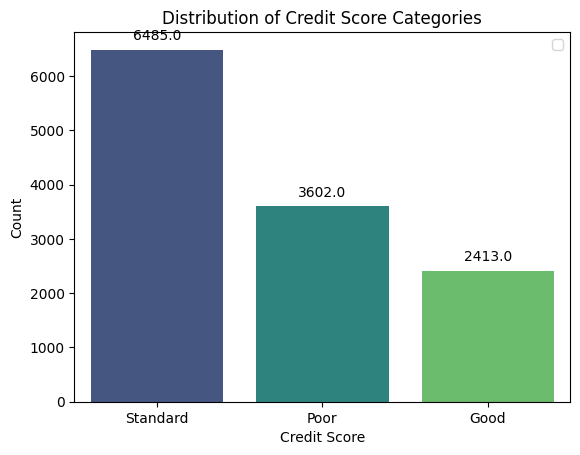

In [ ]:
fig = sns.countplot(
    x='Credit_Score',data=credit_score_df_unique,
    order=credit_score_df_unique['Credit_Score'].value_counts().index,
    saturation=0.75,
    palette='viridis'
)

#Add figure points in graph to validate the credit score category distribution
for p in fig.patches:
    fig.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.xlabel('Credit Score')
plt.ylabel('Count')
plt.title('Distribution of Credit Score Categories')
plt.legend()
plt.show()

Create a boxplot showing the variation of Credit_Utilization_Ratio across Credit_Score categories.

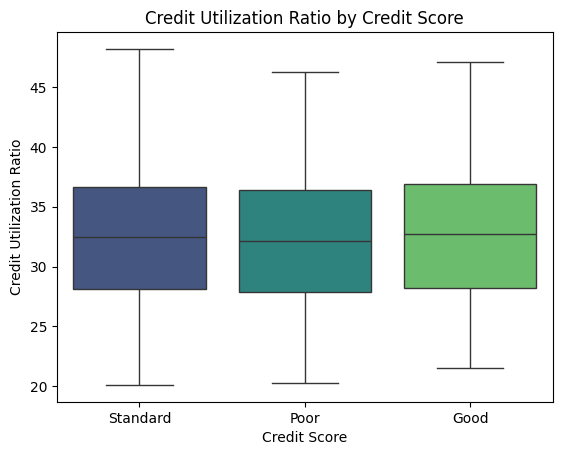

In [ ]:
#plot the box plot see where credit utlization ratio affect the credit score categories
#how average credit utlization ratio affect the customers crdit score
sns.boxplot(x='Credit_Score',y='Credit_Utilization_Ratio',data=credit_score_df_unique,
                    order=credit_score_df_unique['Credit_Score'].value_counts().index,
                    palette='viridis')
plt.xlabel('Credit Score')
plt.ylabel('Credit Utilization Ratio')
plt.title('Credit Utilization Ratio by Credit Score')
plt.show()

he box plot shows the distribution of the Credit_Utilization_Ratio for each Credit_Score category. It appears that as the credit score improves (moves from Poor to Good), the median credit utilization ratio tends to decrease, and the overall spread of the data also seems to narrow. This suggests a relationship where lower credit utilization is associated with better credit scores.

Payment_of_Min_Amount        NM        No       Yes
Credit_Score                                       
Good                   0.130128  0.681310  0.188562
Poor                   0.116602  0.175736  0.707662
Standard               0.108558  0.341403  0.550039
All                    0.115040  0.359280  0.525680


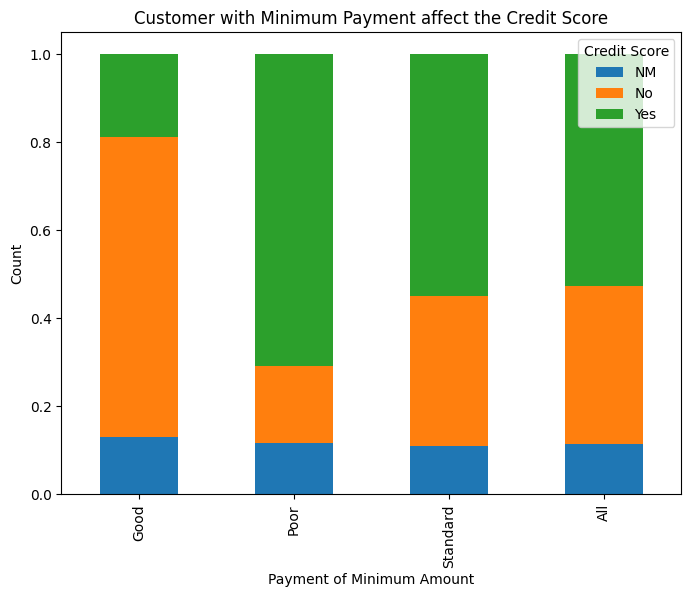

In [ ]:
#Minimm payemnt affect the credit worthiness of customers
crosstab_result = pd.crosstab(credit_score_df_unique['Credit_Score'],
                              credit_score_df_unique['Payment_of_Min_Amount'],
                              margins=True,
                              normalize='index')
print(crosstab_result)
#plot the stacked bar chart to see how minimum payamne affect the credit score
crosstab_result.plot(kind='bar', stacked=True, figsize=(8, 6))
plt.xlabel('Payment of Minimum Amount')
plt.ylabel('Count')
plt.title('Customer with Minimum Payment affect the Credit Score')
plt.legend(title='Credit Score')
plt.show()

* Key Insights
* customers Who does not pay Minmum amount indicate unser Good Credit score Category this indicate Reliable Credit users with extra amount and timely payment

* Strong signal that minimum-only payments correlate with high credit risk.
These customers may be struggling with cash flow, leading to higher utilization and lower repayment capacity.

* ‘Standard’ scorers (55%) also pay only the minimum.
→ Suggests a transitional group — they manage to stay current but are at risk of slipping into ‘Poor’ if they continue minimum payments or increase debt.

* NM (Not Mentioned) customers form a small, neutral segment (≈11%), not heavily influencing risk direction.

In [ ]:
#Averge monthly ihand salary  overall across credit score
average_monthly_salary = credit_score_df_unique.groupby('Credit_Score')['Monthly_Inhand_Salary'].mean()
print(average_monthly_salary)

fig = go.Figure(
    data=go.Scatter(x=average_monthly_salary.index, y=average_monthly_salary.values, mode='lines+markers'))

#adding figure layout
fig.update_layout(
    title="Average Monthly Inhand Salary by Credit Score",
    xaxis_title="Credit Score",
    yaxis_title="Average Monthly Inhand Salary",
    annotations=[
        dict(
            x='Poor',
            y=average_monthly_salary['Poor'],
            text=f"Average Monthly Inhand salary : {average_monthly_salary['Poor']:.2f}",
            showarrow=True,
            arrowhead=1,
        ),
        dict(
            x='Standard',
            y=average_monthly_salary['Standard'],
            text=f"Average Monthly Inhand salary : {average_monthly_salary['Standard']:.2f}",
            showarrow=True,
            arrowhead=1,
        ),
        dict(
            x='Good',
            y=average_monthly_salary['Good'],
            text=f"Average Monthly Inhand salary: {average_monthly_salary['Good']:.2f}",
            showarrow=True,
            arrowhead=1,
        ),
    ],
    showlegend=False,
)


fig.show()

Credit_Score
Good        3639.685744
Poor        3810.120692
Standard    3747.872012
Name: Monthly_Inhand_Salary, dtype: float64


* Key Insights

If a customer’s credit limit increases but they immediately utilize a high proportion, it signals potential credit risk, even if the limit itself is high.
Conversely, customers with stable limits and low utilization demonstrate financial discipline and are low-risk.”

In [ ]:
changes_credit_limit = credit_score_df_unique['Changed_Credit_Limit'].diff()  #check difference in credit limit
credit_score_df_unique['Utilization_Change'] = credit_score_df_unique['Credit_Utilization_Ratio'].diff()  #check difference in utlizzation ratio

# Flag risky behavior: limit increase + utilization increase
credit_score_df_unique['High_Risk_Limit_Util'] = ((credit_score_df_unique['Changed_Credit_Limit'] > 0) &
                                                  (credit_score_df_unique['Utilization_Change'] > 0)).astype(int)
fig = px.scatter(
    credit_score_df_unique,
    x='Changed_Credit_Limit',
    y='Utilization_Change',
    color='High_Risk_Limit_Util',
    color_discrete_map={0: 'green', 1: 'red'},
)

fig.update_layout(
    title="Credit Limit Changes vs. Utilization Changes",
    xaxis_title="Changed Credit Limit",
    yaxis_title="Utilization Change",
)
fig.show()

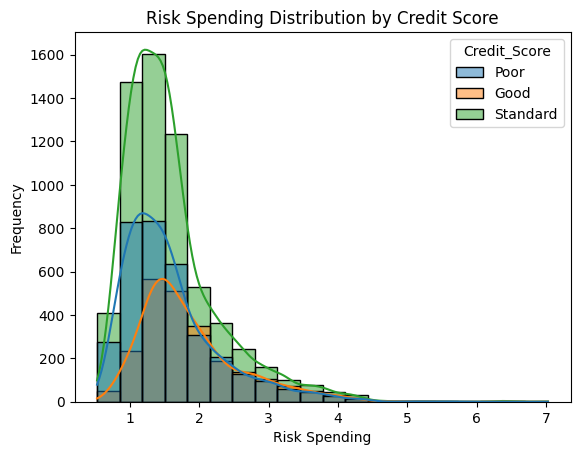

In [ ]:
#create an risk spending feature for financial behavioural pattern
credit_score_df_unique['Risk_Spending'] = credit_score_df_unique['Credit_Utilization_Ratio'] / credit_score_df_unique['Changed_Credit_Limit']
credit_score_df_unique['Risk_Spending']

#apply log transformation rather than scakling
credit_score_df_unique['Risk_Spending'] = np.log1p(credit_score_df_unique['Risk_Spending'])

#create an histogram plot for visualization for risk soedning feature over the Credit score
sns.histplot(data=credit_score_df_unique, x='Risk_Spending', hue='Credit_Score', kde=True, bins=20)
plt.xlabel('Risk Spending')
plt.ylabel('Frequency')
plt.title('Risk Spending Distribution by Credit Score')
plt.show()

In [ ]:
#fill with mean value for NaN values in Utilization_Change column
credit_score_df_unique['Utilization_Change'].fillna(credit_score_df_unique['Utilization_Change'].mean(), inplace=True)

credit_score_df_unique['Utilization_Change']

0         0.000787
1         5.328078
2         3.673075
3        -4.962189
4         1.738453
           ...    
12495    -1.575882
12496     0.178265
12497     2.224688
12498    -5.689527
12499    10.039198
Name: Utilization_Change, Length: 12500, dtype: float64

In [ ]:
#how maximum number of deplayed payments affect the customers to catgeorize as credit score over outstanfing debt
#average outstanding debt over nuber of deplayed payments

credit_score_df_unique['Num_of_Delayed_Payment'] = pd.to_numeric(credit_score_df_unique['Num_of_Delayed_Payment'], errors='coerce')

#cleanup the negative values
credit_score_df_unique['Num_of_Delayed_Payment'] = credit_score_df_unique['Num_of_Delayed_Payment'].apply(
    lambda x:0 if x < 0 else x
)

credit_score_df_unique['Num_of_Delayed_Payment'] = credit_score_df_unique['Num_of_Delayed_Payment'].loc[
    (credit_score_df_unique['Num_of_Delayed_Payment'] >=0) &
    (credit_score_df_unique['Num_of_Delayed_Payment'] <= 100)
]
print(credit_score_df_unique['Num_of_Delayed_Payment'].min())
print(credit_score_df_unique['Num_of_Delayed_Payment'].max())

0.0
88.0


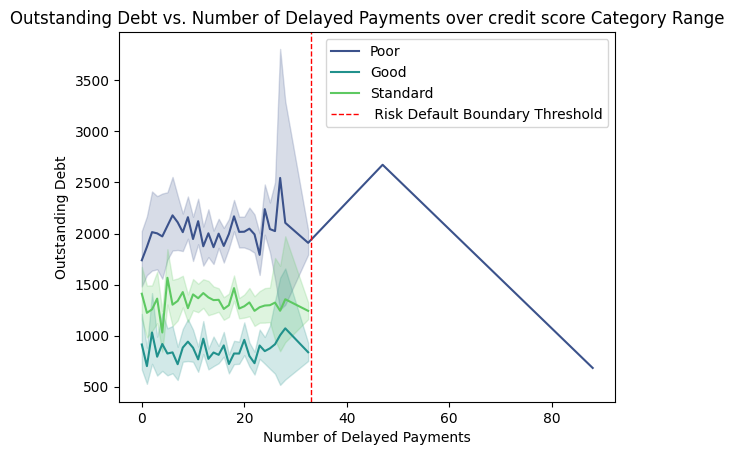

In [ ]:
#plot the line graph over number of delayeed payaments
ax = sns.lineplot(
    data=credit_score_df_unique, x='Num_of_Delayed_Payment', y='Outstanding_Debt', hue='Credit_Score',
    palette='viridis'
)

#initialize the Risk default boundare based on Outstanding Debt ovr number of deplaye payments
plt.axvline(x=33, color='red', linestyle='--', linewidth=1,label=' Risk Default Boundary Threshold')
ax.set_xlabel('Number of Delayed Payments')
ax.set_ylabel('Outstanding Debt')
ax.set_title('Outstanding Debt vs. Number of Delayed Payments over credit score Category Range')
plt.legend()
plt.show()

When the number of delayed payments exceeds approximately 35, the customer’s financial credibility sharply declines.
The model detects this as a transition point where outstanding debt rises significantly, indicating financial stress and poor creditworthiness. it creats financial stress over customers

In [ ]:
#create an feature for financial stress index
def create_financial_stress_index(df):
  logging.info("Initializing the features for financial stress calculations")
  try:
    df['Outstanding_Debt'] = pd.to_numeric(df['Outstanding_Debt'], errors='coerce')
    #defining the formuala for calculate the financial stress
    df['Financial_Stress_Index'] = (
        (df['Outstanding_Debt'] +
         df['Num_of_Delayed_Payment'] +
         df['Credit_Utilization_Ratio']) /
        (df['Monthly_Inhand_Salary'] + 1e-6)  # Avoid divide by zero
    )
    logging.info("Financial Stress Index successfully created")
    return df
  except Exception as e:
    logging.error(e)

credit_score_df_unique = create_financial_stress_index(credit_score_df_unique)
credit_score_df_unique


Customer_ID       ID   Month            Name   Age          SSN  \
0      CUS_0x1000  0x16291  August  Alistair Barrf  18.0  913741218.0   
1      CUS_0x8cbe  0x12079  August  Giorgio Stevew  39.0  236250124.0   
2      CUS_0x8cc1  0x1ef79  August       Kazunorii  43.0  331243360.0   
3      CUS_0x8cc5   0xaa59  August  Stanley Whitep  37.0  311387874.0   
4      CUS_0x8cc8  0x17f71  August          Douwes  43.0  646259153.0   
...           ...      ...     ...             ...   ...          ...   
12495  CUS_0x4f3e   0xe659  August       Beckfordz  47.0  341945301.0   
12496  CUS_0x4f41  0x106f9  August        Miedemaf  38.0  702760398.0   
12497  CUS_0x4f43  0x215e9  August  Silvia Aloisir  34.0  282991365.0   
12498  CUS_0x4f05  0x11449  August       Ian Chuav  18.0   89631676.0   
12499   CUS_0xffd  0x25b01  August        Damouniq  30.0  832888320.0   

       Occupation  Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  \
0          Lawyer       30625.94            4073.717500                  6   
1         Manager       76644.16            1707.282500                  5   
2      Accountant       31700.12             578.274583                  5   
3       Architect       77821.26             671.190000                  1   
4         Manager      124564.60            2524.070833                  3   
...           ...            ...                    ...                ...   
12495      Lawyer       17766.93            3682.467328                  5   
12496    Mechanic       16398.56            1663.914167                 10   
12497      Doctor        7908.00            1046.116667                  8   
12498    Musician       33390.92            2782.020000                  7   
12499   Scientist       41398.44            2398.106667                  8   

       ...  Monthly_Balance  Credit_Score  Spending Level Payment Value  \
0      ...       208.521084          Poor            High        Medium   
1      ...       321.592812          Good             Low         Small   
2      ...       268.966989          Poor             Low         Large   
3      ...       286.149881      Standard            High         Small   
4      ...       384.039762      Standard            High         Large   
...    ...              ...           ...             ...           ...   
12495  ...       373.808443      Standard             Low         Small   
12496  ...       325.345996          Poor            High        Medium   
12497  ...       251.565611          Poor             Low         Small   
12498  ...       338.596373          Poor            High        Medium   
12499  ...       286.061115          Good            High         Large   

       Credit_History_Year  Credit_History_Month  Utilization_Change  \
0                       13                    3             0.000787   
1                       22                    6             5.328078   
2                        3                   11             3.673075   
3                        7                    6            -4.962189   
4                       19                    8             1.738453   
...                    ...                   ...                 ...   
12495                   12                    9            -1.575882   
12496                   12                   11             0.178265   
12497                    1                    6             2.224688   
12498                    7                   11            -5.689527   
12499                    7                    8            10.039198   

       High_Risk_Limit_Util Risk_Spending  Financial_Stress_Index  
0                         0      2.967963                0.395459  
1                         1      3.971547                0.868184  
2                         1      1.514276                2.352876  
3                         0      1.962066                1.336203  
4                         1      1.406818                0.353819  
...               

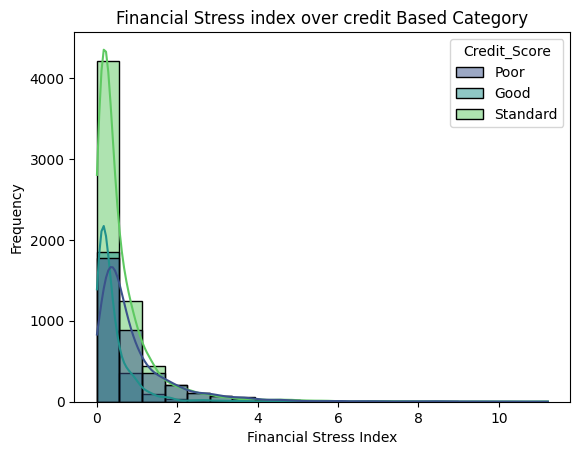

In [ ]:
#plot the financial stress index over credit score
fig = sns.histplot(
    data=credit_score_df_unique,
    x='Financial_Stress_Index',
    hue='Credit_Score',
    kde=True,
    bins=20,
    palette='viridis'
)
plt.xlabel('Financial Stress Index')
plt.ylabel('Frequency')
plt.title("Financial Stress index over credit Based Category")
plt.show()


# Relationship Analysis

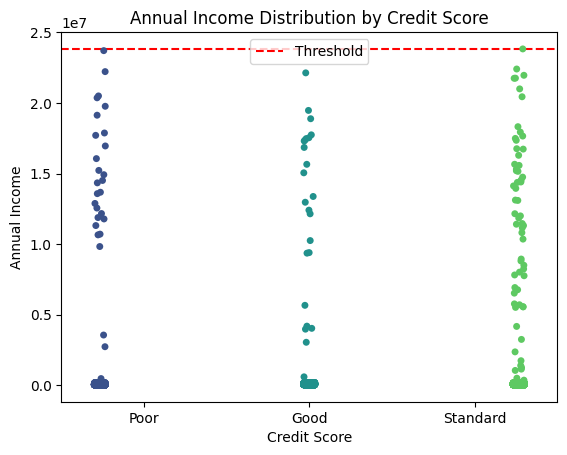

'There is no Significant Impact of Annual Income on Credit Score'

In [ ]:
#significant impact of annual income over credit score category with T-test testing  scatter diagram

#convert the Annual Income column into fixed numeric format
credit_score_df_unique['Annual_Income'] = pd.to_numeric(credit_score_df_unique['Annual_Income'], errors='coerce')

#plot the distribution of Annual Income over the credit score through strip plot distribution
sns.stripplot(
    data=credit_score_df_unique,
    x='Credit_Score',
    y='Annual_Income',
    hue='Credit_Score',
    palette='viridis',
    jitter=True,
    dodge=True
)

plt.axhline(y=credit_score_df_unique['Annual_Income'].max(), color='red', linestyle='--', label='Threshold')
plt.xlabel('Credit Score')
plt.ylabel('Annual Income')
plt.title('Annual Income Distribution by Credit Score')
plt.legend()  #add legend over the distrivbution
plt.show()

#compare the difference of each credit score catgeory over annual income
from scipy import stats
from scipy.stats import f_oneway

#extract the each annual income for each category
poor_annual_income = credit_score_df_unique['Annual_Income'].loc[
    credit_score_df_unique['Credit_Score'] == 'Poor']
standard_annual_income = credit_score_df_unique['Annual_Income'].loc[
    credit_score_df_unique['Credit_Score'] == 'Standard']
Good_annual_income = credit_score_df_unique['Annual_Income'].loc[
    credit_score_df_unique['Credit_Score'] == 'Good']

#create function for test one way test
def test_statistical_significance(poor_income_category,standard_income_category,good_income_category):
  """ Create an Exception Handling """
  logging.info("Setup the Test for Statistical Significance over behaviour")
  try:
    #calculate the f_stats and p_value over the features
    f_stats , p_value = f_oneway(poor_income_category,standard_income_category,good_income_category)

    """ Create inner exception for p_value with its threhold value """
    try:
      if p_value < 0.05:
        return f" Stats Value {f_stats} and P value {p_value}"
        return "There is Significant Impact of Annual Income on Credit Score"
      else:
        return "There is no Significant Impact of Annual Income on Credit Score"
    except Exception as e:
      logging.error(f" Unexpected Error {e} Occured Between inner Function process")
  except Exception as e:
    logging.error(f" Unexpected Error {e} Occured Between Outer Function Process")

#call the above test function
test_statistical_significance(poor_annual_income,standard_annual_income,Good_annual_income)


The ANOVA test shows p-value = 0.23 (>0.05), suggesting no significant difference in Annual Income across Credit Score categories. Hence, Annual Income alone may not influence the credit score classification.”

  Annual income column is Highly skewed


Text(0.5, 1.0, 'Skewness distribution over the Anuual Income')

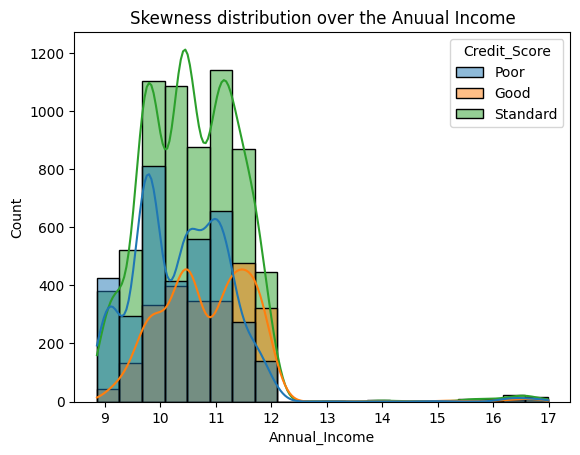

In [ ]:
#convert the Annual income column into numeric type
credit_score_df_unique['Annual_Income'] = pd.to_numeric(credit_score_df_unique['Annual_Income'], errors='coerce')
credit_score_df_unique['Annual_Income']


#check for skewness in the Income column
skewness = credit_score_df_unique['Annual_Income'].skew()
try:
  if skewness > 1:
    print(f"  Annual income column is Highly skewed")
  else:
    print(f" Annual income column is not Highly skewed")
except Exception as e:
  print(e)
#conver into log transformation
credit_score_df_unique['Annual_Income'] = np.log1p(credit_score_df_unique['Annual_Income'])

#plot the histogram plot after skewness conversion over the credit score category
sns.histplot(data=credit_score_df_unique,x='Annual_Income',hue='Credit_Score',kde=True,bins=20)
plt.title('Skewness distribution over the Anuual Income')



In [ ]:
#does the Interest_Rate vary across different Credit_Score ranges?
#create an function to test different interest rate catgeory significance over the distribution
from scipy.stats import kruskal

poor_interest_rate = credit_score_df_unique['Interest_Rate'].loc[
    credit_score_df_unique['Credit_Score'] == 'Poor']
standard_interest_rate = credit_score_df_unique['Interest_Rate'].loc[
    credit_score_df_unique['Credit_Score'] == 'Standard']
Good_interest_rate = credit_score_df_unique['Interest_Rate'].loc[
    credit_score_df_unique['Credit_Score'] == 'Good']

#utilizing the previous function
def test_statistical_significance_over_interest_rate (poor_income_category,standard_income_category,good_income_category):
  """ Create an Exception Handling """
  logging.info("Setup the Test for Statistical Significance over behaviour")
  try:
    #calculate the f_stats and p_value over the features
    f_stats , p_value = kruskal(poor_income_category,standard_income_category,good_income_category)

    """ Create inner exception for p_value with its threhold value """
    try:
      if p_value < 0.05:
        return "There is Significant Impact of Interest Rate  on Credit Score"
      else:
        return "There is no Significant Impact of Interest Rate  on Credit Score"
    except Exception as e:
      logging.error(f" Unexpected Error {e} Occured Between inner Function process")
  except Exception as e:
    logging.error(f" Unexpected Error {e} Occured Between Outer Function Process")

#call the above test function
test_result = test_statistical_significance_over_interest_rate(poor_interest_rate,standard_interest_rate,Good_interest_rate)
print(f" Statistical Signifcance Test : {test_result}")

 Statistical Signifcance Test : There is Significant Impact of Interest Rate  on Credit Score


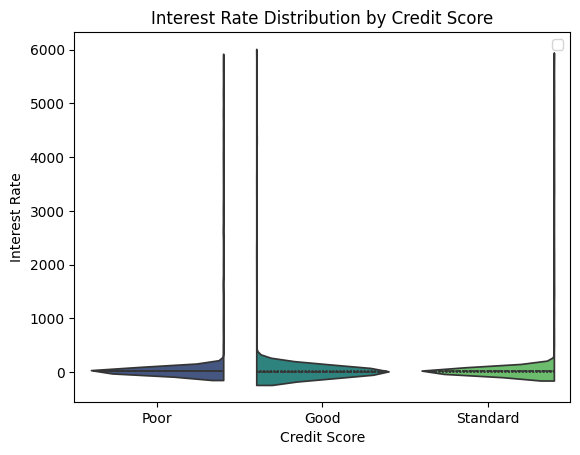

In [ ]:
#plot the violion graph over te intrest rate on credit score
fig = sns.violinplot(
    data=credit_score_df_unique,
    x='Credit_Score',
    y='Interest_Rate',
    hue='Credit_Score',
    palette='viridis',
    split=True,
    inner='quartile'
)
plt.xlabel('Credit Score')
plt.ylabel('Interest Rate')
plt.title('Interest Rate Distribution by Credit Score')
plt.legend()
plt.show()


Borrowers with better credit scores consistently receive lower and more stable interest rates.
Poor credit scores lead to higher, more variable rates — a sign of risk-adjusted lending.

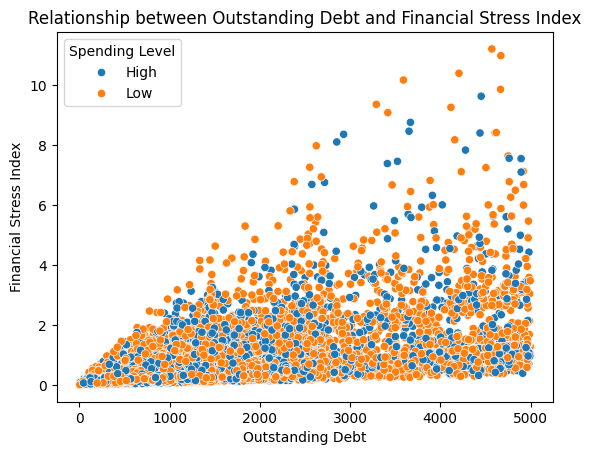

'There is no Significant Impact of Spending Level on Financial Stress Index'

In [ ]:
#how spending level increase over the outnaing debt and odes it increas ethe financial stress
from scipy import stats
sns.scatterplot(x='Outstanding_Debt', y='Financial_Stress_Index', hue='Spending Level', data=credit_score_df_unique)
plt.xlabel('Outstanding Debt')
plt.ylabel('Financial Stress Index')
plt.title('Relationship between Outstanding Debt and Financial Stress Index')
plt.show()

#create an two tail test to check whether the relationship is significant or not on spsending level creates an financial stress
high_spending_customers = credit_score_df_unique['Financial_Stress_Index'].loc[
    credit_score_df_unique['Spending Level'] == 'High']
low_spending_customers = credit_score_df_unique['Financial_Stress_Index'].loc[
    credit_score_df_unique['Spending Level'] == 'Low']

def create_two_tail_test(high_spending_customers,low_spending_customers):
  logging.info("Setup Testing Function for Two sample test")
  try:
    t_stats , p_value = stats.ttest_ind(high_spending_customers,low_spending_customers) #Two tail test
    try:
      if p_value < 0.05:
        return "There is Significant Impact of Spending Level on Financial Stress Index"
      else:
        return "There is no Significant Impact of Spending Level on Financial Stress Index"
    except Exception as e:
      logging.error("unexpected Error occured into inner function")
  except Exception as e:
    logging.error("unexpected Error occured into outer function")

create_two_tail_test(high_spending_customers,low_spending_customers)


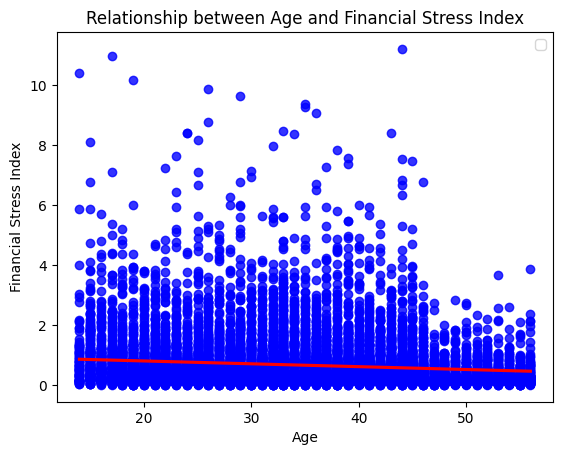

In [ ]:
#plot the regression plot over the financial stress with age wiht spending level
sns.regplot(x='Age', y='Financial_Stress_Index', data=credit_score_df_unique,
            scatter_kws={'color': 'blue'}, line_kws={'color': 'red'}, ci=None)
plt.xlabel('Age')
plt.ylabel('Financial Stress Index')
plt.title('Relationship between Age and Financial Stress Index')
plt.legend()
plt.show()

# Outliers Detection From extreme Points

In [ ]:
#check the skewness of each column for quantile regions distribution
#store all numeric columns
skewness_data = []
for column in credit_score_df_unique.columns:
  if pd.api.types.is_numeric_dtype(credit_score_df_unique[column]):

   #create an dataframe based on skewness value and other
   skewness = credit_score_df_unique[column].skew()
   skewness_data.append({'Column': column, 'Skewness': skewness})

skewness_df = pd.DataFrame(skewness_data)

#validate the skewness is highly skewedd or not
skewness_df['Skewness_result'] = skewness_df['Skewness'].apply(
    lambda x: 'Normal Skewed' if abs(x) < 0.5
    else ('Mild Skewed' if abs(x) < 1 else 'Highly Skewed')
)

skewness_df


Column   Skewness Skewness_result
0                        Age   0.159111   Normal Skewed
1              Annual_Income   1.725570   Highly Skewed
2      Monthly_Inhand_Salary   1.368632   Highly Skewed
3          Num_Bank_Accounts  11.107256   Highly Skewed
4            Num_Credit_Card   8.309464   Highly Skewed
5              Interest_Rate   9.012671   Highly Skewed
6                Num_of_Loan  15.764789   Highly Skewed
7        Delay_from_due_date   0.966667     Mild Skewed
8     Num_of_Delayed_Payment   0.268535   Normal Skewed
9       Changed_Credit_Limit   0.629488     Mild Skewed
10      Num_Credit_Inquiries   9.778533   Highly Skewed
11          Outstanding_Debt   1.206123   Highly Skewed
12  Credit_Utilization_Ratio   0.004566   Normal Skewed
13       Total_EMI_per_month   6.928911   Highly Skewed
14   Amount_invested_monthly   2.814556   Highly Skewed
15           Monthly_Balance   1.874612   Highly Skewed
16        Utilization_Change   0.005986   Normal Skewed
17      High_Risk_Limit_Util   0.071093   Normal Skewed
18             Risk_Spending   1.489805   Highly Skewed
19    Financial_Stress_Index   3.779807   Highly Skewed

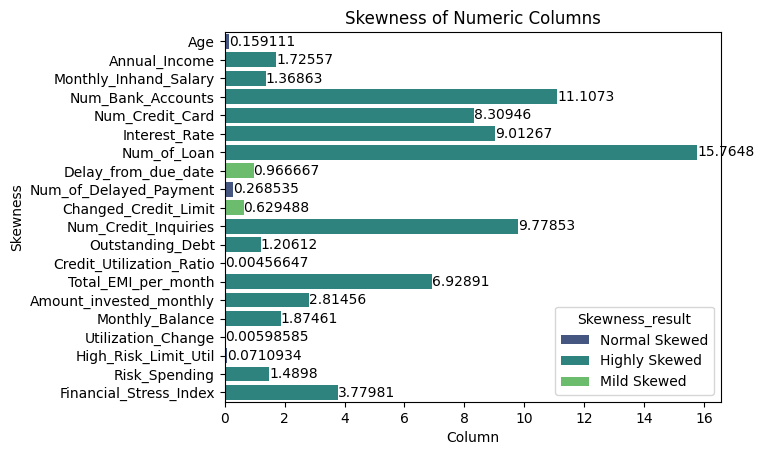

In [ ]:
#plot hte visulization for baove table
fig = sns.barplot(x='Skewness', y='Column', hue='Skewness_result', data=skewness_df,
                    palette='viridis')

#add the skewness score in graph
for bars in fig.containers:
  fig.bar_label(bars)  #add labels in bars

plt.xlabel('Column')
plt.ylabel('Skewness')
plt.title('Skewness of Numeric Columns')
plt.gca().get_xlim()
plt.show()


In [ ]:
credit_score_df_unique['Outstanding_Debt'].skew()

np.float64(1.206122702608833)

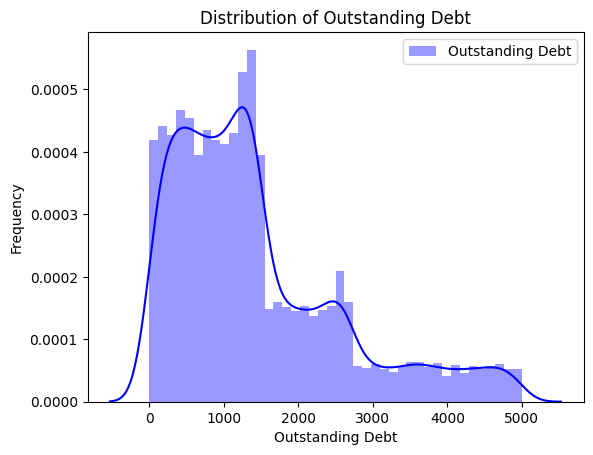

In [ ]:
#visualize one of the higly skewed variable
sns.distplot(credit_score_df_unique['Outstanding_Debt'], kde=True, hist=True, color='blue',
                    label='Outstanding Debt')
plt.xlabel('Outstanding Debt')
plt.ylabel('Frequency')
plt.title('Distribution of Outstanding Debt')
plt.legend()
plt.show()

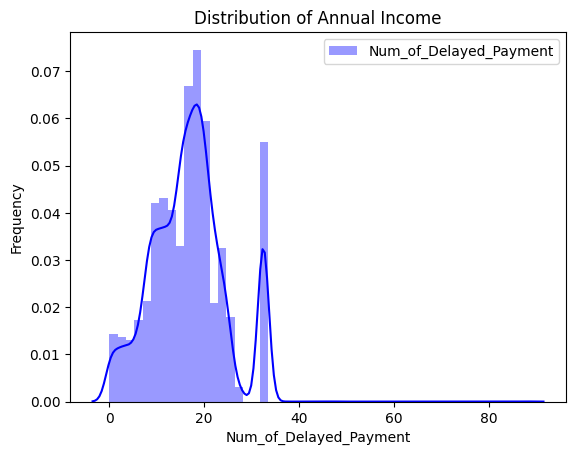

In [ ]:
#visualize the not highly skewed variable
sns.distplot(credit_score_df_unique['Num_of_Delayed_Payment'], kde=True, hist=True,
                    color='blue', label='Num_of_Delayed_Payment')
plt.xlabel('Num_of_Delayed_Payment')
plt.ylabel('Frequency')
plt.title('Distribution of Annual Income')
plt.legend()

In [ ]:
#apply the transformation over the higly skewed variaable to make and normal distribution
highly_skewed_columns = []
columns = skewness_df.loc[skewness_df['Skewness_result'] == 'Highly Skewed', 'Column']
for col in columns:
  highly_skewed_columns.append(col)

highly_skewed_columns

['Annual_Income',
 'Monthly_Inhand_Salary',
 'Num_Bank_Accounts',
 'Num_Credit_Card',
 'Interest_Rate',
 'Num_of_Loan',
 'Num_Credit_Inquiries',
 'Outstanding_Debt',
 'Total_EMI_per_month',
 'Amount_invested_monthly',
 'Monthly_Balance',
 'Risk_Spending',
 'Financial_Stress_Index']

In [ ]:
import numpy as np
from scipy.stats import boxcox

# List of columns to apply Box-Cox transformation
boxcox_cols = [
    'Annual_Income','Monthly_Inhand_Salary','Outstanding_Debt',
    'Total_EMI_per_month','Amount_invested_monthly',
    'Monthly_Balance','Financial_Stress_Index'
]

for col in boxcox_cols:
    # 1. Convert to numeric, coercing errors to NaN
    credit_score_df_unique[col] = pd.to_numeric(credit_score_df_unique[col], errors='coerce')

    # 2. Fill any NaN values with the median of the column
    median_val = credit_score_df_unique[col].median()
    credit_score_df_unique[col].fillna(median_val, inplace=True)

    # 3. Check if the minimum value is less than or equal to zero and shift if necessary
    min_val = credit_score_df_unique[col].min()
    if min_val <= 0:
        credit_score_df_unique[col] = credit_score_df_unique[col] + abs(min_val) + 1

    # 4. Apply Box-Cox transformation
    # The boxcox function returns the transformed data and the lambda parameter
    transformed_data, _ = boxcox(credit_score_df_unique[col])
    credit_score_df_unique[col] = transformed_data

print("Box-Cox transformation applied to specified columns.")
credit_score_df_unique

Box-Cox transformation applied to specified columns.


Customer_ID       ID   Month            Name   Age          SSN  \
0      CUS_0x1000  0x16291  August  Alistair Barrf  18.0  913741218.0   
1      CUS_0x8cbe  0x12079  August  Giorgio Stevew  39.0  236250124.0   
2      CUS_0x8cc1  0x1ef79  August       Kazunorii  43.0  331243360.0   
3      CUS_0x8cc5   0xaa59  August  Stanley Whitep  37.0  311387874.0   
4      CUS_0x8cc8  0x17f71  August          Douwes  43.0  646259153.0   
...           ...      ...     ...             ...   ...          ...   
12495  CUS_0x4f3e   0xe659  August       Beckfordz  47.0  341945301.0   
12496  CUS_0x4f41  0x106f9  August        Miedemaf  38.0  702760398.0   
12497  CUS_0x4f43  0x215e9  August  Silvia Aloisir  34.0  282991365.0   
12498  CUS_0x4f05  0x11449  August       Ian Chuav  18.0   89631676.0   
12499   CUS_0xffd  0x25b01  August        Damouniq  30.0  832888320.0   

       Occupation  Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  \
0          Lawyer       0.512677              17.272296                  6   
1         Manager       0.513545              14.232599                  5   
2      Accountant       0.512714              10.990376                  5   
3       Architect       0.513558              11.404240                  1   
4         Manager       0.513926              15.547371                  3   
...           ...            ...                    ...                ...   
12495      Lawyer       0.512045              16.897453                  5   
12496    Mechanic       0.511944              14.148901                 10   
12497      Doctor       0.510892              12.696508                  8   
12498    Musician       0.512768              15.887471                  7   
12499   Scientist       0.512986              15.370537                  8   

       ...  Monthly_Balance  Credit_Score  Spending Level Payment Value  \
0      ...        14.146059          Poor            High        Medium   
1      ...        16.716437          Good             Low         Small   
2      ...        15.612879          Poor             Low         Large   
3      ...        15.988183      Standard            High         Small   
4      ...        17.876674      Standard            High         Large   
...    ...              ...           ...             ...           ...   
12495  ...        17.695848      Standard             Low         Small   
12496  ...        16.790300          Poor            High        Medium   
12497  ...        15.215803          Poor             Low         Small   
12498  ...        17.046527          Poor            High        Medium   
12499  ...        15.986284          Good            High         Large   

       Credit_History_Year  Credit_History_Month  Utilization_Change  \
0                       13                    3             0.000787   
1                       22                    6             5.328078   
2                        3                   11             3.673075   
3                        7                    6            -4.962189   
4                       19                    8             1.738453   
...                    ...                   ...                 ...   
12495                   12                    9            -1.575882   
12496                   12                   11             0.178265   
12497                    1                    6             2.224688   
12498                    7                   11            -5.689527   
12499                    7                    8            10.039198   

       High_Risk_Limit_Util Risk_Spending  Financial_Stress_Index  
0                         0      2.967963               -0.892070  
1                         1      3.971547               -0.140506  
2                         1      1.514276                0.887526  
3                         0      1.962066                0.293432  
4                         1      1.406818               -0.994408  
...               

In [ ]:
import numpy as np
import pandas as pd

# Columns already transformed by Box-Cox
boxcox_transformed_cols = [
    'Annual_Income', 'Monthly_Inhand_Salary', 'Outstanding_Debt',
    'Total_EMI_per_month', 'Amount_invested_monthly',
    'Monthly_Balance', 'Financial_Stress_Index'
]

# Identify columns previously identified as highly skewed but not yet Box-Cox transformed
# (The 'highly_skewed_columns' list was defined in a previous cell, so I'll recreate it based on the `skewness_df` output)
highly_skewed_cols_from_df = skewness_df.loc[skewness_df['Skewness_result'] == 'Highly Skewed', 'Column'].tolist()

log1p_target_cols = [col for col in highly_skewed_cols_from_df if col not in boxcox_transformed_cols]

print(f"Columns targeted for log1p transformation: {log1p_target_cols}")

for col in log1p_target_cols:
    # 1. Ensure the column is numeric, coercing errors to NaN
    credit_score_df_unique[col] = pd.to_numeric(credit_score_df_unique[col], errors='coerce')

    # 2. Fill any NaN values with the median of the column
    median_val = credit_score_df_unique[col].median()
    credit_score_df_unique[col].fillna(median_val, inplace=True)

    # 3. Check if the minimum value is less than or equal to zero and shift if necessary
    min_val = credit_score_df_unique[col].min()
    if min_val <= 0:
        # Shift by adding the absolute minimum value plus a small constant to ensure all values are > 0
        credit_score_df_unique[col] = credit_score_df_unique[col] + abs(min_val) + 1

    # 4. Apply log1p transformation
    credit_score_df_unique[col] = np.log1p(credit_score_df_unique[col])
    print(f"Successfully applied log1p to {col}.")

print("Log1p transformations applied to specified columns.")
credit_score_df_unique.head()

Columns targeted for log1p transformation: ['Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Num_Credit_Inquiries', 'Risk_Spending']
Successfully applied log1p to Num_Bank_Accounts.
Successfully applied log1p to Num_Credit_Card.
Successfully applied log1p to Interest_Rate.
Successfully applied log1p to Num_of_Loan.
Successfully applied log1p to Num_Credit_Inquiries.
Successfully applied log1p to Risk_Spending.
Log1p transformations applied to specified columns.


Customer_ID       ID   Month            Name   Age          SSN  Occupation  \
0  CUS_0x1000  0x16291  August  Alistair Barrf  18.0  913741218.0      Lawyer   
1  CUS_0x8cbe  0x12079  August  Giorgio Stevew  39.0  236250124.0     Manager   
2  CUS_0x8cc1  0x1ef79  August       Kazunorii  43.0  331243360.0  Accountant   
3  CUS_0x8cc5   0xaa59  August  Stanley Whitep  37.0  311387874.0   Architect   
4  CUS_0x8cc8  0x17f71  August          Douwes  43.0  646259153.0     Manager   

   Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  ...  \
0       0.512677              17.272296           2.197225  ...   
1       0.513545              14.232599           2.079442  ...   
2       0.512714              10.990376           2.079442  ...   
3       0.513558              11.404240           1.386294  ...   
4       0.513926              15.547371           1.791759  ...   

   Monthly_Balance  Credit_Score  Spending Level Payment Value  \
0        14.146059          Poor            High        Medium   
1        16.716437          Good             Low         Small   
2        15.612879          Poor             Low         Large   
3        15.988183      Standard            High         Small   
4        17.876674      Standard            High         Large   

   Credit_History_Year  Credit_History_Month  Utilization_Change  \
0                   13                    3             0.000787   
1                   22                    6             5.328078   
2                    3                   11             3.673075   
3                    7                    6            -4.962189   
4                   19                    8             1.738453   

   High_Risk_Limit_Util Risk_Spending  Financial_Stress_Index  
0                     0      1.378253               -0.892070  
1                     1      1.603731               -0.140506  
2                     1      0.921985                0.887526  
3                     0      1.085887                0.293432  
4                     1      0.878305               -0.994408  

[5 rows x 34 columns]

In [ ]:
credit_score_df_unique

Customer_ID       ID   Month            Name   Age          SSN  \
0      CUS_0x1000  0x16291  August  Alistair Barrf  18.0  913741218.0   
1      CUS_0x8cbe  0x12079  August  Giorgio Stevew  39.0  236250124.0   
2      CUS_0x8cc1  0x1ef79  August       Kazunorii  43.0  331243360.0   
3      CUS_0x8cc5   0xaa59  August  Stanley Whitep  37.0  311387874.0   
4      CUS_0x8cc8  0x17f71  August          Douwes  43.0  646259153.0   
...           ...      ...     ...             ...   ...          ...   
12495  CUS_0x4f3e   0xe659  August       Beckfordz  47.0  341945301.0   
12496  CUS_0x4f41  0x106f9  August        Miedemaf  38.0  702760398.0   
12497  CUS_0x4f43  0x215e9  August  Silvia Aloisir  34.0  282991365.0   
12498  CUS_0x4f05  0x11449  August       Ian Chuav  18.0   89631676.0   
12499   CUS_0xffd  0x25b01  August        Damouniq  30.0  832888320.0   

       Occupation  Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  \
0          Lawyer       0.512677              17.272296           2.197225   
1         Manager       0.513545              14.232599           2.079442   
2      Accountant       0.512714              10.990376           2.079442   
3       Architect       0.513558              11.404240           1.386294   
4         Manager       0.513926              15.547371           1.791759   
...           ...            ...                    ...                ...   
12495      Lawyer       0.512045              16.897453           2.079442   
12496    Mechanic       0.511944              14.148901           2.564949   
12497      Doctor       0.510892              12.696508           2.397895   
12498    Musician       0.512768              15.887471           2.302585   
12499   Scientist       0.512986              15.370537           2.397895   

       ...  Monthly_Balance  Credit_Score  Spending Level Payment Value  \
0      ...        14.146059          Poor            High        Medium   
1      ...        16.716437          Good             Low         Small   
2      ...        15.612879          Poor             Low         Large   
3      ...        15.988183      Standard            High         Small   
4      ...        17.876674      Standard            High         Large   
...    ...              ...           ...             ...           ...   
12495  ...        17.695848      Standard             Low         Small   
12496  ...        16.790300          Poor            High        Medium   
12497  ...        15.215803          Poor             Low         Small   
12498  ...        17.046527          Poor            High        Medium   
12499  ...        15.986284          Good            High         Large   

       Credit_History_Year  Credit_History_Month  Utilization_Change  \
0                       13                    3             0.000787   
1                       22                    6             5.328078   
2                        3                   11             3.673075   
3                        7                    6            -4.962189   
4                       19                    8             1.738453   
...                    ...                   ...                 ...   
12495                   12                    9            -1.575882   
12496                   12                   11             0.178265   
12497                    1                    6             2.224688   
12498                    7                   11            -5.689527   
12499                    7                    8            10.039198   

       High_Risk_Limit_Util Risk_Spending  Financial_Stress_Index  
0                         0      1.378253               -0.892070  
1                         1      1.603731               -0.140506  
2                         1      0.921985                0.887526  
3                         0      1.085887                0.293432  
4                         1      0.878305               -0.994408  
...               

In [ ]:
#check for any negative values
for cols in highly_skewed_columns:
  print(cols,(credit_score_df_unique[cols] > 0).sum())

Annual_Income 12500
Monthly_Inhand_Salary 12500
Num_Bank_Accounts 12500
Num_Credit_Card 12500
Interest_Rate 12500
Num_of_Loan 12500
Num_Credit_Inquiries 12500
Outstanding_Debt 12493
Total_EMI_per_month 11226
Amount_invested_monthly 12468
Monthly_Balance 12499
Risk_Spending 12500
Financial_Stress_Index 2355


In [ ]:
cols_to_log = [
    'Annual_Income', 'Monthly_Inhand_Salary', 'Outstanding_Debt',
    'Total_EMI_per_month', 'Amount_invested_monthly', 'Monthly_Balance',
    'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate',
    'Num_of_Loan', 'Num_Credit_Inquiries',
    'Risk_Spending', 'Financial_Stress_Index'
]

for col in cols_to_log:
    # Step 1: Replace zeros or negatives
    min_val = credit_score_df_unique[col].min()
    if min_val <= 0:
        if credit_score_df_unique[col].dtype in ['float64', 'int64']:
            # If numeric continuous, use median replacement
            median_val = credit_score_df_unique[col][credit_score_df_unique[col] > 0].median()
            credit_score_df_unique[col] = credit_score_df_unique[col].replace(0, median_val)
        # Shift if still negative
        min_val = credit_score_df_unique[col].min()
        if min_val <= 0:
            credit_score_df_unique[col] = credit_score_df_unique[col] + abs(min_val) + 1

    # Step 2: Apply log1p
    credit_score_df_unique[col] = np.log1p(credit_score_df_unique[col])


In [ ]:
credit_score_df_unique

Customer_ID       ID   Month            Name   Age          SSN  \
0      CUS_0x1000  0x16291  August  Alistair Barrf  18.0  913741218.0   
1      CUS_0x8cbe  0x12079  August  Giorgio Stevew  39.0  236250124.0   
2      CUS_0x8cc1  0x1ef79  August       Kazunorii  43.0  331243360.0   
3      CUS_0x8cc5   0xaa59  August  Stanley Whitep  37.0  311387874.0   
4      CUS_0x8cc8  0x17f71  August          Douwes  43.0  646259153.0   
...           ...      ...     ...             ...   ...          ...   
12495  CUS_0x4f3e   0xe659  August       Beckfordz  47.0  341945301.0   
12496  CUS_0x4f41  0x106f9  August        Miedemaf  38.0  702760398.0   
12497  CUS_0x4f43  0x215e9  August  Silvia Aloisir  34.0  282991365.0   
12498  CUS_0x4f05  0x11449  August       Ian Chuav  18.0   89631676.0   
12499   CUS_0xffd  0x25b01  August        Damouniq  30.0  832888320.0   

       Occupation  Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  \
0          Lawyer       0.413881               2.905386           1.162283   
1         Manager       0.414454               2.723438           1.124748   
2      Accountant       0.413905               2.484104           1.124748   
3       Architect       0.414463               2.518038           0.869742   
4         Manager       0.414706               2.806227           1.026672   
...           ...            ...                    ...                ...   
12495      Lawyer       0.413463               2.884658           1.124748   
12496    Mechanic       0.413396               2.717928           1.271150   
12497      Doctor       0.412700               2.617141           1.223156   
12498    Musician       0.413941               2.826572           1.194706   
12499   Scientist       0.414085               2.795483           1.223156   

       ...  Monthly_Balance  Credit_Score  Spending Level Payment Value  \
0      ...         2.824036          Poor            High        Medium   
1      ...         2.966050          Good             Low         Small   
2      ...         2.907530          Poor             Low         Large   
3      ...         2.927819      Standard            High         Small   
4      ...         3.024092      Standard            High         Large   
...    ...              ...           ...             ...           ...   
12495  ...         3.015265      Standard             Low         Small   
12496  ...         2.969847          Poor            High        Medium   
12497  ...         2.885607          Poor             Low         Small   
12498  ...         2.982909          Poor            High        Medium   
12499  ...         2.927717          Good            High         Large   

       Credit_History_Year  Credit_History_Month  Utilization_Change  \
0                       13                    3             0.000787   
1                       22                    6             5.328078   
2                        3                   11             3.673075   
3                        7                    6            -4.962189   
4                       19                    8             1.738453   
...                    ...                   ...                 ...   
12495                   12                    9            -1.575882   
12496                   12                   11             0.178265   
12497                    1                    6             2.224688   
12498                    7                   11            -5.689527   
12499                    7                    8            10.039198   

       High_Risk_Limit_Util Risk_Spending  Financial_Stress_Index  
0                         0      0.866366                1.712373  
1                         1      0.956945                1.839543  
2                         1      0.653358                1.990841  
3                         0      0.735194                1.906218  
4                         1      0.630370                1.693735  
...               

In [ ]:
credit_score_df_unique['Outstanding_Debt'].skew()

np.float64(-1.383834295021952)

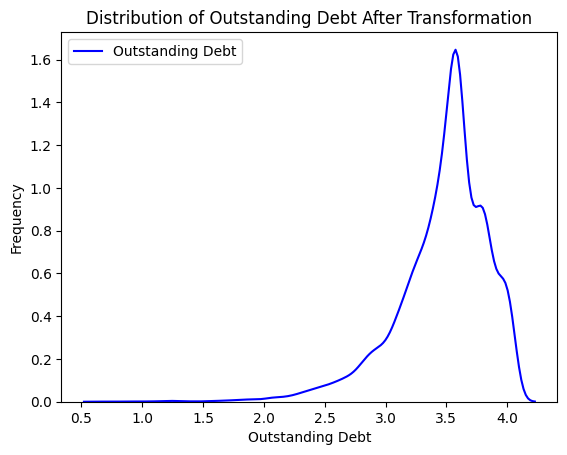

In [ ]:
#apply the log tarnsformation over the highly skewed variable
#visualize any one of features for hghy skewed
sns.distplot(credit_score_df_unique['Outstanding_Debt'], kde=True, hist=False,
                    color='blue', label='Outstanding Debt')
plt.xlabel('Outstanding Debt')
plt.ylabel('Frequency')
plt.title('Distribution of Outstanding Debt After Transformation')
plt.legend()

In [ ]:
credit_score_df_unique

Customer_ID       ID   Month            Name   Age          SSN  \
0      CUS_0x1000  0x16291  August  Alistair Barrf  18.0  913741218.0   
1      CUS_0x8cbe  0x12079  August  Giorgio Stevew  39.0  236250124.0   
2      CUS_0x8cc1  0x1ef79  August       Kazunorii  43.0  331243360.0   
3      CUS_0x8cc5   0xaa59  August  Stanley Whitep  37.0  311387874.0   
4      CUS_0x8cc8  0x17f71  August          Douwes  43.0  646259153.0   
...           ...      ...     ...             ...   ...          ...   
12495  CUS_0x4f3e   0xe659  August       Beckfordz  47.0  341945301.0   
12496  CUS_0x4f41  0x106f9  August        Miedemaf  38.0  702760398.0   
12497  CUS_0x4f43  0x215e9  August  Silvia Aloisir  34.0  282991365.0   
12498  CUS_0x4f05  0x11449  August       Ian Chuav  18.0   89631676.0   
12499   CUS_0xffd  0x25b01  August        Damouniq  30.0  832888320.0   

       Occupation  Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  \
0          Lawyer       0.413881               2.905386           1.162283   
1         Manager       0.414454               2.723438           1.124748   
2      Accountant       0.413905               2.484104           1.124748   
3       Architect       0.414463               2.518038           0.869742   
4         Manager       0.414706               2.806227           1.026672   
...           ...            ...                    ...                ...   
12495      Lawyer       0.413463               2.884658           1.124748   
12496    Mechanic       0.413396               2.717928           1.271150   
12497      Doctor       0.412700               2.617141           1.223156   
12498    Musician       0.413941               2.826572           1.194706   
12499   Scientist       0.414085               2.795483           1.223156   

       ...  Monthly_Balance  Credit_Score  Spending Level Payment Value  \
0      ...         2.824036          Poor            High        Medium   
1      ...         2.966050          Good             Low         Small   
2      ...         2.907530          Poor             Low         Large   
3      ...         2.927819      Standard            High         Small   
4      ...         3.024092      Standard            High         Large   
...    ...              ...           ...             ...           ...   
12495  ...         3.015265      Standard             Low         Small   
12496  ...         2.969847          Poor            High        Medium   
12497  ...         2.885607          Poor             Low         Small   
12498  ...         2.982909          Poor            High        Medium   
12499  ...         2.927717          Good            High         Large   

       Credit_History_Year  Credit_History_Month  Utilization_Change  \
0                       13                    3             0.000787   
1                       22                    6             5.328078   
2                        3                   11             3.673075   
3                        7                    6            -4.962189   
4                       19                    8             1.738453   
...                    ...                   ...                 ...   
12495                   12                    9            -1.575882   
12496                   12                   11             0.178265   
12497                    1                    6             2.224688   
12498                    7                   11            -5.689527   
12499                    7                    8            10.039198   

       High_Risk_Limit_Util Risk_Spending  Financial_Stress_Index  
0                         0      0.866366                1.712373  
1                         1      0.956945                1.839543  
2                         1      0.653358                1.990841  
3                         0      0.735194                1.906218  
4                         1      0.630370                1.693735  
...               

In [ ]:
#create an copy of dataframe
credit_score_df_unique_copy = credit_score_df_unique.copy()

In [ ]:
credit_score_df_unique_copy.describe()

Age  Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  \
count  12500.000000   12500.000000           12500.000000       12500.000000   
mean      33.603280       0.413983               2.831977           1.124766   
std       10.631465       0.000581               0.157317           0.163430   
min       14.000000       0.412568               2.355601           0.526589   
25%       25.000000       0.413538               2.706965           1.026672   
50%       33.000000       0.414021               2.875401           1.162283   
75%       42.000000       0.414425               2.943129           1.194706   
max       56.000000       0.416217               3.163381           2.136826   

       Num_Credit_Card  Interest_Rate   Num_of_Loan  Delay_from_due_date  \
count     12500.000000   12500.000000  12500.000000         12500.000000   
mean          1.107821       1.265105      1.686242            21.060880   
std           0.170982       0.251296      0.237643            14.863091   
min           0.526589       0.526589      0.526589            -5.000000   
25%           1.026672       1.162283      1.730662            10.000000   
50%           1.080418       1.310506      1.732356            18.000000   
75%           1.162283       1.397363      1.735688            28.000000   
max           2.117927       2.268396      2.125356            67.000000   

       Num_of_Delayed_Payment  Changed_Credit_Limit  Num_Credit_Inquiries  \
count            12429.000000          12246.000000          12500.000000   
mean                16.825231             10.398582              1.146184   
std                  7.786887              6.799253              0.224988   
min                  0.000000             -6.490000              0.526589   
25%                 12.000000              5.370000              1.026672   
50%                 17.000000              9.410000              1.194706   
75%                 21.000000             14.940000              1.271150   
max                 88.000000             36.970000              2.181742   

       Outstanding_Debt  Credit_Utilization_Ratio  Total_EMI_per_month  \
count      12500.000000              12500.000000         12500.000000   
mean           3.471173                 32.349265             1.668802   
std            0.378924                  5.156815             0.205683   
min            0.693147                 20.100770             0.983249   
25%            3.296691                 28.066517             1.556477   
50%            3.544770                 32.418953             1.663554   
75%            3.722108                 36.623650             1.777726   
max            4.055527                 48.199824             2.422139   

       Amount_invested_monthly  Monthly_Balance  Utilization_Change  \
count             12500.000000     12500.000000        12500.000000   
mean                  1.979529         2.954609            0.000787   
std                   0.191288         0.171092            7.316360   
min                   1.319219         0.693147          -22.180605   
25%                   1.860581         2.885945           -5.260252   
50%                   1.998154         2.947088            0.031254   
75%                   2.088464         3.032198            5.279835   
max                   2.503370         3.450521           21.543981   

       High_Risk_Limit_Util  Risk_Spending  Financial_Stress_Index  
count          12500.000000   12500.000000            12500.000000  
mean               0.482240       0.654812                1.685619  
std                0.499704       0.118710                0.205293  
min                0.000000       0.353535                0.693147  
25%                0.000000       0.571603                1.568525  
50%                0.000000       0.645315                1.706678  
75%                1.000000       0.723540                1.827278  
max                1.000000       1.125768               

In [ ]:
import numpy as np
import pandas as pd
import logging

logging.basicConfig(level=logging.INFO, format='%(message)s')

columns_to_check = [
    col for col in credit_score_df_unique.columns
    if credit_score_df_unique[col].dtype in ['int64', 'float64', 'int32', 'float32']
]

print(f"Outlier detection Columns: {columns_to_check}")

class AdaptiveIQR:
    def __init__(self, df, columns):
        self.df = df.copy()
        self.columns = columns
        self.outlier_details = {}
        self.columns_with_outliers = []
        self.quantile_map = {}

    def get_quantile_range(self, skew):
        if abs(skew) < 0.5:
            return (0.05, 0.95)
        elif abs(skew) < 1:
            return (0.10, 0.90)
        elif abs(skew) < 3:
            return (0.02, 0.98)
        else:
            return (0.01, 0.99)

    def remove_outliers(self):
        df_cleaned = self.df.copy()
        for col in self.columns:
            if df_cleaned[col].isnull().all():
                continue
            df_cleaned[col].replace([np.inf, -np.inf], np.nan, inplace=True)
            df_cleaned[col].fillna(df_cleaned[col].median(), inplace=True)
            skewness = df_cleaned[col].skew()
            q1_q3 = self.get_quantile_range(skewness)
            q1 = df_cleaned[col].quantile(q1_q3[0])
            q3 = df_cleaned[col].quantile(q1_q3[1])
            iqr = q3 - q1
            lower = q1 - 1.5 * iqr
            upper = q3 + 1.5 * iqr
            self.quantile_map[col] = q1_q3
            mask = (df_cleaned[col] >= lower) & (df_cleaned[col] <= upper)
            num_outliers = len(df_cleaned) - mask.sum()
            if num_outliers > 0:
                self.columns_with_outliers.append(col)
                self.outlier_details[col] = {
                    "skewness": skewness,
                    "quantile_range": q1_q3,
                    "num_outliers": int(num_outliers)
                }
                df_cleaned = df_cleaned[mask]
                logging.info(f"✅ {col}: skew={skewness:.3f}, removed {num_outliers} outliers")
        return df_cleaned, self.columns_with_outliers, self.outlier_details

iqr_detector = AdaptiveIQR(credit_score_df_unique_copy, columns_to_check)
cleaned_df_copy, cols_with_outliers, outlier_info = iqr_detector.remove_outliers()

print(f"\nColumns with Outliers: {cols_with_outliers}")
print(f"Number of rows before cleaning: {len(credit_score_df_unique_copy)}")
print(f"Number of rows after cleaning: {len(cleaned_df_copy)}\n")

for col, info in outlier_info.items():
    print(f"{col}: skew={info['skewness']:.3f}, quantile_range={info['quantile_range']}, outliers={info['num_outliers']}")


Outlier detection Columns: ['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Total_EMI_per_month', 'Amount_invested_monthly', 'Monthly_Balance', 'Utilization_Change', 'High_Risk_Limit_Util', 'Risk_Spending', 'Financial_Stress_Index']

Columns with Outliers: ['Num_Bank_Accounts', 'Num_of_Delayed_Payment', 'Monthly_Balance']
Number of rows before cleaning: 12500
Number of rows after cleaning: 12429

Num_Bank_Accounts: skew=1.524, quantile_range=(0.02, 0.98), outliers=67
Num_of_Delayed_Payment: skew=0.268, quantile_range=(0.05, 0.95), outliers=1
Monthly_Balance: skew=-1.762, quantile_range=(0.02, 0.98), outliers=3


In [ ]:
#convert the credit inqeuries into integer
cleaned_df_copy['Num_Credit_Inquiries'] = pd.to_numeric(cleaned_df_copy['Num_Credit_Inquiries'], errors='coerce')
cleaned_df_copy['Num_Credit_Inquiries'] = cleaned_df_copy['Num_Credit_Inquiries'].astype('int64')
cleaned_df_copy['Num_Credit_Inquiries'].unique()

array([1, 0, 2])

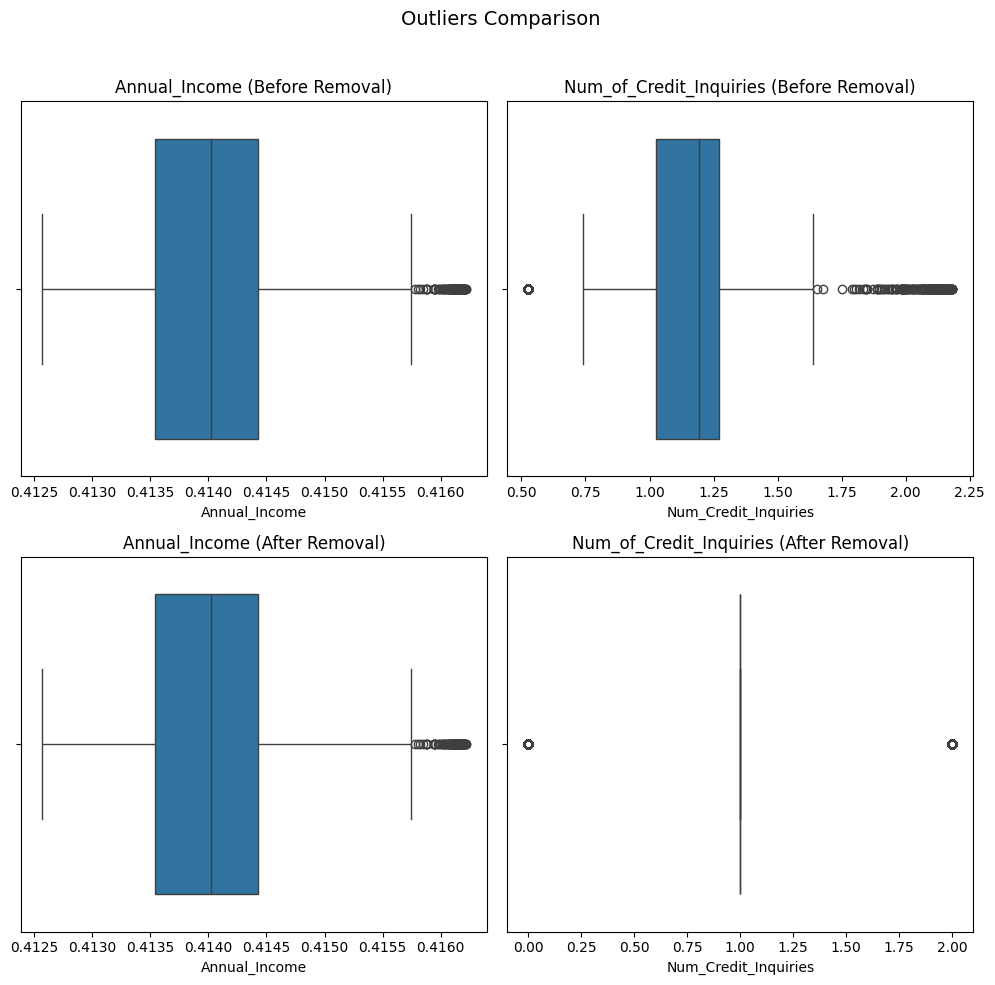

In [ ]:
#compare the each columns wiht previous outilers and after remval outliers
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle("Outliers Comparison", fontsize=14)

# Plot for Annual_Income
sns.boxplot(data=credit_score_df_unique, x='Annual_Income', ax=ax[0, 0])
ax[0, 0].set_title("Annual_Income (Before Removal)")

sns.boxplot(data=cleaned_df_copy, x='Annual_Income', ax=ax[1, 0])
ax[1, 0].set_title("Annual_Income (After Removal)")

# Plot for Num_of_Credit_Inquiries
sns.boxplot(data=credit_score_df_unique, x='Num_Credit_Inquiries', ax=ax[0, 1])
ax[0, 1].set_title("Num_of_Credit_Inquiries (Before Removal)")

sns.boxplot(data=cleaned_df_copy, x='Num_Credit_Inquiries', ax=ax[1, 1])
ax[1, 1].set_title("Num_of_Credit_Inquiries (After Removal)")

# Layout adjustment
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



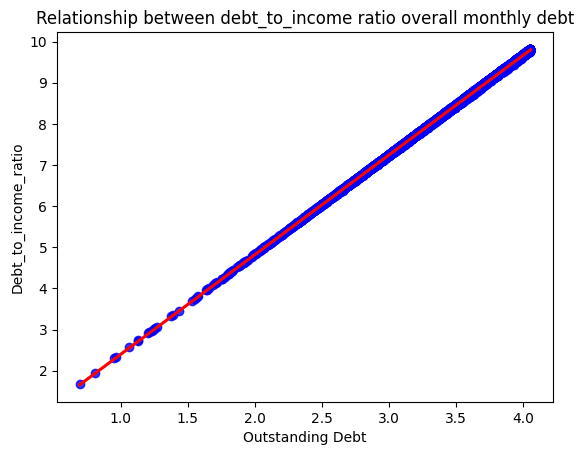

In [ ]:
#create debt_to_income ratio feature over monthly income over the gross income
def create_debt_income_ratio(df):
  logging.info("Setup the debt income ratio function processs")
  try:
    debt_to_income_ratio = df['Outstanding_Debt'] / df['Annual_Income']
    df['Debt_to_income_ratio'] = debt_to_income_ratio
    return df
  except Exception as e:
    logging.error(e)


#call the function for debt income ratio
cleaned_df = create_debt_income_ratio(credit_score_df_unique)
cleaned_df['Debt_to_income_ratio']

sns.regplot(x='Outstanding_Debt', y='Debt_to_income_ratio', data=cleaned_df,
            scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.xlabel('Outstanding Debt')
plt.ylabel('Debt_to_income_ratio')
plt.title("Relationship between debt_to_income ratio overall monthly debt")
plt.show()


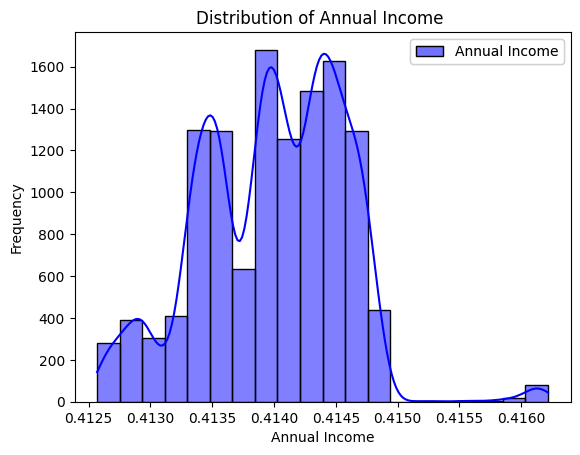

In [ ]:
fig = sns.histplot(x='Annual_Income',data=credit_score_df_unique,kde=True,bins=20,color='blue',
                    label='Annual Income')

plt.xlabel('Annual Income')
plt.ylabel('Frequency')
plt.title("Distribution of Annual Income ")
fig.add_artist(plt.legend())
plt.show()


# Split Features into Two inference Training and Testing

In [ ]:
from sklearn.preprocessing import PowerTransformer  #apply yeo-johnson test for cappping numeric values towrds median distribution

#apply capping to negative values
cols_to_cap = [
    "Delay_from_due_date",
    "Num_of_Delayed_Payment",
    "Changed_Credit_Limit",
    "Utilization_Change"
]


#apply yheo johnson technique for capping the features ove rnegative values
pt = PowerTransformer(method = "yeo-johnson")
credit_score_df_unique[cols_to_cap] = pt.fit_transform(credit_score_df_unique[cols_to_cap])

credit_score_df_unique[cols_to_cap]

Delay_from_due_date  Num_of_Delayed_Payment  Changed_Credit_Limit  \
0                 1.996468                0.191899             -1.378444   
1                 0.656808               -0.187982             -1.589510   
2                -0.260824                0.315984              0.174251   
3                -0.504471               -0.852945             -0.652760   
4                -0.877133               -1.133874              0.260002   
...                    ...                     ...                   ...   
12495            -0.260824               -0.716109              0.388692   
12496             1.785465                0.560786             -0.190037   
12497             1.034946                1.272181              1.025287   
12498             1.828417                0.560786              1.795163   
12499             0.296727               -0.187982              0.321185   

       Utilization_Change  
0                0.001306  
1                0.728534  
2                0.502734  
3               -0.677902  
4                0.238669  
...                   ...  
12495           -0.214330  
12496            0.025562  
12497            0.305052  
12498           -0.777517  
12499            1.370984  

[12500 rows x 4 columns]

In [ ]:
credit_score_df_unique

Customer_ID       ID   Month            Name   Age          SSN  \
0      CUS_0x1000  0x16291  August  Alistair Barrf  18.0  913741218.0   
1      CUS_0x8cbe  0x12079  August  Giorgio Stevew  39.0  236250124.0   
2      CUS_0x8cc1  0x1ef79  August       Kazunorii  43.0  331243360.0   
3      CUS_0x8cc5   0xaa59  August  Stanley Whitep  37.0  311387874.0   
4      CUS_0x8cc8  0x17f71  August          Douwes  43.0  646259153.0   
...           ...      ...     ...             ...   ...          ...   
12495  CUS_0x4f3e   0xe659  August       Beckfordz  47.0  341945301.0   
12496  CUS_0x4f41  0x106f9  August        Miedemaf  38.0  702760398.0   
12497  CUS_0x4f43  0x215e9  August  Silvia Aloisir  34.0  282991365.0   
12498  CUS_0x4f05  0x11449  August       Ian Chuav  18.0   89631676.0   
12499   CUS_0xffd  0x25b01  August        Damouniq  30.0  832888320.0   

       Occupation  Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  \
0          Lawyer       0.413881               2.905386           1.162283   
1         Manager       0.414454               2.723438           1.124748   
2      Accountant       0.413905               2.484104           1.124748   
3       Architect       0.414463               2.518038           0.869742   
4         Manager       0.414706               2.806227           1.026672   
...           ...            ...                    ...                ...   
12495      Lawyer       0.413463               2.884658           1.124748   
12496    Mechanic       0.413396               2.717928           1.271150   
12497      Doctor       0.412700               2.617141           1.223156   
12498    Musician       0.413941               2.826572           1.194706   
12499   Scientist       0.414085               2.795483           1.223156   

       ...  Credit_Score  Spending Level  Payment Value Credit_History_Year  \
0      ...          Poor            High         Medium                  13   
1      ...          Good             Low          Small                  22   
2      ...          Poor             Low          Large                   3   
3      ...      Standard            High          Small                   7   
4      ...      Standard            High          Large                  19   
...    ...           ...             ...            ...                 ...   
12495  ...      Standard             Low          Small                  12   
12496  ...          Poor            High         Medium                  12   
12497  ...          Poor             Low          Small                   1   
12498  ...          Poor            High         Medium                   7   
12499  ...          Good            High          Large                   7   

       Credit_History_Month  Utilization_Change  High_Risk_Limit_Util  \
0                        3             0.001306                     0   
1                        6             0.728534                     1   
2                       11             0.502734                     1   
3                        6            -0.677902                     0   
4                        8             0.238669                     1   
...                     ...                 ...                   ...   
12495                    9            -0.214330                     0   
12496                   11             0.025562                     1   
12497                    6             0.305052                     1   
12498                   11            -0.777517                     0   
12499                    8             1.370984                     1   

       Risk_Spending Financial_Stress_Index  Debt_to_income_ratio  
0           0.866366               1.712373              8.812868  
1           0.956945               1.839543              8.726602  
2           0.653358               1.990841              8.658073  
3           0.735194               1.906218              8.288633  
4           0.630370      

In [ ]:
#create an two variable as input variable and output variable
input_var = credit_score_df_unique.drop('Credit_Score',axis=1)
output_var = credit_score_df_unique['Credit_Score']


print(f" Input Features {input_var.shape}")
print(f" Output Features {output_var.shape}")

 Input Features (12500, 34)
 Output Features (12500,)


In [ ]:
columns_to_remove = [['Customer_ID','ID','Month','Name','SSN']]
for cols in columns_to_remove:
  input_var.drop(cols,axis=1,inplace=True)

input_var

Age  Occupation  Annual_Income  Monthly_Inhand_Salary  \
0      18.0      Lawyer       0.413881               2.905386   
1      39.0     Manager       0.414454               2.723438   
2      43.0  Accountant       0.413905               2.484104   
3      37.0   Architect       0.414463               2.518038   
4      43.0     Manager       0.414706               2.806227   
...     ...         ...            ...                    ...   
12495  47.0      Lawyer       0.413463               2.884658   
12496  38.0    Mechanic       0.413396               2.717928   
12497  34.0      Doctor       0.412700               2.617141   
12498  18.0    Musician       0.413941               2.826572   
12499  30.0   Scientist       0.414085               2.795483   

       Num_Bank_Accounts  Num_Credit_Card  Interest_Rate  Num_of_Loan  \
0               1.162283         1.080418       1.466077     1.730662   
1               1.124748         1.026672       1.194706     1.732356   
2               1.124748         1.080418       1.271150     1.732356   
3               0.869742         0.741276       1.271150     1.728949   
4               1.026672         1.026672       1.080418     1.738947   
...                  ...              ...            ...          ...   
12495           1.124748         1.124748       1.248441     1.728949   
12496           1.271150         1.124748       1.448822     1.735688   
12497           1.223156         1.248441       1.358505     1.738947   
12498           1.194706         1.248441       1.385227     1.742137   
12499           1.223156         1.162283       1.291725     1.737326   

                   Type_of_Loan  Delay_from_due_date  ...  Monthly_Balance  \
0                 Not Specified             1.996468  ...         2.824036   
1              Home Equity Loan             0.656808  ...         2.966050   
2                 Personal Loan            -0.260824  ...         2.907530   
3                 Mortgage Loan            -0.504471  ...         2.927819   
4                   Payday Loan            -0.877133  ...         3.024092   
...                         ...                  ...  ...              ...   
12495                 Auto Loan            -0.260824  ...         3.015265   
12496             Personal Loan             1.785465  ...         2.969847   
12497       Credit-Builder Loan             1.034946  ...         2.885607   
12498               Payday Loan             1.828417  ...         2.982909   
12499   Debt Consolidation Loan             0.296727  ...         2.927717   

       Spending Level  Payment Value Credit_History_Year  \
0                High         Medium                  13   
1                 Low          Small                  22   
2                 Low          Large                   3   
3                High          Small                   7   
4                High          Large                  19   
...               ...            ...                 ...   
12495             Low          Small                  12   
12496            High         Medium                  12   
12497             Low          Small                   1   
12498            High         Medium                   7   
12499            High          Large                   7   

       Credit_History_Month  Utilization_Change High_Risk_Limit_Util  \
0                        3             0.001306                    0   
1                        6             0.728534                    1   
2                       11             0.502734                    1   
3                        6            -0.677902                    0   
4                        8             0.238669                    1   
...                     ...                 ...                  ...   
12495                    9            -0.214330                    0   
12496                   11             0.025562                    1   
12497                    6             0.305

Split the individual features into training and testing

In [ ]:
#split the features by creating class for Feature splitting into training set of samples and testing samples
cleaned_df = credit_score_df_unique.copy()
class Feature_splitting:

  def __init__(self, input_feature, output_feature,df):
    super().__init__()  #call the init method
    self.input_var = input_feature
    self.output_var = output_feature
    self.df = df
    self.training_size = 70/100   #split the features into 70% training sample
    self.testing_size = 30/100   #split the  features into 30% testing sample
    self.shuffle = True
    self.stratify = self.output_var #stratification helps model to make learn all classes

  def split_features(self):
    logging.info("Setup the split features method ")
    try:
      X_train , X_test , y_train , y_test = train_test_split(
          self.input_var , self.output_var , train_size = self.training_size , test_size = self.testing_size,
          stratify = self.stratify ,
          shuffle = self.shuffle
      )
      return X_train , X_test , y_train , y_test  #return the trai
    except Exception as e:
      return logging.error(f" Unexpected Error {e} Occured")

feature_splitter = Feature_splitting(input_var,output_var,cleaned_df)
X_train , X_test , y_train , y_test = feature_splitter.split_features()

print(f"Training Input Features shape {X_train.shape}")
print(f"Testing Input Features shape {X_test.shape}")
print(f"Training Output Feature shape {y_train.shape}")
print(f"Testing Output Feature shape {y_test.shape}")


Training Input Features shape (8750, 29)
Testing Input Features shape (3750, 29)
Training Output Feature shape (8750,)
Testing Output Feature shape (3750,)


In [ ]:
print(f" Training Features : {X_train}")
print(f" Testing Features : {y_train}")

 Training Features :         Age     Occupation  Annual_Income  Monthly_Inhand_Salary  \
1243   20.0         Doctor       0.413541               2.932691   
9855   18.0       Musician       0.414679               3.066039   
2124   17.0       Musician       0.413416               2.804769   
7261   26.0  Media_Manager       0.414447               2.905305   
12482  41.0     Accountant       0.413692               2.612031   
...     ...            ...            ...                    ...   
1733   53.0      Scientist       0.414511               2.884658   
8499   27.0       Musician       0.413615               2.884658   
6544   21.0       Mechanic       0.413354               2.577131   
11378  33.0     Journalist       0.413980               2.965475   
4228   37.0         Lawyer       0.414760               2.982509   

       Num_Bank_Accounts  Num_Credit_Card  Interest_Rate  Num_of_Loan  \
1243            1.026672         1.162283       1.448822     1.738947   
9855            

In [ ]:
#there are some NaN values need to remove and fill mean values
columns = ['Risk_Spending','Financial_Stress_Index','Debt_to_income_ratio']
X_train[columns] = X_train[columns].fillna(X_train[columns].mean())
X_test[columns] = X_test[columns].fillna(X_test[columns].mean())

print(f" Training Features : {X_train}")
print(f" Testing Features : {X_test}")

 Training Features :         Age     Occupation  Annual_Income  Monthly_Inhand_Salary  \
1243   20.0         Doctor       0.413541               2.932691   
9855   18.0       Musician       0.414679               3.066039   
2124   17.0       Musician       0.413416               2.804769   
7261   26.0  Media_Manager       0.414447               2.905305   
12482  41.0     Accountant       0.413692               2.612031   
...     ...            ...            ...                    ...   
1733   53.0      Scientist       0.414511               2.884658   
8499   27.0       Musician       0.413615               2.884658   
6544   21.0       Mechanic       0.413354               2.577131   
11378  33.0     Journalist       0.413980               2.965475   
4228   37.0         Lawyer       0.414760               2.982509   

       Num_Bank_Accounts  Num_Credit_Card  Interest_Rate  Num_of_Loan  \
1243            1.026672         1.162283       1.448822     1.738947   
9855            

In [ ]:
#encode the label encoder for some features
from sklearn.preprocessing import OneHotEncoder , LabelEncoder
#create an copy of target variable for input and output
y_train_copy = y_train.copy()
y_test_copy = y_test.copy()

def encode_target_variable(y_train, y_test, column_name):
  """ Encode the target variable with numeric labels"""
  logging.info("Setup the target variable encoding process")

  #apply the Label Encoding over Training Input and output
  le = LabelEncoder()
  y_train_encoded = le.fit_transform(y_train)
  y_test_encoded= le.transform(y_test)

  return y_train_encoded , y_test_encoded


#call the above function
y_train , y_test = encode_target_variable(y_train_copy,y_test_copy,'Credit_Score')
print(f" Unique Values in Training Output {np.unique(y_train)}")
print(f" Unique Values in Testing Output {np.unique(y_test)}")

#convert into dataframe
y_train = pd.DataFrame(y_train,columns=['Credit_Score'])
y_test = pd.DataFrame(y_test,columns=['Credit_Score'])

y_train

 Unique Values in Training Output [0 1 2]
 Unique Values in Testing Output [0 1 2]


Credit_Score
0                2
1                0
2                2
3                1
4                2
...            ...
8745             1
8746             2
8747             1
8748             2
8749             0

[8750 rows x 1 columns]

In [ ]:
credit_score_df_unique

Customer_ID       ID   Month            Name   Age          SSN  \
0      CUS_0x1000  0x16291  August  Alistair Barrf  18.0  913741218.0   
1      CUS_0x8cbe  0x12079  August  Giorgio Stevew  39.0  236250124.0   
2      CUS_0x8cc1  0x1ef79  August       Kazunorii  43.0  331243360.0   
3      CUS_0x8cc5   0xaa59  August  Stanley Whitep  37.0  311387874.0   
4      CUS_0x8cc8  0x17f71  August          Douwes  43.0  646259153.0   
...           ...      ...     ...             ...   ...          ...   
12495  CUS_0x4f3e   0xe659  August       Beckfordz  47.0  341945301.0   
12496  CUS_0x4f41  0x106f9  August        Miedemaf  38.0  702760398.0   
12497  CUS_0x4f43  0x215e9  August  Silvia Aloisir  34.0  282991365.0   
12498  CUS_0x4f05  0x11449  August       Ian Chuav  18.0   89631676.0   
12499   CUS_0xffd  0x25b01  August        Damouniq  30.0  832888320.0   

       Occupation  Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  \
0          Lawyer       0.413881               2.905386           1.162283   
1         Manager       0.414454               2.723438           1.124748   
2      Accountant       0.413905               2.484104           1.124748   
3       Architect       0.414463               2.518038           0.869742   
4         Manager       0.414706               2.806227           1.026672   
...           ...            ...                    ...                ...   
12495      Lawyer       0.413463               2.884658           1.124748   
12496    Mechanic       0.413396               2.717928           1.271150   
12497      Doctor       0.412700               2.617141           1.223156   
12498    Musician       0.413941               2.826572           1.194706   
12499   Scientist       0.414085               2.795483           1.223156   

       ...  Credit_Score  Spending Level  Payment Value Credit_History_Year  \
0      ...          Poor            High         Medium                  13   
1      ...          Good             Low          Small                  22   
2      ...          Poor             Low          Large                   3   
3      ...      Standard            High          Small                   7   
4      ...      Standard            High          Large                  19   
...    ...           ...             ...            ...                 ...   
12495  ...      Standard             Low          Small                  12   
12496  ...          Poor            High         Medium                  12   
12497  ...          Poor             Low          Small                   1   
12498  ...          Poor            High         Medium                   7   
12499  ...          Good            High          Large                   7   

       Credit_History_Month  Utilization_Change  High_Risk_Limit_Util  \
0                        3             0.001306                     0   
1                        6             0.728534                     1   
2                       11             0.502734                     1   
3                        6            -0.677902                     0   
4                        8             0.238669                     1   
...                     ...                 ...                   ...   
12495                    9            -0.214330                     0   
12496                   11             0.025562                     1   
12497                    6             0.305052                     1   
12498                   11            -0.777517                     0   
12499                    8             1.370984                     1   

       Risk_Spending Financial_Stress_Index  Debt_to_income_ratio  
0           0.866366               1.712373              8.812868  
1           0.956945               1.839543              8.726602  
2           0.653358               1.990841              8.658073  
3           0.735194               1.906218              8.288633  
4           0.630370      

In [ ]:
#remove the customers historical information for list of features from training input and testing input
drop_columns = ['Customer_ID', 'ID', 'SSN', 'Name']
for cols in drop_columns:
  X_train.drop(drop_columns,axis=1,inplace=True)  #drop features from Training input columns
  X_test.drop(drop_columns,axis=1,inplace=True)  #drop features from Testing input columns

KeyError: "['Customer_ID', 'ID', 'SSN', 'Name'] not found in axis"

In [ ]:
y_train

In [ ]:
#drop the month column for both training input and training output
X_train.drop('Month',axis=1,inplace=True)
X_test.drop('Month',axis=1,inplace=True)

X_train

In [ ]:
X_train.columns

In [ ]:
#check the ordinal features and nominal features and numeric features
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder , OrdinalEncoder

#define the ordinal features and nominal features into list
ordinal_features = ['Payment_of_Min_Amount','Credit_Mix','Spending Level','Payment Value']
nominal_features = ['Occupation','Type_of_Loan']
numeric_features = []
for cols in X_train.columns:
  if cols not in ordinal_features and cols not in nominal_features:
    numeric_features.append(cols)

print(f" Ordinal Features columns : {ordinal_features}")  #this features should be applied as OrdinalEncoding
print(f" nominal Features columns : {nominal_features}")  #this features shoud be apply for One hot encoding
print(f" Numeric Features columns : {numeric_features}")  #this features should be applied as Standardization

 Ordinal Features columns : ['Payment_of_Min_Amount', 'Credit_Mix', 'Spending Level', 'Payment Value']
 nominal Features columns : ['Occupation', 'Type_of_Loan']
 Numeric Features columns : ['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Total_EMI_per_month', 'Amount_invested_monthly', 'Monthly_Balance', 'Credit_History_Year', 'Credit_History_Month', 'Utilization_Change', 'High_Risk_Limit_Util', 'Risk_Spending', 'Financial_Stress_Index', 'Debt_to_income_ratio']


In [ ]:
X_train.info()

In [ ]:
X_train.to_csv("sample_X_train.csv",index=False)
X_test.to_csv("Sample_X_test.csv",index=False)

# Tree Based Feature selection

In [ ]:
X_train.columns

Index(['Age', 'Occupation', 'Annual_Income', 'Monthly_Inhand_Salary',
       'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
       'Type_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment',
       'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Credit_Mix',
       'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Payment_of_Min_Amount',
       'Total_EMI_per_month', 'Amount_invested_monthly', 'Monthly_Balance',
       'Spending Level', 'Payment Value', 'Credit_History_Year',
       'Credit_History_Month', 'Utilization_Change', 'High_Risk_Limit_Util',
       'Risk_Spending', 'Financial_Stress_Index', 'Debt_to_income_ratio'],
      dtype='object')

In [ ]:
X_train.columns

Index(['Age', 'Occupation', 'Annual_Income', 'Monthly_Inhand_Salary',
       'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
       'Type_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment',
       'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Credit_Mix',
       'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Payment_of_Min_Amount',
       'Total_EMI_per_month', 'Amount_invested_monthly', 'Monthly_Balance',
       'Spending Level', 'Payment Value', 'Credit_History_Year',
       'Credit_History_Month', 'Utilization_Change', 'High_Risk_Limit_Util',
       'Risk_Spending', 'Financial_Stress_Index', 'Debt_to_income_ratio'],
      dtype='object')

In [ ]:
#create an preprocessing pipeline with All columns transofrmation am model into single pipeline workflow
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder , OrdinalEncoder , RobustScaler
from sklearn.pipeline import Pipeline
from pydantic import BaseModel , Field
from typing import List


#request the schema processing workflow into list and specific type
class ProcessingSchema(BaseModel):
  preprocessing_task : List[str] = Field(description = "Random Forest Preprocessing Task")
  categories : List[str] = Field(description = "Categorical Columns")

#store all unique value in catgeories list for ordinal encoder to disorts the sequence
unique_values_for_payment_of_min_amount = X_train['Payment_of_Min_Amount'].unique()
unique_values_for_credit_mix = X_train['Credit_Mix'].unique()
unique_values_for_spending_level = X_train['Spending Level'].unique()
unique_values_for_payment_value = X_train['Payment Value'].unique()
ordinal_categories = [
    unique_values_for_payment_of_min_amount,
    unique_values_for_credit_mix,
    unique_values_for_spending_level,
    unique_values_for_payment_value
]

#create an function for Modelling preprocessing workflow
preprocessing_task = [
    ('ordinal_encoder', OrdinalEncoder(categories=ordinal_categories), ordinal_features),
    ('nominal_encoder', OneHotEncoder(handle_unknown='ignore', drop='first'), nominal_features),
    ('Robust_scaler', RobustScaler(), numeric_features)  #using robust standard to fix minor outliers
]
def Baseline_column_preprocesing_workflow(preprocessing_task : list):
  """ Create an preprocessing pipeline with All columns transofrmation am model into single pipeline workflow """
  logging.info("Setup the Pipeline workflow for preprocessing")
  try:
    #create an preprocessing pipeline with All columns transformation of model into single pipeline
    preprocessor = ColumnTransformer(
        transformers=preprocessing_task,
        remainder='drop'
    )
    return preprocessor
  except Exception as e:
    logging.error(f" Unexpected Error {e} Occured")

#call the above function
preprocessor = Baseline_column_preprocesing_workflow(preprocessing_task)
preprocessor




ColumnTransformer(transformers=[('ordinal_encoder',
                                 OrdinalEncoder(categories=[array(['Yes', 'No', 'NM'], dtype=object),
                                                            array(['Standard', 'Good', 'Bad'], dtype=object),
                                                            array(['High', 'Low'], dtype=object),
                                                            array(['Medium', 'Large', 'Small'], dtype=object)]),
                                 ['Payment_of_Min_Amount', 'Credit_Mix',
                                  'Spending Level', 'Payment Value']),
                                ('nominal_encoder',
                                 OneHotEncoder(...
                                  'Num_of_Loan', 'Delay_from_due_date',
                                  'Num_of_Delayed_Payment',
                                  'Changed_Credit_Limit',
                                  'Num_Credit_Inquiries', 'Outstanding_Debt',
                                  'Credit_Utilization_Ratio',
                                  'Total_EMI_per_month',
                                  'Amount_invested_monthly', 'Monthly_Balance',
                                  'Credit_History_Year', 'Credit_History_Month',
                                  'Utilization_Change', 'High_Risk_Limit_Util',
                                  'Risk_Spending', 'Financial_Stress_Index',
                                  'Debt_to_income_ratio'])])

In [ ]:
print(X_train['Payment_of_Min_Amount'].unique())
print(X_train['Credit_Mix'].unique())
print(X_train['Spending Level'].unique())
print(X_train['Payment Value'].unique())

['Yes' 'No' 'NM']
['Standard' 'Good' 'Bad']
['High' 'Low']
['Medium' 'Large' 'Small']


In [ ]:
#create an class feature selection with random forest algorithm for features in training set
from sklearn.model_selection import RandomizedSearchCV , StratifiedKFold
from sklearn.pipeline import Pipeline
import logging

class Feature_selection:

  #create an paramters for feature selection decision making
  def __init__(self,training_input,training_output,preprocessing_workflow):
    self.X_train = training_input
    self.y_train = training_output
    self.preprocessor = preprocessing_workflow
    self.random_state=42  #defing the randomness of Algorihtm
    self.target_weights = 'balanced'  #assign balanced weights to each minority and majority class
    self.model = RandomForestClassifier(random_state=self.random_state,class_weight=self.target_weights)  #create an random forest classifier model object


  #create an baseline model workflow with column processor
  def create_model_workflow_column_processor(self):
    logging.info("Setup the model workflow for column processor")
    try:
      steps = [
          ('preprocessor',self.preprocessor),
          ('Baseline_Model',self.model)
      ]
      #initialize the steps of workflow with Pipeline object
      baseline_workflow = Pipeline(steps=steps)
      return baseline_workflow  #return the baseline worflow object
    except Exception as e:
      logging.error(f" Unexpected Error {e} Occured")

  #create an method for parameter for function tunining
  def create_parameter_tuning(self,baseline_workflow):
    logging.info("Setup Paramter tuning parameters")
    try:
      param_grid = {'Baseline_Model__n_estimators': [100, 200,300,150],
                    'Baseline_Model__max_depth': [5,7,10,15,None],
                    'Baseline_Model__min_samples_split': [2, 5, 10],  #define the split of nodes within tree bas
                    'Baseline_Model__max_features':['auto','sqrt']  #max feature parameters for node wise learning
      }

      #create an parameter tuning with Randomized SearchCV over grid search CV
      random_search_cv = StratifiedKFold(n_splits=5)  #apply 5 subset sample for Algorithm Training
      random_search_n_jobs = -1  #for faster training computation over Model changes
      random_search = RandomizedSearchCV(estimator=baseline_workflow,
          param_distributions=param_grid,
          cv=random_search_cv,
          n_jobs=random_search_n_jobs)   #random search paramater tuning
      return random_search
    except Exception as e:
      logging.error(f" Unexpected Error {e} Occured")


  #create function for training algorihtm and fetch the feature importance from algorithm
  def train_algorithm(self,random_search):
    logging.info("Setup the training algorithm process")

    #create an list for storing all feature importances
    feature_importances = []
    try:
      rf_model = random_search.fit(self.X_train,self.y_train)  #fit the training set for training process

      #check if training is completed or not and fetch the feature importances from
      if rf_model.best_estimator_ is not None:
        feature_importance = rf_model.best_estimator_.named_steps['Baseline_Model'].feature_importances_

        #append the feature importance into list
        feature_importances.append(feature_importance)  #append the importances into features list
        return feature_importances
    except Exception as e:
      logging.error(f" Unexpected Error {e} Occured") #


#call the above constructor with allocated methods
feature_selector = Feature_selection(X_train,y_train,preprocessor)
baseline_workflow = feature_selector.create_model_workflow_column_processor()
random_search = feature_selector.create_parameter_tuning(baseline_workflow)
feature_importances = feature_selector.train_algorithm(random_search)

rf_model_architecture = random_search
rf_model_architecture

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('ordinal_encoder',
                                                                               OrdinalEncoder(categories=[array(['Yes', 'No', 'NM'], dtype=object),
                                                                                                          array(['Standard', 'Good', 'Bad'], dtype=object),
                                                                                                          array(['High', 'Low'], dtype=object),
                                                                                                          array(['Medium', 'Large', 'Smal...
                                                                                'Financial_Stress_Index',
                                                                                'Debt_to_income_ratio'])])),
                                             ('Baseline_Model',
                                              RandomForestClassifier(class_weight='balanced',
                                                                     random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'Baseline_Model__max_depth': [5, 7, 10,
                                                                      15,
                                                                      None],
                                        'Baseline_Model__max_features': ['auto',
                                                                         'sqrt'],
                                        'Baseline_Model__min_samples_split': [2,
                                                                              5,
                                                                              10],
                                        'Baseline_Model__n_estimators': [100,
                                                                         200,
                                                                         300,
                                                                         150]})

In [ ]:
rf_model_architecture

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('ordinal_encoder',
                                                                               OrdinalEncoder(categories=[array(['Yes', 'No', 'NM'], dtype=object),
                                                                                                          array(['Standard', 'Good', 'Bad'], dtype=object),
                                                                                                          array(['High', 'Low'], dtype=object),
                                                                                                          array(['Medium', 'Large', 'Smal...
                                                                                'Financial_Stress_Index',
                                                                                'Debt_to_income_ratio'])])),
                                             ('Baseline_Model',
                                              RandomForestClassifier(class_weight='balanced',
                                                                     random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'Baseline_Model__max_depth': [5, 7, 10,
                                                                      15,
                                                                      None],
                                        'Baseline_Model__max_features': ['auto',
                                                                         'sqrt'],
                                        'Baseline_Model__min_samples_split': [2,
                                                                              5,
                                                                              10],
                                        'Baseline_Model__n_estimators': [100,
                                                                         200,
                                                                         300,
                                                                         150]})

In [ ]:
#create an dataframe for feature importances
preprocessor.fit(X_train,y_train)  #fit the training input and training output
feature_importances_df = pd.DataFrame({
    "Features":preprocessor.get_feature_names_out(),  #extract the trained features from processing columns
    "Importance":feature_importances[0]  #fetch the single array from list
})
feature_importances_df

Features  Importance
0              ordinal_encoder__Payment_of_Min_Amount    0.076286
1                         ordinal_encoder__Credit_Mix    0.081780
2                     ordinal_encoder__Spending Level    0.004834
3                      ordinal_encoder__Payment Value    0.002707
4               nominal_encoder__Occupation_Architect    0.000758
5               nominal_encoder__Occupation_Developer    0.000567
6                  nominal_encoder__Occupation_Doctor    0.000270
7                nominal_encoder__Occupation_Engineer    0.000363
8            nominal_encoder__Occupation_Entrepreneur    0.000419
9              nominal_encoder__Occupation_Journalist    0.000445
10                 nominal_encoder__Occupation_Lawyer    0.000651
11                nominal_encoder__Occupation_Manager    0.000317
12               nominal_encoder__Occupation_Mechanic    0.000701
13          nominal_encoder__Occupation_Media_Manager    0.000892
14               nominal_encoder__Occupation_Musician    0.000464
15              nominal_encoder__Occupation_Scientist    0.000693
16                nominal_encoder__Occupation_Teacher    0.000654
17                 nominal_encoder__Occupation_Writer    0.000777
18  nominal_encoder__Type_of_Loan_ Credit-Builder ...    0.000936
19  nominal_encoder__Type_of_Loan_ Debt Consolidat...    0.000850
20    nominal_encoder__Type_of_Loan_ Home Equity Loan    0.000686
21       nominal_encoder__Type_of_Loan_ Mortgage Loan    0.000726
22       nominal_encoder__Type_of_Loan_ Not Specified    0.000816
23         nominal_encoder__Type_of_Loan_ Payday Loan    0.001380
24       nominal_encoder__Type_of_Loan_ Personal Loan    0.000711
25        nominal_encoder__Type_of_Loan_ Student Loan    0.000640
26            nominal_encoder__Type_of_Loan_Auto Loan    0.000264
27  nominal_encoder__Type_of_Loan_Credit-Builder Loan    0.000356
28  nominal_encoder__Type_of_Loan_Debt Consolidati...    0.000260
29     nominal_encoder__Type_of_Loan_Home Equity Loan    0.000687
30        nominal_encoder__Type_of_Loan_Mortgage Loan    0.000467
31        nominal_encoder__Type_of_Loan_Not Specified    0.000157
32          nominal_encoder__Type_of_Loan_Payday Loan    0.000205
33        nominal_encoder__Type_of_Loan_Personal Loan    0.000348
34         nominal_encoder__Type_of_Loan_Student Loan    0.000192
35                                 Robust_scaler__Age    0.010837
36                       Robust_scaler__Annual_Income    0.029904
37               Robust_scaler__Monthly_Inhand_Salary    0.009343
38                   Robust_scaler__Num_Bank_Accounts    0.048880
39                     Robust_scaler__Num_Credit_Card    0.041431
40                       Robust_scaler__Interest_Rate    0.099354
41                         Robust_scaler__Num_of_Loan    0.030170
42                 Robust_scaler__Delay_from_due_date    0.104689
43              Robust_scaler__Num_of_Delayed_Payment    0.006280
44                Robust_scaler__Changed_Credit_Limit    0.031680
45                Robust_scaler__Num_Credit_Inquiries    0.004826
46                    Robust_scaler__Outstanding_Debt    0.132936
47            Robust_scaler__Credit_Utilization_Ratio    0.009204
48                 Robust_scaler__Total_EMI_per_month    0.024665
49             Robust_scaler__Amount_invested_monthly    0.007803
50                     Robust_scaler__Monthly_Balance    0.008578
51                 Robust_scaler__Credit_History_Year    0.006492
52                Robust_scaler__Credit_History_Month    0.004070
53                  Robust_scaler__Utilization_Change    0.007996
54                Robust_scaler__High_Risk_Limit_Util    0.000841
55                       Robust_scaler__Risk_Spending    0.027261
56              Robust_scaler__Financial_Stress_Index    0.026496
57                Robust_scaler__Debt_to_income_ratio    0.143006

In [ ]:
rf_prediction = rf_model_architecture.predict(X_test)
rf_prediction_proba = rf_model_architecture.predict_proba(X_test)[:,-1]
print(rf_prediction_proba)
print(rf_prediction)  #predicton based on baseline model

[0.51424426 0.23465565 0.21568418 ... 0.32498548 0.25092303 0.46720417]
[2 1 1 ... 1 0 2]


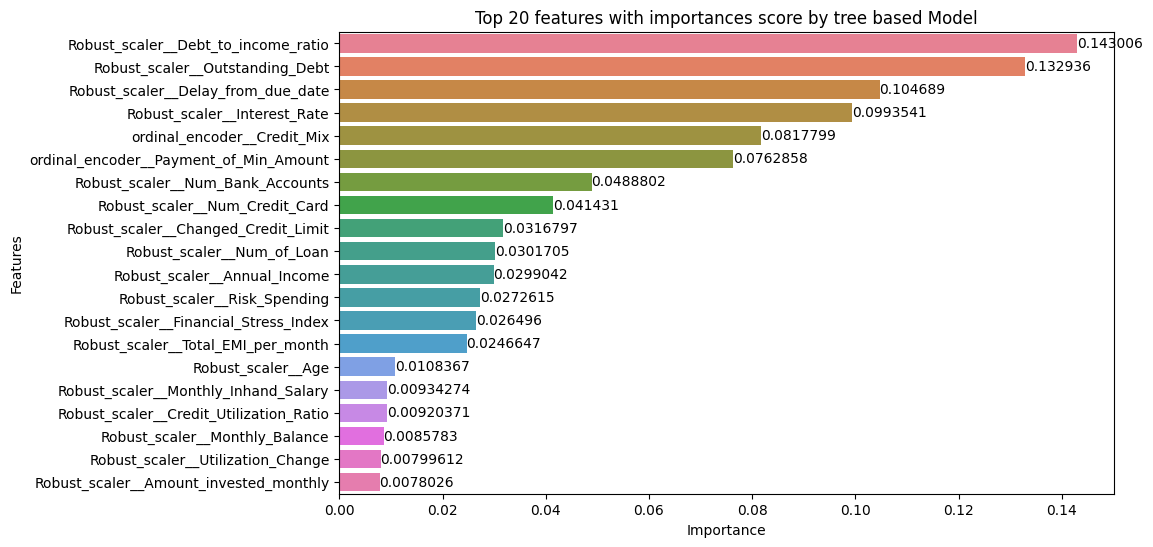

In [ ]:
top_20_features = feature_importances_df.nlargest(20, 'Importance')  #etxract the top 20 features with sort imporance score

#visualize the bar plot to check the feature importance level score
plt.figure(figsize=(10,6))
fig = sns.barplot(x='Importance',y='Features',data=top_20_features,palette='husl')


for bars in fig.containers:
  fig.bar_label(bars)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title("Top 20 features with importances score by tree based Model")
plt.show()


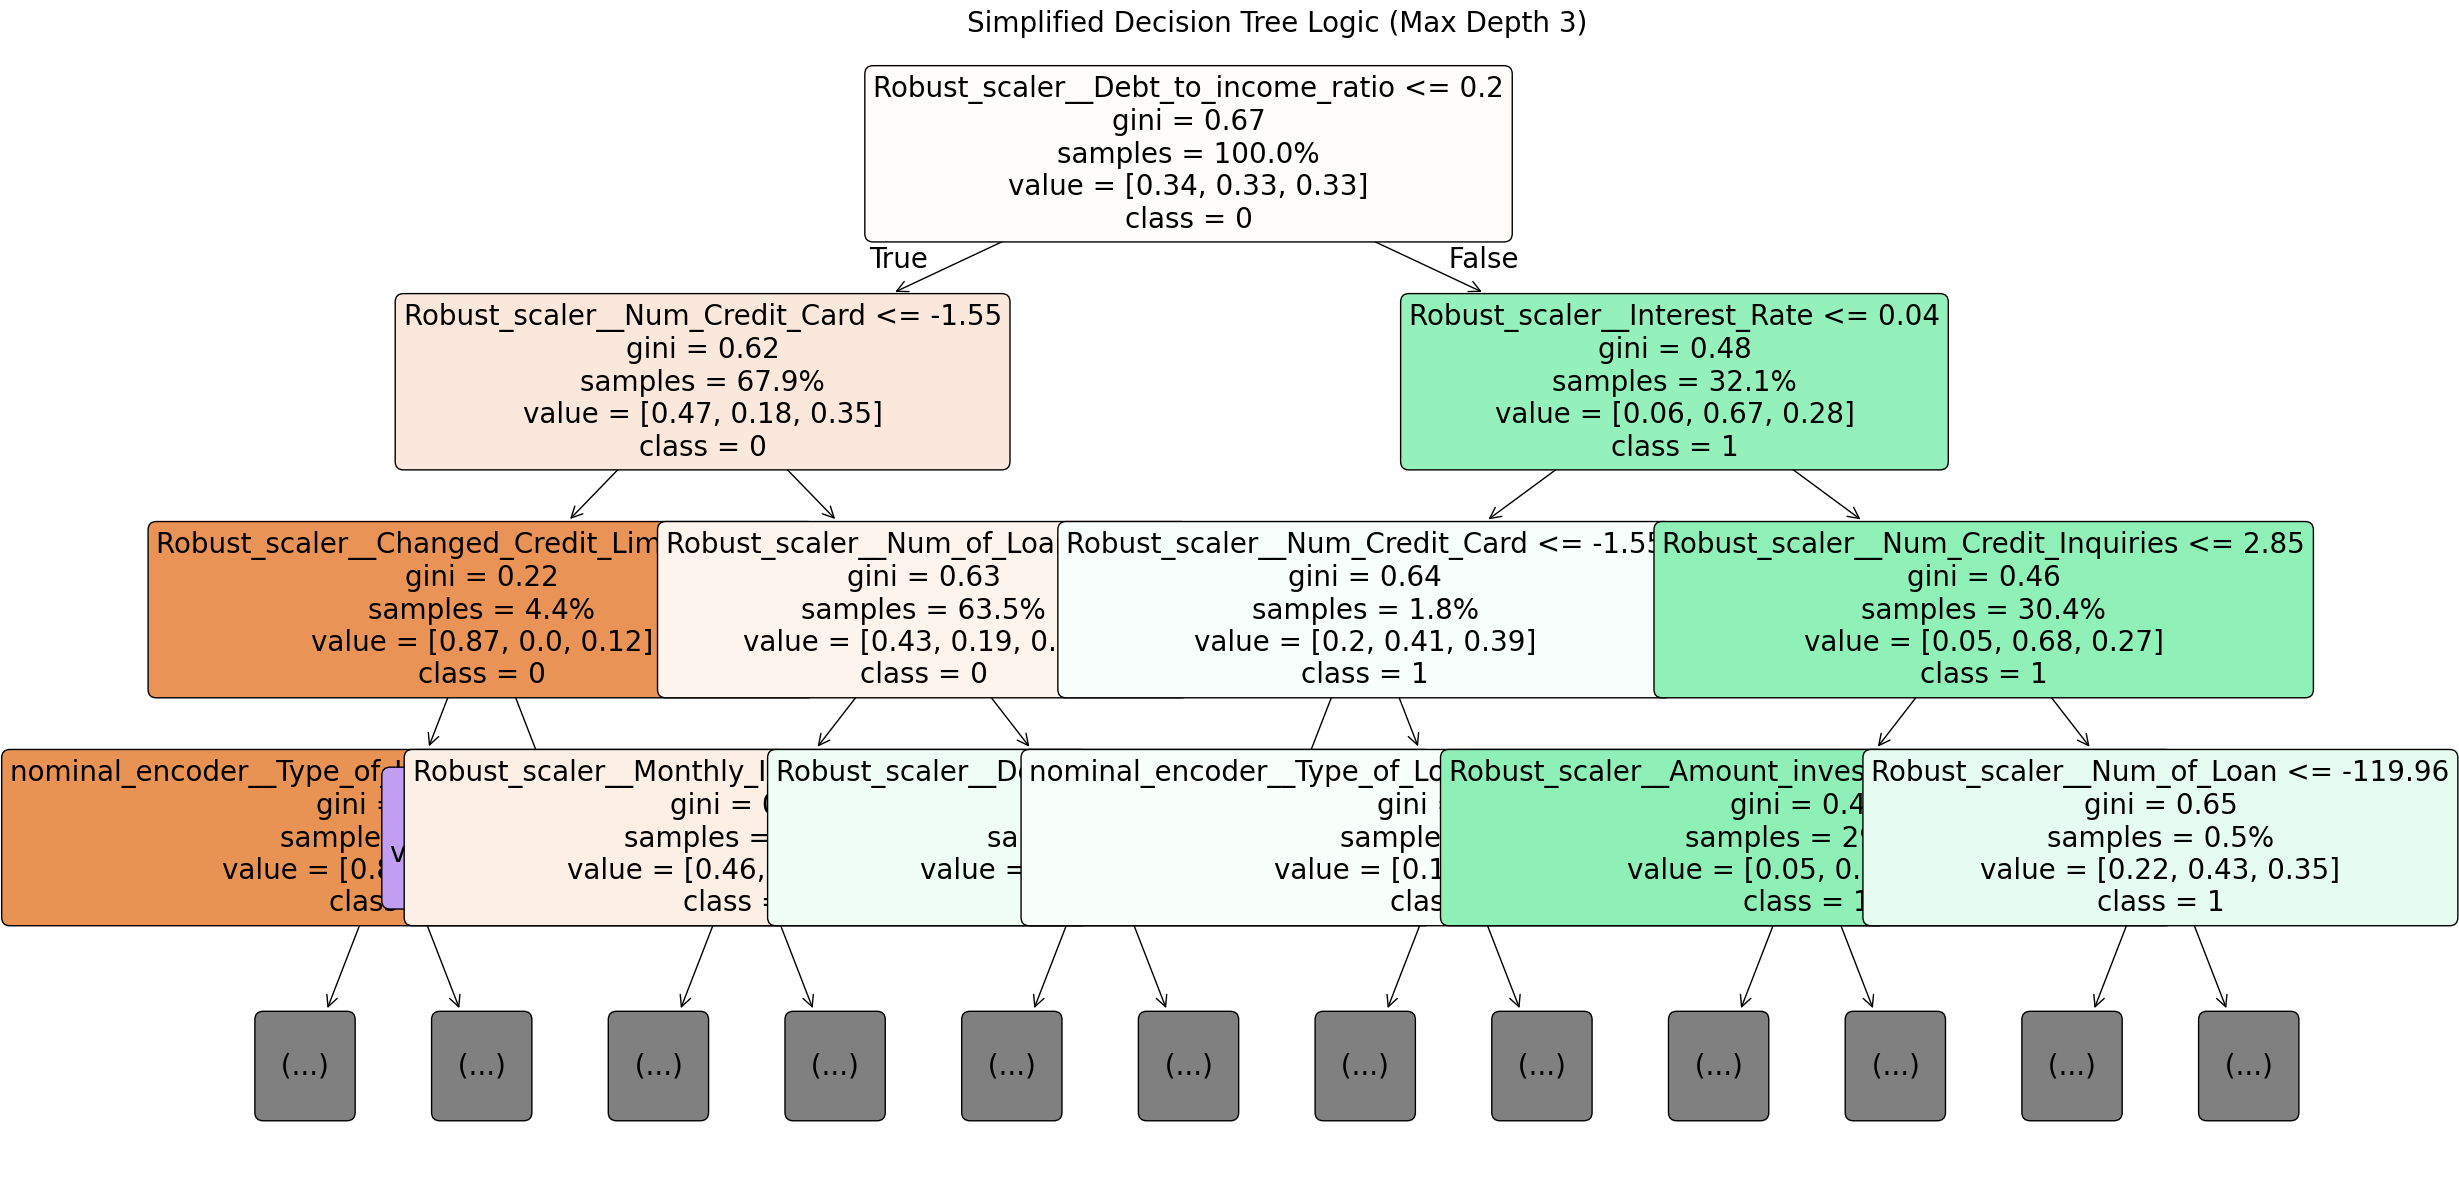

In [ ]:
from sklearn.tree import plot_tree

#fetch the random froest model from pipeline workflow
rf_model = rf_model_architecture.best_estimator_.named_steps['Baseline_Model']

#fetch the single decision tree from random forest which is combination for tree
decision_tree = rf_model.estimators_[0]

#plot the decision tree
plt.figure(figsize=(25, 12))

plot_tree(
    decision_tree,
    feature_names=preprocessor.get_feature_names_out(),
    max_depth=3,                     # select the max depth search for tree
    class_names=[str(cls) for cls in rf_model.classes_],
    filled=True,
    rounded=True,
    proportion=True,
    fontsize=20,
    precision=2
)

plt.title("Simplified Decision Tree Logic (Max Depth 3)", fontsize=20)
plt.tight_layout()
plt.show()

In [ ]:
rf_model_prediction = rf_model_architecture.predict(X_test)
# Call predict_proba method before subscripting its result
rf_model_prediction_probability = rf_model_architecture.predict_proba(X_test)[:,-1]

#create an dataframe based on prediction and actual prediction
df = pd.DataFrame(
    {
        'Actual_Label':y_test.values.flatten(),  #convert the 2d array into 1D array
        'Predicted_Label':rf_model_prediction,
        'Predicted_Probability':rf_model_prediction_probability
    }
)
df['Predicted_Label'].unique()

array([2, 1, 0])

In [ ]:
#setup the threshold values as top 20% for best features
threshold = 0.02

#look up the importnces features threhsold values
final_columns_selected = []

#apply the manipulation technique value
cols = feature_importances_df[feature_importances_df['Importance'] >= threshold]['Features']

#append the manipulated columns into final columns list
for col in cols:
  final_columns_selected.append(col)

final_columns_selected

['ordinal_encoder__Payment_of_Min_Amount',
 'ordinal_encoder__Credit_Mix',
 'Robust_scaler__Annual_Income',
 'Robust_scaler__Num_Bank_Accounts',
 'Robust_scaler__Num_Credit_Card',
 'Robust_scaler__Interest_Rate',
 'Robust_scaler__Num_of_Loan',
 'Robust_scaler__Delay_from_due_date',
 'Robust_scaler__Changed_Credit_Limit',
 'Robust_scaler__Outstanding_Debt',
 'Robust_scaler__Total_EMI_per_month',
 'Robust_scaler__Risk_Spending',
 'Robust_scaler__Financial_Stress_Index',
 'Robust_scaler__Debt_to_income_ratio']

In [ ]:
import re
from sklearn.preprocessing import OrdinalEncoder , OneHotEncoder
import pandas as pd
import numpy as np

# Correctly remove the prefixes with an empty string, not a space
cleaned_feature_names = [
    re.sub(r'^(Robust_scaler__|ordinal_encoder__)', '', col) for col in final_columns_selected
]

if 'Credit_Score' in cleaned_feature_names:
    cleaned_feature_names.remove('Credit_Score') # Remove if it somehow got in there, it's the target

# Now use these cleaned names to select columns from credit_score_df_unique
selected_features_df = credit_score_df_unique[cleaned_feature_names].copy() # Use .copy() to avoid SettingWithCopyWarning

#add the target variable in the columns
selected_features_df['Credit_Score'] = credit_score_df_unique['Credit_Score']


ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False) # sparse_output=False makes it return dense array
ohe_output = ohe.fit_transform(selected_features_df[['Payment_of_Min_Amount']])
ohe_feature_names = ohe.get_feature_names_out(['Payment_of_Min_Amount'])
ohe_df = pd.DataFrame(ohe_output, columns=ohe_feature_names, index=selected_features_df.index)

# Drop the original column and concatenate the new one-hot encoded columns
selected_features_df = selected_features_df.drop('Payment_of_Min_Amount', axis=1)
selected_features_df = pd.concat([selected_features_df, ohe_df], axis=1)


# 2. Ordinal encode 'Credit_Mix'
# OrdinalEncoder returns a 2D array, so flatten it for a single column assignment.
oe = OrdinalEncoder()
selected_features_df['Credit_Mix'] = oe.fit_transform(selected_features_df[['Credit_Mix']]).flatten()

#display the select

selected_features_df

Credit_Mix  Annual_Income  Num_Bank_Accounts  Num_Credit_Card  \
0             0.0       0.413881           1.162283         1.080418   
1             2.0       0.414454           1.124748         1.026672   
2             2.0       0.413905           1.124748         1.080418   
3             1.0       0.414463           0.869742         0.741276   
4             2.0       0.414706           1.026672         1.026672   
...           ...            ...                ...              ...   
12495         2.0       0.413463           1.124748         1.124748   
12496         0.0       0.413396           1.271150         1.124748   
12497         2.0       0.412700           1.223156         1.248441   
12498         2.0       0.413941           1.194706         1.248441   
12499         2.0       0.414085           1.223156         1.162283   

       Interest_Rate  Num_of_Loan  Delay_from_due_date  Changed_Credit_Limit  \
0           1.466077     1.730662             1.996468             -1.378444   
1           1.194706     1.732356             0.656808             -1.589510   
2           1.271150     1.732356            -0.260824              0.174251   
3           1.271150     1.728949            -0.504471             -0.652760   
4           1.080418     1.738947            -0.877133              0.260002   
...              ...          ...                  ...                   ...   
12495       1.248441     1.728949            -0.260824              0.388692   
12496       1.448822     1.735688             1.785465             -0.190037   
12497       1.358505     1.738947             1.034946              1.025287   
12498       1.385227     1.742137             1.828417              1.795163   
12499       1.291725     1.737326             0.296727              0.321185   

       Outstanding_Debt  Total_EMI_per_month  Risk_Spending  \
0              3.647477             1.539235       0.866366   
1              3.616779             2.007907       0.956945   
2              3.583621             1.551233       0.653358   
3              3.435330             1.574518       0.735194   
4              3.433883             1.923026       0.630370   
...                 ...                  ...            ...   
12495          2.921714             1.200918       0.604027   
12496          4.036776             1.598392       0.669069   
12497          3.951411             1.468487       0.558588   
12498          3.931742             1.785172       0.467536   
12499          3.677336             1.789287       0.641995   

       Financial_Stress_Index  Debt_to_income_ratio Credit_Score  \
0                    1.712373              8.812868         Poor   
1                    1.839543              8.726602         Good   
2                    1.990841              8.658073         Poor   
3                    1.906218              8.288633     Standard   
4                    1.693735              8.280279     Standard   
...                       ...                   ...          ...   
12495                1.385312              7.066441     Standard   
12496                2.020371              9.764914         Poor   
12497                2.053001              9.574538         Poor   
12498                1.899825              9.498309         Poor   
12499                1.812715              8.880624         Good   

       Payment_of_Min_Amount_NM  Payment_of_Min_Amount_No  \
0                           0.0                       0.0   
1                           0.0                       1.0   
2                           0.0                       1.0   
3                           0.0                       1.0   
4                           0.0                       0.0   
...                         ...                       ...   
12495                       0.0                       1.0   
12496                       0.0                       0.0   
12497                       0.0                       0.0 

In [ ]:
def encode_payment_min(df):
    # Combine first
    df['Payment_of_Min_Amount'] = df.apply(
        lambda row:
            'Yes' if row['Payment_of_Min_Amount_Yes'] == 1 else
            'No' if row['Payment_of_Min_Amount_No'] == 1 else
            'NM',
        axis=1
    )

    # Encode
    mapping = {'NM': 0, 'No': 1, 'Yes': 2}
    df['Payment_of_Min_Amount_Encoded'] = df['Payment_of_Min_Amount'].map(mapping)

    # Drop old columns after encoding
    df.drop(columns=[
        'Payment_of_Min_Amount_NM',
        'Payment_of_Min_Amount_No',
        'Payment_of_Min_Amount_Yes',
        'Payment_of_Min_Amount'
    ], inplace=True)

    return df

#call above function
selected_features_df = encode_payment_min(selected_features_df)
selected_features_df['Payment_Min_Amount_Encoded'].unique()


KeyError: 'Payment_Min_Amount_Encoded'

In [ ]:
baseline_classification_report = classification_report(y_test,rf_model_prediction)  #return the classification performance for baseline model
print(baseline_classification_report)

              precision    recall  f1-score   support

           0       0.43      0.74      0.54       724
           1       0.57      0.68      0.62      1081
           2       0.75      0.47      0.58      1945

    accuracy                           0.58      3750
   macro avg       0.58      0.63      0.58      3750
weighted avg       0.64      0.58      0.58      3750



In [ ]:
#store the baseline model into pickle file extension  along with paramaters in json parsing
import json

#Extract the best parameters from baseline model
baseline_parameters = rf_model_architecture.best_params_
baseline_score = cross_val_score(
    rf_model_architecture,
    X_train,
    y_train,
    cv=StratifiedKFold(n_splits=5),
    scoring='f1_macro'  #to check importance of minority class over majority class
)
baseline_classification_report = classification_report(y_test,rf_model_prediction,output_dict=True)  #return the classification performance
print(baseline_classification_report)

{'0': {'precision': 0.43121480289621883, 'recall': 0.7403314917127072, 'f1-score': 0.5449923741738688, 'support': 724.0}, '1': {'precision': 0.5678820791311094, 'recall': 0.6771507863089732, 'f1-score': 0.6177215189873417, 'support': 1081.0}, '2': {'precision': 0.7487684729064039, 'recall': 0.46889460154241647, 'f1-score': 0.5766677205184951, 'support': 1945.0}, 'accuracy': 0.5813333333333334, 'macro avg': {'precision': 0.5826217849779107, 'recall': 0.6287922931880323, 'f1-score': 0.5797938712265686, 'support': 3750.0}, 'weighted avg': {'precision': 0.6353159265708126, 'recall': 0.5813333333333334, 'f1-score': 0.5823867086228455, 'support': 3750.0}}


In [ ]:
baseline_classification_report

{'0': {'precision': 0.43121480289621883,
  'recall': 0.7403314917127072,
  'f1-score': 0.5449923741738688,
  'support': 724.0},
 '1': {'precision': 0.5678820791311094,
  'recall': 0.6771507863089732,
  'f1-score': 0.6177215189873417,
  'support': 1081.0},
 '2': {'precision': 0.7487684729064039,
  'recall': 0.46889460154241647,
  'f1-score': 0.5766677205184951,
  'support': 1945.0},
 'accuracy': 0.5813333333333334,
 'macro avg': {'precision': 0.5826217849779107,
  'recall': 0.6287922931880323,
  'f1-score': 0.5797938712265686,
  'support': 3750.0},
 'weighted avg': {'precision': 0.6353159265708126,
  'recall': 0.5813333333333334,
  'f1-score': 0.5823867086228455,
  'support': 3750.0}}

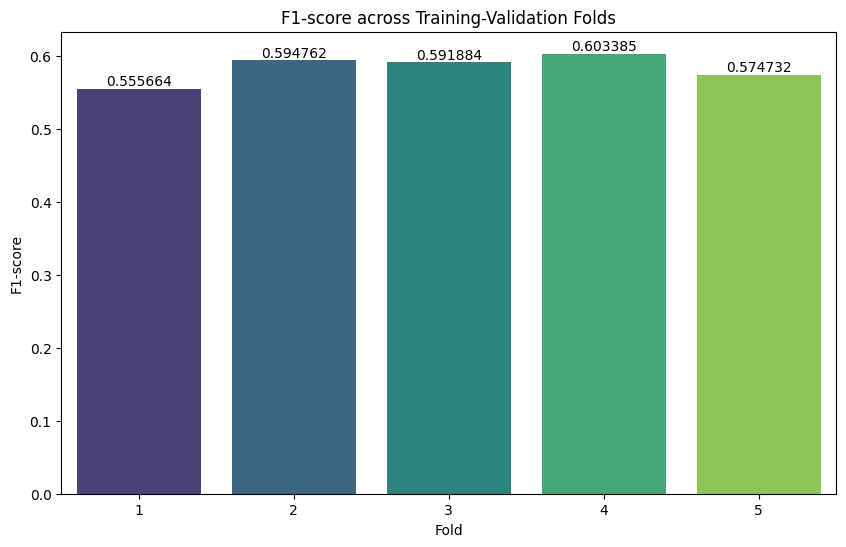

In [ ]:
#plot f1score accross each training validation fold
fold_list = ['1','2','3','4','5']

#plot bar graph to visualize the f1 score weight accross multiple training fols
plt.figure(figsize=(10,6))
fig = sns.barplot(
    x=fold_list,
    y=baseline_score,
    palette="viridis"
)

#add bar labels in figure
for bars in fig.containers:
  fig.bar_label(bars)  #add labels to figure
plt.xlabel("Fold")
plt.ylabel("F1-score")
plt.title("F1-score across Training-Validation Folds")
plt.show()

In [ ]:
#save the model with pickle file
file_mode = 'wb'
with open('baseline_model.pkl',file_mode) as file:
  joblib.dump(rf_model_architecture,file)


#store baseline model paramters
with open('baseline_model_parameters.json','w') as file:
  json.dump(baseline_parameters,file)


#store baseline model metrcis
with open('baseline_model_metrics.json','w') as file:
  json.dump(baseline_classification_report,file)

In [ ]:
baseline_score

#convert the baseline score into json
baseline_score_json = {
    'Baseline_Score':baseline_score.tolist()
}

with open('baseline_score.json','w') as file:
  json.dump(baseline_score_json,file)

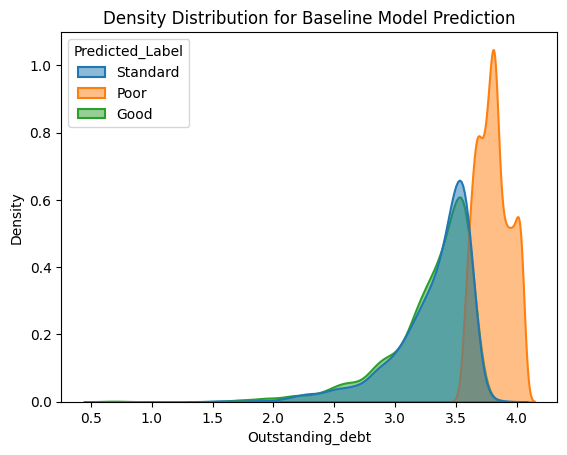

In [ ]:
df['Actual_Label'] = df['Actual_Label'].apply(lambda x:str(x))
df['Predicted_Label'] = df['Predicted_Label'].apply(lambda x:str(x))
label_reverse_map = {
    '0': 'Good',
    '1': 'Poor',
    '2': 'Standard'
}

df['Actual_Label'] = df['Actual_Label'].map(label_reverse_map)
df['Predicted_Label'] = df['Predicted_Label'].map(label_reverse_map)
df['Outstanding_debt'] = credit_score_df_unique['Outstanding_Debt'].iloc[X_test.index].values

#plot the predicted density over one strong feature
sns.kdeplot(data=df,x='Outstanding_debt',hue='Predicted_Label',fill=True,alpha=0.5,linewidth=1.5)
plt.title("Density Distribution for Baseline Model Prediction")
plt.savefig("predicted_Density.png")
plt.show()

Baseline Model classes like Standard and Good are overlapping each other to improve the performance for this Using Boosting model with class weight can be much effective

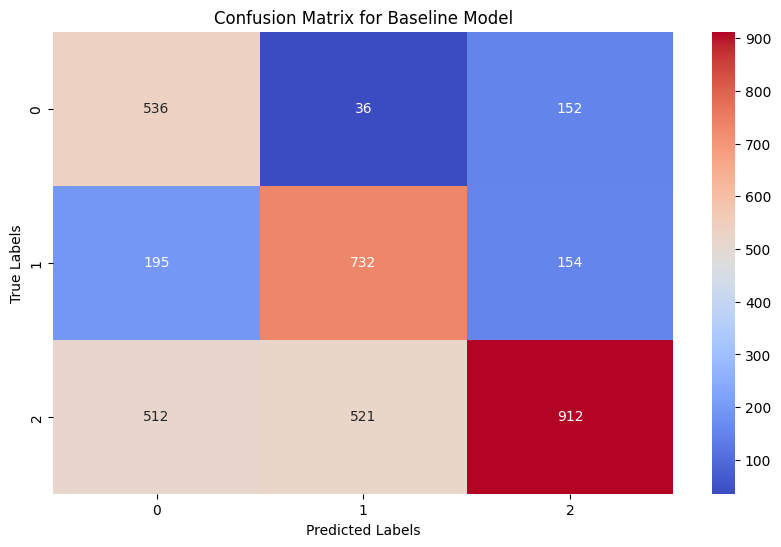

<Figure size 640x480 with 0 Axes>

In [ ]:
#plot the confusion matrix for baseline model
from sklearn.metrics import confusion_matrix

#calculate the confusion matrix over the bias and variance
cm = confusion_matrix(y_test,rf_model_prediction)

#plot the confusion matrix with heatmap
plt.figure(figsize=(10,6))
sns.heatmap(cm,annot=True,fmt='d',cmap="coolwarm",
             xticklabels=np.unique(y_test),
             yticklabels=np.unique(y_test))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Baseline Model')
plt.show()

#save this image for adding artifacts in mlflow
plt.savefig('Baseline_confusion_matrix.png')


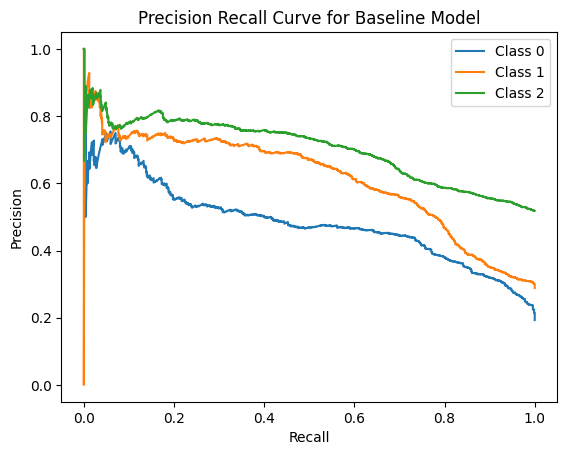

In [ ]:
#plot the precision and recall curve to check sgnificant impact of bias and variance

#calculate the precision and recall for each curve
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

#apply the One vs Rest approach to balance the tradeoff between each classes
y_test_binarized = label_binarize(y_test.values.flatten(), classes=np.unique(y_test.values.flatten()))

#predict the probabilitites for classes
rf_scores = rf_model_architecture.predict_proba(X_test)

#apply each classes precision and recall
for i, class_label in enumerate(np.unique(y_test.values.flatten())):

  #plot the precision and recall biase over the each class
  precision,recall,threshold = precision_recall_curve(y_test_binarized[:,i],rf_scores[:,i])
  plt.plot(recall,precision,label=f'Class {class_label}')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Precision Recall Curve for Baseline Model')
  plt.legend()

#save the image in colab storage
plt.savefig('Precision_Recall_Curve.png')
plt.show()

In [ ]:
#let see at which threhsold rf model gives best recall

best_threshold_precision = threshold[np.argmax(precision[:-1])]
best_threshold_recall = threshold[np.argmax(recall[:-1])]

print(f" Best threshold for Precision : {best_threshold_precision}")
print(f" Best threshold for Recall : {best_threshold_recall}")

 Best threshold for Precision : 0.5947229731735519
 Best threshold for Recall : 0.1624293805168018


LABELS INFO:

 prob_min         : Minimum probability in a particular decile
 prob_max         : Minimum probability in a particular decile
 prob_avg         : Average probability in a particular decile
 cnt_events       : Count of events in a particular decile
 cnt_resp         : Count of responders in a particular decile
 cnt_non_resp     : Count of non-responders in a particular decile
 cnt_resp_rndm    : Count of responders if events assigned randomly in a particular decile
 cnt_resp_wiz     : Count of best possible responders in a particular decile
 resp_rate        : Response Rate in a particular decile [(cnt_resp/cnt_cust)*100]
 cum_events       : Cumulative sum of events decile-wise 
 cum_resp         : Cumulative sum of responders decile-wise 
 cum_resp_wiz     : Cumulative sum of best possible responders decile-wise 
 cum_non_resp     : Cumulative sum of non-responders decile-wise 
 cum_events_pct   : Cumulative sum of percentages of events decile-wise 
 cum_resp_pct     : Cu

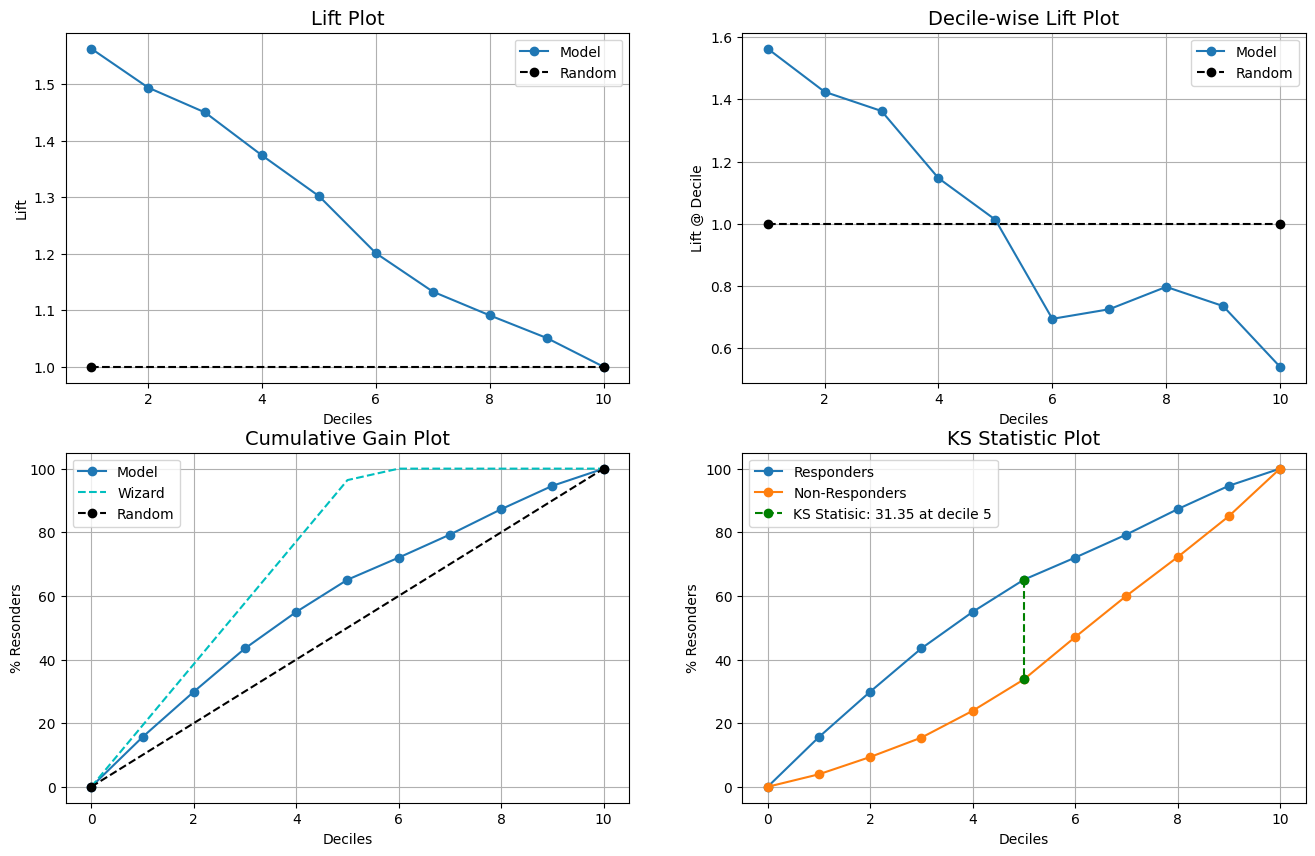

In [ ]:
import pandas as pd
import kds
from sklearn.preprocessing import label_binarize

# Suppose your model has 3 classes
class_of_interest = 2  #apply the One vs Rest appraoch  over best class learn by model

y_test_binarized = label_binarize(y_test, classes=[0,1,2])[:, class_of_interest]

# Predict probability for the same class
rf_model_prediction_proba = rf_model_architecture.predict_proba(X_test)[:, class_of_interest]  # 1D array

# Generate metrics report
kds.metrics.report(y_test_binarized, rf_model_prediction_proba)
plt.savefig('KDS_report.png')


In [ ]:
#find best class learn by baseline model and weakest class
#convert into integers
classification_report_rf = classification_report(
    y_test , rf_model_prediction , output_dict = True
)

#define an static tracking variable for finding best class
best_class = None
best_f1 = -1


#iterate throug each label
for labels in classification_report_rf:
  if labels not in ["accuracy","macro avg","weighted avg"]:
    f1_score = classification_report_rf[labels]['f1-score']  #calculate f1 score for each class
    if f1_score > best_f1:
      best_f1 = f1_score
      best_class = labels

print(f" Best Class learned by Randon forest : {best_class}")
print(f" Best Class F1 Accuracy : {best_f1}")


#find worst class for baseline model
worst_class = None
worst_f1 = 1  #maximum values for f1 score

#iterate through each labels in classification report
for labels in classification_report_rf:
  if labels not in ["accuracy","macro avg","weighted avg"]:
    f1_score = classification_report_rf[labels]['f1-score']
    if f1_score < worst_f1:
      worst_f1 = f1_score
      worst_class = labels

print(f" Worst Class learned by Randon forest : {worst_class}")
print(f" Worst Class F1 Accuracy : {worst_f1}")


 Best Class learned by Randon forest : 1
 Best Class F1 Accuracy : 0.6177215189873417
 Worst Class learned by Randon forest : 0
 Worst Class F1 Accuracy : 0.5449923741738688


In [ ]:
selected_features_df.columns

Index(['Credit_Mix', 'Annual_Income', 'Num_Bank_Accounts', 'Num_Credit_Card',
       'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date',
       'Changed_Credit_Limit', 'Outstanding_Debt', 'Total_EMI_per_month',
       'Risk_Spending', 'Financial_Stress_Index', 'Debt_to_income_ratio',
       'Credit_Score', 'Payment_of_Min_Amount_Encoded'],
      dtype='object')

In [ ]:
#labelize the Target Function with corresponding value
from sklearn.preprocessing import OneHotEncoder , LabelEncoder

label_encoder = LabelEncoder()

selected_features_df['Credit_Score'] = label_encoder.fit_transform(
     selected_features_df[['Credit_Score']] )

selected_features_df

Credit_Mix  Annual_Income  Num_Bank_Accounts  Num_Credit_Card  \
0             0.0       0.413881           1.162283         1.080418   
1             2.0       0.414454           1.124748         1.026672   
2             2.0       0.413905           1.124748         1.080418   
3             1.0       0.414463           0.869742         0.741276   
4             2.0       0.414706           1.026672         1.026672   
...           ...            ...                ...              ...   
12495         2.0       0.413463           1.124748         1.124748   
12496         0.0       0.413396           1.271150         1.124748   
12497         2.0       0.412700           1.223156         1.248441   
12498         2.0       0.413941           1.194706         1.248441   
12499         2.0       0.414085           1.223156         1.162283   

       Interest_Rate  Num_of_Loan  Delay_from_due_date  Changed_Credit_Limit  \
0           1.466077     1.730662             1.996468             -1.378444   
1           1.194706     1.732356             0.656808             -1.589510   
2           1.271150     1.732356            -0.260824              0.174251   
3           1.271150     1.728949            -0.504471             -0.652760   
4           1.080418     1.738947            -0.877133              0.260002   
...              ...          ...                  ...                   ...   
12495       1.248441     1.728949            -0.260824              0.388692   
12496       1.448822     1.735688             1.785465             -0.190037   
12497       1.358505     1.738947             1.034946              1.025287   
12498       1.385227     1.742137             1.828417              1.795163   
12499       1.291725     1.737326             0.296727              0.321185   

       Outstanding_Debt  Total_EMI_per_month  Risk_Spending  \
0              3.647477             1.539235       0.866366   
1              3.616779             2.007907       0.956945   
2              3.583621             1.551233       0.653358   
3              3.435330             1.574518       0.735194   
4              3.433883             1.923026       0.630370   
...                 ...                  ...            ...   
12495          2.921714             1.200918       0.604027   
12496          4.036776             1.598392       0.669069   
12497          3.951411             1.468487       0.558588   
12498          3.931742             1.785172       0.467536   
12499          3.677336             1.789287       0.641995   

       Financial_Stress_Index  Debt_to_income_ratio  Credit_Score  \
0                    1.712373              8.812868             1   
1                    1.839543              8.726602             0   
2                    1.990841              8.658073             1   
3                    1.906218              8.288633             2   
4                    1.693735              8.280279             2   
...                       ...                   ...           ...   
12495                1.385312              7.066441             2   
12496                2.020371              9.764914             1   
12497                2.053001              9.574538             1   
12498                1.899825              9.498309             1   
12499                1.812715              8.880624             0   

       Payment_of_Min_Amount_Encoded  
0                                  2  
1                                  1  
2                                  1  
3                                  1  
4                                  2  
...                              ...  
12495                              1  
12496                              2  
12497                              2  
12498                              2  
12499                              2  

[12500 rows x 15 columns]

In [ ]:
#once again call train test function for splitting newly featuress
final_input_var = selected_features_df.drop('Credit_Score',axis=1)
final_output_var = selected_features_df['Credit_Score']


In [ ]:
#call feature splitting function to feature splitter variable
feature_splitter_func = Feature_splitting(final_input_var,final_output_var,selected_features_df)
new_X_train,new_X_test,new_y_train,new_y_test = feature_splitter_func.split_features()

print(new_X_train.shape)
print(new_X_test.shape)
print(new_y_train.shape)
print(new_y_test.shape)

(8750, 14)
(3750, 14)
(8750,)
(3750,)


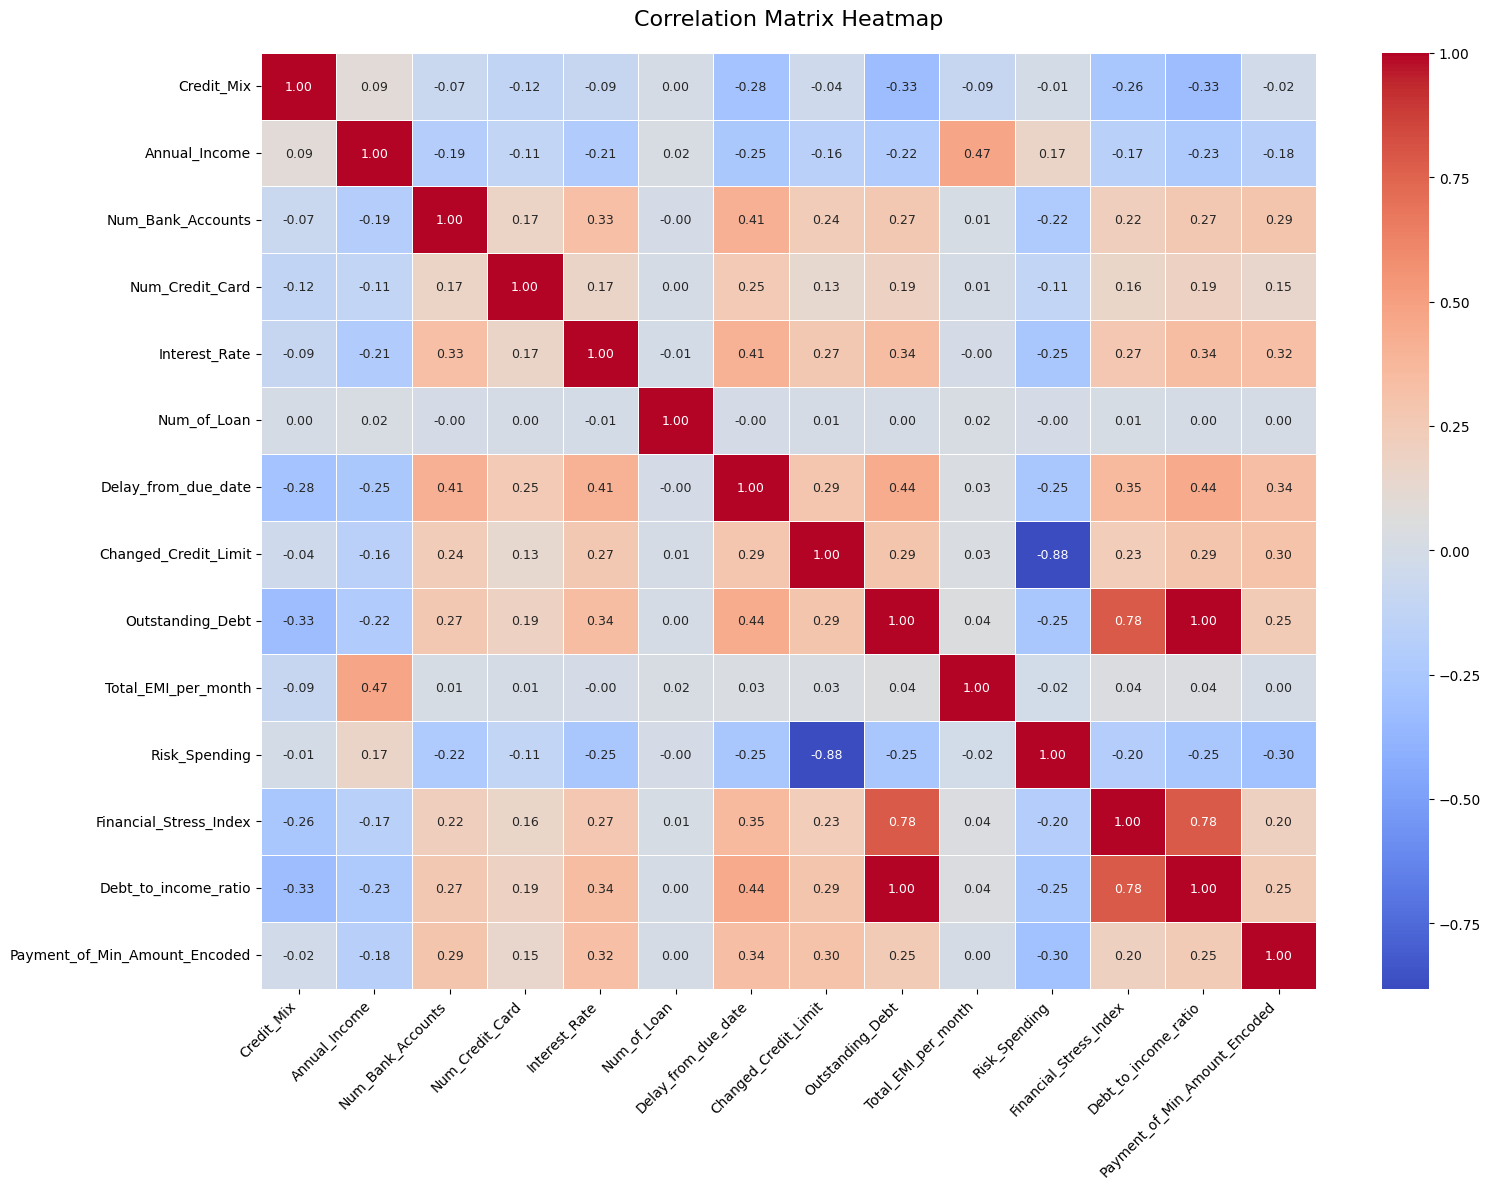

In [ ]:
#plot the correlation matrxi plot between each columns to check the multicollinearity
corr_matrix = new_X_train.corr()

#plot the heatmap visualization
plt.figure(figsize=(16, 12))   # Bigger + clearer

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
    annot_kws={"size": 9}       # bigger annotation text
)

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)

plt.title("Correlation Matrix Heatmap", fontsize=16, pad=20)

plt.tight_layout()             # removes cut-off labels
plt.show()


In [ ]:
corr_matrix

Credit_Mix  Annual_Income  Num_Bank_Accounts  \
Credit_Mix                       1.000000       0.089162          -0.067826   
Annual_Income                    0.089162       1.000000          -0.191429   
Num_Bank_Accounts               -0.067826      -0.191429           1.000000   
Num_Credit_Card                 -0.119863      -0.109590           0.170410   
Interest_Rate                   -0.094466      -0.214498           0.329225   
Num_of_Loan                      0.003728       0.017818          -0.002868   
Delay_from_due_date             -0.282603      -0.248432           0.412954   
Changed_Credit_Limit            -0.037014      -0.163343           0.239441   
Outstanding_Debt                -0.325814      -0.219086           0.267434   
Total_EMI_per_month             -0.092921       0.471627           0.013904   
Risk_Spending                   -0.011661       0.169055          -0.224139   
Financial_Stress_Index          -0.258551      -0.174862           0.219411   
Debt_to_income_ratio            -0.326175      -0.231440           0.269160   
Payment_of_Min_Amount_Encoded   -0.022918      -0.178168           0.291214   

                               Num_Credit_Card  Interest_Rate  Num_of_Loan  \
Credit_Mix                           -0.119863      -0.094466     0.003728   
Annual_Income                        -0.109590      -0.214498     0.017818   
Num_Bank_Accounts                     0.170410       0.329225    -0.002868   
Num_Credit_Card                       1.000000       0.168955     0.003368   
Interest_Rate                         0.168955       1.000000    -0.010172   
Num_of_Loan                           0.003368      -0.010172     1.000000   
Delay_from_due_date                   0.251067       0.410772    -0.002603   
Changed_Credit_Limit                  0.126236       0.270750     0.006428   
Outstanding_Debt                      0.192101       0.341873     0.003043   
Total_EMI_per_month                   0.005432      -0.003704     0.016503   
Risk_Spending                        -0.109922      -0.251155    -0.000849   
Financial_Stress_Index                0.160958       0.274011     0.010025   
Debt_to_income_ratio                  0.192984       0.343702     0.002823   
Payment_of_Min_Amount_Encoded         0.145718       0.324739     0.001759   

                               Delay_from_due_date  Changed_Credit_Limit  \
Credit_Mix                               -0.282603             -0.037014   
Annual_Income                            -0.248432             -0.163343   
Num_Bank_Accounts                         0.412954              0.239441   
Num_Credit_Card                           0.251067              0.126236   
Interest_Rate                             0.410772              0.270750   
Num_of_Loan                              -0.002603              0.006428   
Delay_from_due_date                       1.000000              0.285084   
Changed_Credit_Limit                      0.285084              1.000000   
Outstanding_Debt                          0.441275              0.292834   
Total_EMI_per_month                       0.030562              0.032611   
Risk_Spending                            -0.252706             -0.881155   
Financial_Stress_Index                    0.354004              0.234963   
Debt_to_income_ratio                      0.443280              0.294175   
Payment_of_Min_Amount_Encoded             0.336915              0.302359   

                               Outstanding_Debt  Total_EMI_per_month  \
Credit_Mix                            -0.325814            -0.092921   
Annual_Income                         -0.219086             0.471627   
Num_Bank_Accounts                      0.267434             0.013904   
Num_Credit_Card                        0.192101             0.005432   
Interest_Rate                          0.341873            -0.003704   
Num_of_Loan                            0.003043             0.016503   
Delay_from_due_date          

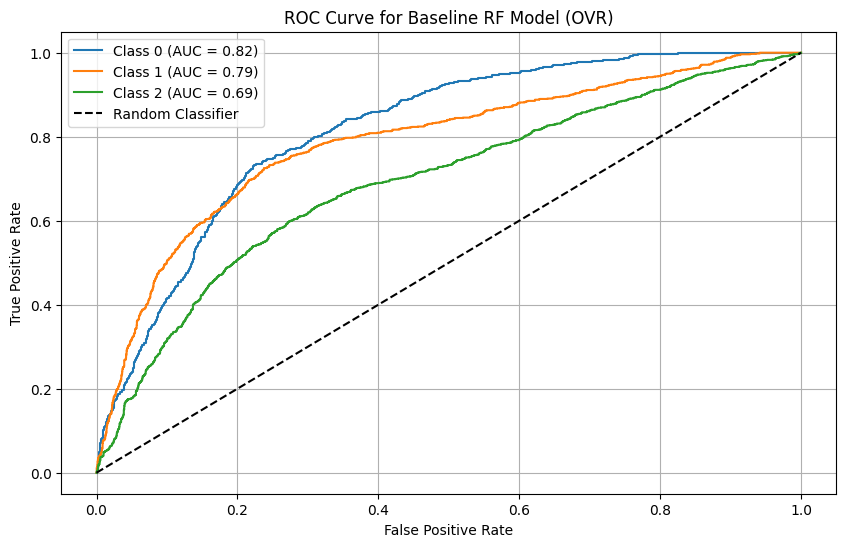

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np


rf_scores = rf_model_architecture.predict_proba(X_test)
y_test_binarized = label_binarize(y_test.values.flatten(), classes=np.unique(y_test.values.flatten()))

plt.figure(figsize=(10, 6))

# Iterate through each class for OVR
for i, class_label in enumerate(np.unique(y_test.values.flatten())):

    # Compute FPR, TPR, Thresholds
    fpr, tpr, thresholds = roc_curve(
        y_test_binarized[:, i],
        rf_scores[:, i]
    )

    # Compute AUC score
    auc_score = roc_auc_score(
        y_test_binarized[:, i],
        rf_scores[:, i]
    )

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'Class {class_label} (AUC = {auc_score:.2f})')

# Plot formatting
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Baseline RF Model (OVR)')
plt.legend()

plt.grid(True)
plt.show()

# Training AI Algorithms

From above Correlation Matrix conclusion can be made that Due to Non linear relationship between features can lead to Poor Performance
Experiment with Some Boosting Algorithm with learning Convergence

1. Adaptive Boosting Algorithm - Might work best for Weak Leaner as assign weights
2. XGBOOST/CATBoost/LightGBM
3. Aritificial Neural network

Combine Boosting algorithm with Stacking classifier

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#apply dict weights for each class to imporve recall over the newly features select y_train
num_of_unique_class = np.unique(new_y_train)
class_weights = compute_class_weight(
    class_weight='balanced',  #keep all weights as balanced for each class
    classes=num_of_unique_class,  #extract the unique class in list
    y=new_y_train  #apply with reference to y train
)

#display class weights for each class after balancing
print(f" Class weights assigned to Good Category : {class_weights[0]}")
print(f" Class weights assigned to Standard Category : {class_weights[1]}")
print(f" Class weights assigned to Poor Category : {class_weights[2]}")


 Class weights assigned to Good Category : 1.7268600749950662
 Class weights assigned to Standard Category : 1.1569483009387809
 Class weights assigned to Poor Category : 0.6424375917767988


In [ ]:
#apply this class weights sample to y train columns and y test columns
class_weights_dict = {
    0:class_weights[0],
    1:class_weights[1],
    2:class_weights[2]
}

#apply ths sample weights
sample_weights = [class_weights_dict[label] for label in new_y_train]
sample_weights #sample weights assigned to each class based on weights assigned by each class by balancing the recall for good class category

[np.float64(0.6424375917767988),
 np.float64(1.7268600749950662),
 np.float64(0.6424375917767988),
 np.float64(1.7268600749950662),
 np.float64(1.1569483009387809),
 np.float64(1.1569483009387809),
 np.float64(0.6424375917767988),
 np.float64(1.1569483009387809),
 np.float64(0.6424375917767988),
 np.float64(0.6424375917767988),
 np.float64(0.6424375917767988),
 np.float64(0.6424375917767988),
 np.float64(1.1569483009387809),
 np.float64(0.6424375917767988),
 np.float64(1.1569483009387809),
 np.float64(0.6424375917767988),
 np.float64(0.6424375917767988),
 np.float64(0.6424375917767988),
 np.float64(1.1569483009387809),
 np.float64(1.7268600749950662),
 np.float64(0.6424375917767988),
 np.float64(0.6424375917767988),
 np.float64(0.6424375917767988),
 np.float64(1.7268600749950662),
 np.float64(0.6424375917767988),
 np.float64(1.7268600749950662),
 np.float64(1.1569483009387809),
 np.float64(0.6424375917767988),
 np.float64(1.1569483009387809),
 np.float64(1.1569483009387809),
 np.float6

In [ ]:
new_X_train.columns

Index(['Credit_Mix', 'Annual_Income', 'Num_Bank_Accounts', 'Num_Credit_Card',
       'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date',
       'Changed_Credit_Limit', 'Outstanding_Debt', 'Total_EMI_per_month',
       'Risk_Spending', 'Financial_Stress_Index', 'Debt_to_income_ratio',
       'Payment_of_Min_Amount_Encoded'],
      dtype='object')

In [ ]:
new_X_train['Num_Bank_Accounts']

4254     1.124748
666      0.741276
5323     0.959135
3662     1.080418
1839     1.124748
           ...   
5300     1.194706
8443     1.162283
12028    1.248441
8278     1.271150
10792    1.026672
Name: Num_Bank_Accounts, Length: 8750, dtype: float64

In [ ]:
class_weights

array([1.72686007, 1.1569483 , 0.64243759])

In [ ]:
new_X_train.columns

Index(['Credit_Mix', 'Annual_Income', 'Num_Bank_Accounts', 'Num_Credit_Card',
       'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date',
       'Changed_Credit_Limit', 'Outstanding_Debt', 'Total_EMI_per_month',
       'Risk_Spending', 'Financial_Stress_Index', 'Debt_to_income_ratio',
       'Payment_of_Min_Amount_Encoded'],
      dtype='object')

In [ ]:
#create an preprocessing workflow for XGBOOST Algorithm
from sklearn.preprocessing import StandardScaler , RobustScaler

# Ensure all columns from new_X_train are accounted for in the preprocessor
# Identify which columns from new_X_train are currently not in any list
all_new_X_train_cols = new_X_train.columns.tolist()

numeric_count_features = [
  "Credit_Mix",
 "Num_Bank_Accounts",
 "Num_Credit_Card",
 "Num_of_Loan",
 "Delay_from_due_date",
"Credit_History_Year",
  "Total_EMI_per_month",
  "Amount_invested_monthly",
  "Monthly_Balance",
 "Payment_of_Min_Amount_Encoded"]


# This list should ideally cover the remaining columns. Let's rebuild it to be explicit.
continuous_float_features = [
    "Age",
    "Annual_Income",
    "Interest_Rate",
    "Changed_Credit_Limit",
    "Outstanding_Debt",
    "Credit_Utilization_Ratio",
    "Total_EMI_per_month",
    "Utilization_Change",
    "Risk_Spending",
    "Financial_Stress_Index",
    "Debt_to_income_ratio"
]

# Verify that all columns in new_X_train are covered
all_covered_features = set(numeric_count_features + continuous_float_features)
missing_from_preprocessor = [col for col in all_new_X_train_cols if col not in all_covered_features]

if missing_from_preprocessor:
    print(f"Warning: The following columns from new_X_train are not covered by the preprocessor: {missing_from_preprocessor}")
    # Add them to a scaling group, e.g., continuous_float_features
    continuous_float_features.extend(missing_from_preprocessor)


#create transformation function for XGboost model
Xgboost_preprocessor = ColumnTransformer(
    transformers=[],   #do not pass preprocessing in pipeline for maintaining orderness of values
    remainder='passthrough' # Make Columns as static
)
Xgboost_preprocessor

ColumnTransformer(remainder='passthrough', transformers=[])

In [ ]:
new_X_train.columns

Index(['Credit_Mix', 'Annual_Income', 'Num_Bank_Accounts', 'Num_Credit_Card',
       'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date',
       'Changed_Credit_Limit', 'Outstanding_Debt', 'Total_EMI_per_month',
       'Risk_Spending', 'Financial_Stress_Index', 'Debt_to_income_ratio',
       'Payment_of_Min_Amount_Encoded'],
      dtype='object')

In [ ]:
new_X_train.columns

Index(['Credit_Mix', 'Annual_Income', 'Num_Bank_Accounts', 'Num_Credit_Card',
       'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date',
       'Changed_Credit_Limit', 'Outstanding_Debt', 'Total_EMI_per_month',
       'Risk_Spending', 'Financial_Stress_Index', 'Debt_to_income_ratio',
       'Payment_of_Min_Amount_Encoded'],
      dtype='object')

In [ ]:
print(Xgboost_preprocessor)

ColumnTransformer(remainder='passthrough', transformers=[])


In [ ]:
#check for GPU available for Highly Gradient Boosting Optimization
import torch


#check for availability of GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    print("GPU is not available")

GPU is not available


In [ ]:
new_weights_dict  = {
    0:1.8,
    1:1.2,
    2:0.7}
new_sample_weights = [
    new_weights_dict[label] for label in new_y_train
]
print(new_sample_weights)



[0.7, 1.8, 0.7, 1.8, 1.2, 1.2, 0.7, 1.2, 0.7, 0.7, 0.7, 0.7, 1.2, 0.7, 1.2, 0.7, 0.7, 0.7, 1.2, 1.8, 0.7, 0.7, 0.7, 1.8, 0.7, 1.8, 1.2, 0.7, 1.2, 1.2, 1.8, 0.7, 1.8, 0.7, 0.7, 0.7, 0.7, 1.2, 0.7, 0.7, 1.2, 1.2, 0.7, 0.7, 1.2, 0.7, 1.2, 1.2, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 1.8, 0.7, 1.2, 0.7, 1.2, 1.2, 1.2, 0.7, 0.7, 1.8, 0.7, 1.2, 1.8, 0.7, 0.7, 0.7, 0.7, 1.2, 1.8, 1.2, 1.8, 1.2, 1.2, 1.8, 1.8, 0.7, 1.2, 1.8, 1.8, 0.7, 0.7, 0.7, 1.2, 0.7, 0.7, 1.8, 0.7, 0.7, 1.2, 0.7, 0.7, 0.7, 1.2, 0.7, 1.2, 0.7, 0.7, 0.7, 1.8, 1.2, 0.7, 1.8, 1.8, 0.7, 0.7, 0.7, 1.2, 0.7, 0.7, 0.7, 1.8, 0.7, 1.8, 1.8, 0.7, 1.2, 0.7, 1.2, 0.7, 0.7, 1.2, 1.8, 0.7, 0.7, 0.7, 1.8, 1.2, 0.7, 1.2, 0.7, 1.2, 1.2, 0.7, 1.2, 1.2, 1.2, 1.2, 1.8, 1.2, 0.7, 1.2, 1.8, 0.7, 1.8, 1.8, 1.2, 0.7, 0.7, 1.8, 1.2, 1.2, 1.2, 0.7, 0.7, 1.8, 0.7, 0.7, 1.8, 1.8, 1.2, 1.2, 1.8, 1.2, 0.7, 1.8, 1.8, 0.7, 1.2, 0.7, 0.7, 1.2, 0.7, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 0.7, 0.7, 1.2, 0.7, 1.2, 1.2, 0.7, 0.7, 0.7, 1.2, 1.8, 0.7, 1.2, 0.7, 1.2, 0.7, 0.7, 1.8,

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline


class XGboost:

    def __init__(self, X_train, y_train, X_test, y_test, preprocessor, class_weights_array):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.random_state = 42
        self.num_class = 3
        self.enable_categorical=True
        self.model = XGBClassifier(
            random_state=self.random_state,
            objective="multi:softprob",
            num_class=self.num_class,
            eval_metric="mlogloss",
            n_jobs=-1,
            tree_method='hist',  # faster CPU histogram
            enable_categorical=self.enable_categorical
        )
        self.preprocessor = preprocessor
        self.weights_array = class_weights_array

    def create_pipeline(self):
        steps = [
            ('preprocessing', self.preprocessor),
            ('model', self.model)
        ]
        return Pipeline(steps)

    def hyperparameter_search(self, pipeline):
        param_grid = {
            'model__booster': ['gbtree'],
            'model__n_estimators': [100, 200, 300],  # smaller for faster search
            'model__learning_rate': [0.05, 0.1],
            'model__max_depth': [3, 4, 5],
            'model__min_child_weight': [1, 2],
            'model__gamma': [0, 0.1],
            'model__reg_alpha': [0, 0.05],
            'model__reg_lambda': [1, 1.5],
            'model__subsample': [0.8, 0.9],
            'model__colsample_bytree': [0.8, 0.9]
        }

        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=self.random_state)

        return RandomizedSearchCV(
            estimator=pipeline,
            param_distributions=param_grid,
            scoring='f1_macro',
            n_iter=10,
            cv=cv,
            n_jobs=1, #utilize job scheduling for faster trainin process
            verbose=2
        )

    def train_model(self, search_model):
        fit_params = {
            'model__sample_weight': self.weights_array,  #assign weights to each class for improving
        }

        return search_model.fit(self.X_train, self.y_train, **fit_params)  #adjust parameters over sample weights


# Usage
xgb_arch = XGboost(new_X_train ,new_y_train, new_X_test ,new_y_test, Xgboost_preprocessor, new_sample_weights)
pipeline = xgb_arch.create_pipeline()
search_model = xgb_arch.hyperparameter_search(pipeline)
trained_model = xgb_arch.train_model(search_model)

#validate if model is trained over each loop iteration
if trained_model.best_estimator_ is not None:
    print("XGboost Training Status : Success")
else:
    print("Xgboost Training Status : Failed")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END model__booster=gbtree, model__colsample_bytree=0.8, model__gamma=0.1, model__learning_rate=0.1, model__max_depth=5, model__min_child_weight=2, model__n_estimators=100, model__reg_alpha=0.05, model__reg_lambda=1, model__subsample=0.8; total time=   0.7s
[CV] END model__booster=gbtree, model__colsample_bytree=0.8, model__gamma=0.1, model__learning_rate=0.1, model__max_depth=5, model__min_child_weight=2, model__n_estimators=100, model__reg_alpha=0.05, model__reg_lambda=1, model__subsample=0.8; total time=   0.6s
[CV] END model__booster=gbtree, model__colsample_bytree=0.8, model__gamma=0.1, model__learning_rate=0.1, model__max_depth=5, model__min_child_weight=2, model__n_estimators=100, model__reg_alpha=0.05, model__reg_lambda=1, model__subsample=0.8; total time=   0.7s
[CV] END model__booster=gbtree, model__colsample_bytree=0.8, model__gamma=0.1, model__learning_rate=0.1, model__max_depth=5, model__min_child_weight=2, m

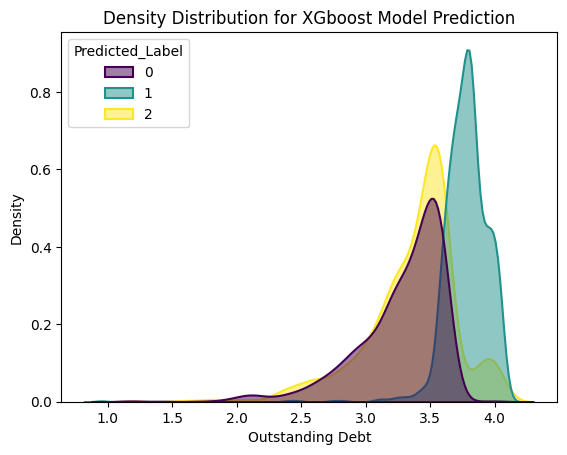

In [ ]:
#predict the credit score based on multi class probabilities
xgb_model_prediction = trained_model.predict(new_X_test)  #predict the result of credit score

#predict the probability for XGboost model
xgb_model_prediction_prob = trained_model.predict_proba(new_X_test)[:,-1]
xgb_model_prediction_prob

#conver the reuslts into dataframe
xgb_model_result_df = pd.DataFrame({
    'Actual_Label':new_y_test,
    'Predicted_Label':xgb_model_prediction,
    'Predicted_Probability':xgb_model_prediction_prob,
    'Outstanding_debt':new_X_test['Outstanding_Debt'].values
})

#visualize the overalapping structure fo misclassified points ove rstrong features
sns.kdeplot(data=xgb_model_result_df,x='Outstanding_debt',hue='Predicted_Label',fill=True,alpha=0.5,linewidth=1.5,
            palette='viridis')
plt.title("Density Distribution for XGboost Model Prediction")
plt.xlabel("Outstanding Debt")
plt.ylabel("Density")
plt.savefig("XGboost_predicted_Density.png")
plt.show()

In [ ]:
#evaluate the classification metics for XGboost classification report
import json

#generate metrics and evaluation result for xgboost model deploying in databricks
xgboost_classification_result = classification_report(new_y_test,xgb_model_prediction,output_dict=True)

#apply cross validation across each set to get best f1 score
cv_scores = cross_val_score(trained_model,new_X_train,new_y_train,cv=5,scoring='f1_macro')

#store cv score in dict
cv_scores_dict = {
    'cv_scores':cv_scores
}

cv_scores_dict

#extract best metrics and paramters from trained xgboost model
best_params = trained_model.best_params_


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END model__booster=gbtree, model__colsample_bytree=0.8, model__gamma=0.1, model__learning_rate=0.1, model__max_depth=3, model__min_child_weight=1, model__n_estimators=300, model__reg_alpha=0, model__reg_lambda=1, model__subsample=0.8; total time=   0.8s
[CV] END model__booster=gbtree, model__colsample_bytree=0.8, model__gamma=0.1, model__learning_rate=0.1, model__max_depth=3, model__min_child_weight=1, model__n_estimators=300, model__reg_alpha=0, model__reg_lambda=1, model__subsample=0.8; total time=   0.8s
[CV] END model__booster=gbtree, model__colsample_bytree=0.8, model__gamma=0.1, model__learning_rate=0.1, model__max_depth=3, model__min_child_weight=1, model__n_estimators=300, model__reg_alpha=0, model__reg_lambda=1, model__subsample=0.8; total time=   0.8s
[CV] END model__booster=gbtree, model__colsample_bytree=0.8, model__gamma=0.1, model__learning_rate=0.1, model__max_depth=3, model__min_child_weight=1, model__n_e

In [ ]:
print(f" XGBOOST Classification Result (F1-score for each Class) : {xgboost_classification_result}")

 XGBOOST Classification Result (F1-score for each Class) : {'0': {'precision': 0.45955555555555555, 'recall': 0.7140883977900553, 'f1-score': 0.5592212006489995, 'support': 724.0}, '1': {'precision': 0.6069651741293532, 'recall': 0.6771507863089732, 'f1-score': 0.640139921294272, 'support': 1081.0}, '2': {'precision': 0.7223396758280479, 'recall': 0.5269922879177378, 'f1-score': 0.6093935790725327, 'support': 1945.0}, 'accuracy': 0.6064, 'macro avg': {'precision': 0.5962868018376523, 'recall': 0.6394104906722554, 'f1-score': 0.6029182336719348, 'support': 3750.0}, 'weighted avg': {'precision': 0.638346198651095, 'recall': 0.6064, 'f1-score': 0.6085701107960158, 'support': 3750.0}}


In [ ]:
#evaluate the classification metics for XGboost classification report
import json

#store all result in json for databricks mlflow experiment
file_mode_json = 'w'
file_mode_pickle = 'wb'
with open('xgboost_classification_result.json','w') as f:
  json.dump(xgboost_classification_result,f)

with open('xgboost_classification_params.json','w') as f:
  json.dump(best_params,f)

with open('xgboost_classification_cv_scores.json', 'w') as f:
  # Convert the numpy array to a list before dumping to JSON
  cv_scores_dict['cv_scores'] = cv_scores_dict['cv_scores'].tolist()
  json.dump(cv_scores_dict,f)

with open('trained_xgboost_model.pkl',file_mode_pickle) as f:
  pickle.dump(trained_model,f)

In [ ]:
xgboost_classification_result

{'0': {'precision': 0.45955555555555555,
  'recall': 0.7140883977900553,
  'f1-score': 0.5592212006489995,
  'support': 724.0},
 '1': {'precision': 0.6069651741293532,
  'recall': 0.6771507863089732,
  'f1-score': 0.640139921294272,
  'support': 1081.0},
 '2': {'precision': 0.7223396758280479,
  'recall': 0.5269922879177378,
  'f1-score': 0.6093935790725327,
  'support': 1945.0},
 'accuracy': 0.6064,
 'macro avg': {'precision': 0.5962868018376523,
  'recall': 0.6394104906722554,
  'f1-score': 0.6029182336719348,
  'support': 3750.0},
 'weighted avg': {'precision': 0.638346198651095,
  'recall': 0.6064,
  'f1-score': 0.6085701107960158,
  'support': 3750.0}}

In [ ]:
cv_results = trained_model.cv_results_
mean_scores = cv_results["mean_test_score"]
std_scores = cv_results["std_test_score"]

for i , (mean_scores,std_scores) in enumerate(zip(mean_scores,std_scores)):
  print(f" Iteration Cross Validation : {i} -- mean test score {mean_scores} -- std test scores {std_scores}")

 Iteration Cross Validation : 0 -- mean test score 0.5916474117293282 -- std test scores 0.010577574506439218
 Iteration Cross Validation : 1 -- mean test score 0.5914307196233947 -- std test scores 0.010115113758742507
 Iteration Cross Validation : 2 -- mean test score 0.5919924968682535 -- std test scores 0.013496067445278077
 Iteration Cross Validation : 3 -- mean test score 0.593962193592769 -- std test scores 0.01294204878582418
 Iteration Cross Validation : 4 -- mean test score 0.5907373907246622 -- std test scores 0.007924367566014884
 Iteration Cross Validation : 5 -- mean test score 0.5935619502237309 -- std test scores 0.009530415566589626
 Iteration Cross Validation : 6 -- mean test score 0.5916624373156439 -- std test scores 0.012653171935482418
 Iteration Cross Validation : 7 -- mean test score 0.5920682558255818 -- std test scores 0.010947096850445653
 Iteration Cross Validation : 8 -- mean test score 0.5922254941681759 -- std test scores 0.010349562322237982
 Iteration C

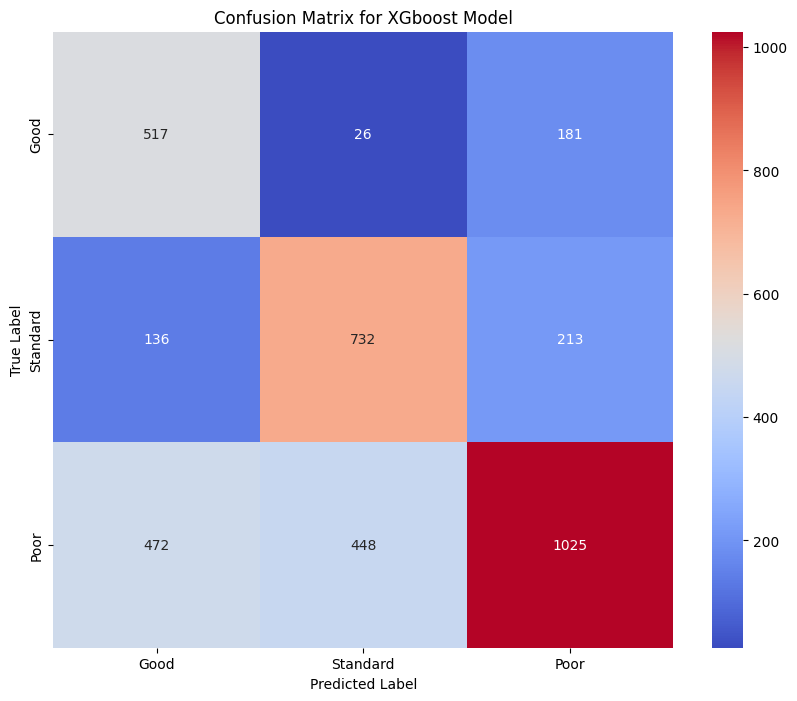

In [ ]:
#plot confusion matrix for xgboost results
from sklearn.metrics import confusion_matrix

#plot figure
plt.figure(figsize=(10,8))

#create confusion matrix
confusion_matrix_result = confusion_matrix(new_y_test,xgb_model_prediction)
sns.heatmap(confusion_matrix_result,annot=True,fmt='g',cmap='coolwarm',
            xticklabels=['Good','Standard','Poor'],
            yticklabels=['Good','Standard','Poor'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for XGboost Model')
plt.savefig('XGboost_confusion_matrix.png')
plt.show()



In [ ]:
new_X_train

Credit_Mix  Annual_Income  Num_Bank_Accounts  Num_Credit_Card  \
4254          2.0       0.414523           1.124748         1.026672   
666           2.0       0.414054           0.741276         0.741276   
5323          1.0       0.414507           0.959135         1.080418   
3662          2.0       0.413884           1.080418         1.026672   
1839          1.0       0.413924           1.124748         0.959135   
...           ...            ...                ...              ...   
5300          0.0       0.413510           1.194706         1.194706   
8443          2.0       0.413493           1.162283         1.124748   
12028         0.0       0.414242           1.248441         1.194706   
8278          0.0       0.414324           1.271150         1.194706   
10792         1.0       0.413958           1.026672         0.741276   

       Interest_Rate  Num_of_Loan  Delay_from_due_date  Changed_Credit_Limit  \
4254        1.271150     1.734031            -0.038588             -0.291739   
666         1.248441     1.727216            -0.504471             -1.206316   
5323        0.741276     1.730662            -0.777443             -0.955713   
3662        1.385227     1.730662             0.823623              0.694894   
1839        0.869742     1.730662            -1.650473             -0.233820   
...              ...          ...                  ...                   ...   
5300        1.372307     1.740550             1.086012              1.311987   
8443        1.310506     1.737326            -0.420474             -0.019707   
12028       1.372307     1.737326             1.284013             -0.763540   
8278        1.496434     1.740550             0.481649              1.036675   
10792       1.124748     1.727216            -0.504471              0.517792   

       Outstanding_Debt  Total_EMI_per_month  Risk_Spending  \
4254           3.388633             1.778642       0.666723   
666            3.122409             1.663554       0.827787   
5323           3.606438             1.680940       0.797670   
3662           3.621079             1.872332       0.580155   
1839           3.129437             1.536803       0.634545   
...                 ...                  ...            ...   
5300           4.012040             1.621143       0.500241   
8443           3.138151             1.651053       0.670685   
12028          3.767743             1.831850       0.734396   
8278           3.972588             1.893384       0.562803   
10792          3.504714             1.663554       0.594588   

       Financial_Stress_Index  Debt_to_income_ratio  \
4254                 1.633715              8.174784   
666                  1.553881              7.541063   
5323                 1.768468              8.700553   
3662                 1.717712              8.749016   
1839                 1.749167              7.560410   
...                       ...                   ...   
5300                 2.087492              9.702404   
8443                 1.727509              7.589363   
12028                2.107624              9.095503   
8278                 1.950969              9.588117   
10792                1.822553              8.466353   

       Payment_of_Min_Amount_Encoded  
4254                               2  
666                                1  
5323                               1  
3662                               0  
1839                               1  
...                              ...  
5300                               2  
8443                               2  
12028                              2  
8278                               2  
10792                              1  

[8750 rows x 14 columns]

In [ ]:


new_X_train['Changed_Credit_Limit'] = new_X_train['Changed_Credit_Limit'].fillna(new_X_train['Changed_Credit_Limit'].mean())
new_X_test['Changed_Credit_Limit'] = new_X_test['Changed_Credit_Limit'].fillna(
    new_X_test['Changed_Credit_Limit'].mean()
)

In [ ]:
new_X_train.isnull().sum()

Credit_Mix                       0
Annual_Income                    0
Num_Bank_Accounts                0
Num_Credit_Card                  0
Interest_Rate                    0
Num_of_Loan                      0
Delay_from_due_date              0
Changed_Credit_Limit             0
Outstanding_Debt                 0
Total_EMI_per_month              0
Risk_Spending                    0
Financial_Stress_Index           0
Debt_to_income_ratio             0
Payment_of_Min_Amount_Encoded    0
dtype: int64

plot decision boudary between classes

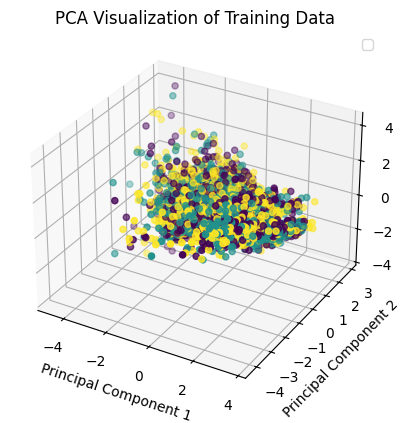

In [ ]:
from sklearn.decomposition import PCA

#create an dimensionality reduction wiht 3D space over training data
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(new_X_train)
new_X_train_pca = pd.DataFrame(X_train_pca, columns=['PC1', 'PC2', 'PC3'])
new_df = new_X_train_pca.iloc[:len(xgb_model_prediction)]


#visualize 3D scatter projection for XGBOOST Model prediction
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(new_df['PC1'], new_df['PC2'], new_df['PC3'], c=xgb_model_prediction, cmap='viridis')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('PCA Visualization of Training Data')
plt.legend()
plt.show()

from Above Visualization we can predict that Class are overlapping with each other due to non Linearity set and high cardinality features

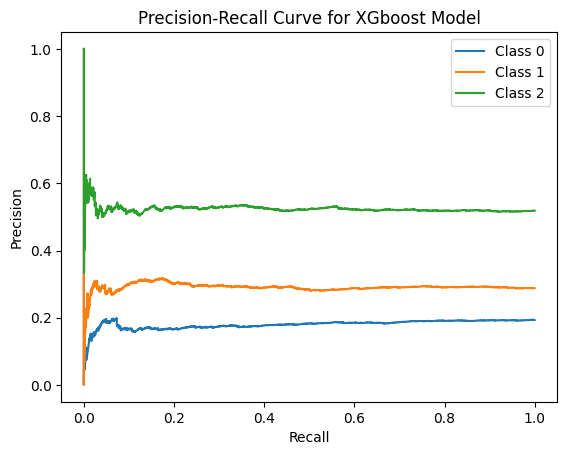

In [ ]:
#plot the precision and recall curve to check bias and tradeoff between loss of XGboost Model
#binarize data into OVR approach
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve

y_test_binarized = label_binarize(y_test.values.flatten(), classes=np.unique(y_test.values.flatten()))

#calculate probability
xgb_model_prediction_prob = trained_model.predict_proba(new_X_test)

#plot precision and recall curve with different threshold over each class
for i , class_label in enumerate(np.unique(y_test.values.flatten())):

  precision,recall,thresholds = precision_recall_curve(y_test_binarized[:,i],xgb_model_prediction_prob[:,i])
  plt.plot(recall,precision,label=f'Class {class_label}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for XGboost Model')
plt.legend()
plt.show()

In [ ]:
xgboost_classification_result

In [ ]:
#find best class for XGBOOST model
best_xgboost_class = None
best_f1_score = -1

for labels in xgboost_classification_result:
  if labels not in ["accuracy","macro avg","weighted avg","micro avg"]:
    f1_score = xgboost_classification_result[labels]["f1-score"]
    if f1_score > best_f1_score:
      best_f1_score = f1_score
      best_xgboost_class = labels

print(f" Best Class Learned By XGBOOST Model : {best_xgboost_class}")
print(f" Best F1 score for best class : {best_f1_score}")


#find worst class for XGBOOST
worst_xgboost_class = None
worst_f1_score = 1  # max possible

for label, metrics in xgboost_classification_result.items():
    if label not in ["accuracy", "macro avg", "weighted avg", "micro avg"]:
        f1 = metrics["f1-score"]

        if f1 < worst_f1_score:
            worst_f1_score = f1
            worst_xgboost_class = label

print(f"Worst Class Learned By XGBOOST Model : {worst_xgboost_class}")
print(f"Worst F1 score for worst class : {worst_f1_score}")


 Best Class Learned By XGBOOST Model : 1
 Best F1 score for best class : 0.640139921294272
Worst Class Learned By XGBOOST Model : 0
Worst F1 score for worst class : 0.5592212006489995


from Above observation we can notice that There is some slighly recall changes in XGBoost Model for Good Category due to higher weightage assign to XGboost and due to number of samples of Standard so model stablilizes on Standard credit type
Class (0) - Goodsneeds to improve its recall

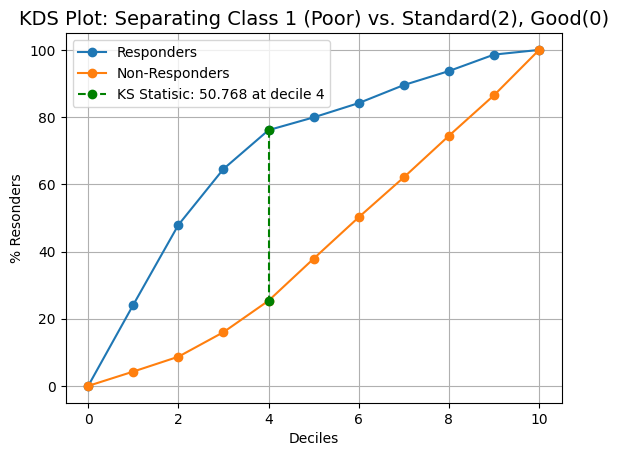

In [ ]:
#plot to see how increase recall class affect model through KDS visualization
#plot the KDS visualization for Poor class
import kds

#plot the kds metrics for Google class
class_label = 1
sample_y_true_binary = (new_y_test.values.flatten() == class_label).astype(int)

#predict probabilities for all classes
all_class_probabilities = trained_model.predict_proba(new_X_test)

#slice the probabilities to get only for the class of interest
xgb_model_prediction_prob_for_class = all_class_probabilities[:, class_label]

#plot kds statistics to check poor (1) vs non poor(0,2) through OVR approach
kds.metrics.plot_ks_statistic(
    sample_y_true_binary,
    xgb_model_prediction_prob_for_class,
    title=f'KDS Plot: Separating Class {class_label} (Poor) vs. Standard(2), Good(0)'
)


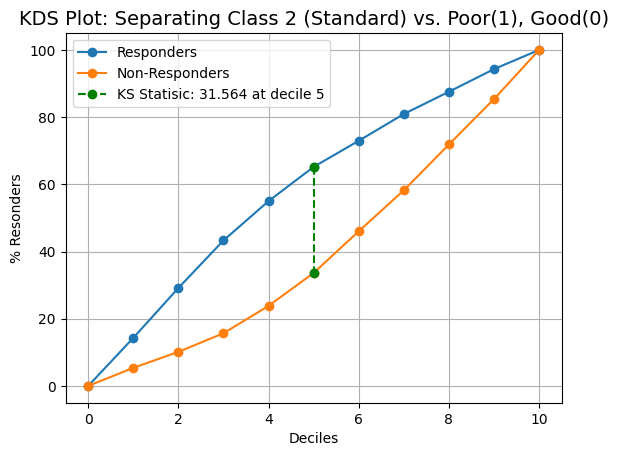

In [ ]:
#plot to see how increase recall class affect model through KDS visualization
#plot the KDS visualization for Poor class
import kds

#plot the kds metrics for Google class
class_label = 2
sample_y_true_binary = (new_y_test.values.flatten() == class_label).astype(int)

#predict probabilities for all classes
all_class_probabilities = trained_model.predict_proba(new_X_test)

#slice the probabilities to get only for the class of interest
xgb_model_prediction_prob_for_class = all_class_probabilities[:, class_label]

#plot kds statistics to check poor (1) vs non poor(0,2) through OVR approach
kds.metrics.plot_ks_statistic(
    sample_y_true_binary,
    xgb_model_prediction_prob_for_class,
    title=f'KDS Plot: Separating Class {class_label} (Standard) vs. Poor(1), Good(0)'
)


In [ ]:
#plot to see how increase recall class affect model through KDS visualization
#plot the KDS visualization for Poor class
import kds

#plot the kds metrics for Google class
class_label = 0
sample_y_true_binary = (new_y_test.values.flatten() == class_label).astype(int)

#predict probabilities for all classes
all_class_probabilities = trained_model.predict_proba(new_X_test)

#slice the probabilities to get only for the class of interest
xgb_model_prediction_prob_for_class = all_class_probabilities[:, class_label]

#plot kds statistics to check poor (1) vs non poor(0,2) through OVR approach
kds.metrics.plot_ks_statistic(
    sample_y_true_binary,
    xgb_model_prediction_prob_for_class,
    title=f'KDS Plot: Separating Class {class_label} (Good) vs. Poor(1), Standard(2)'
)


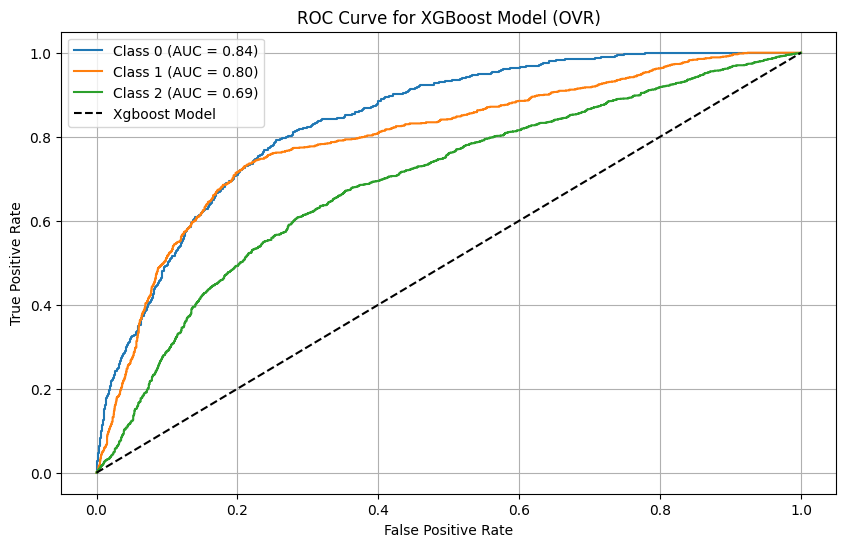

In [ ]:
#plot the roc curve to check area for each classes
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

#binarize the label through OVR approach
label_classes = np.unique(new_y_test.values)  # Get unique classes from the Series values
new_y_test_binarized = label_binarize(new_y_test.values, classes=label_classes) # Corrected: Removed () after .values

# Get prediction probabilities from the trained XGBoost model
xgb_scores = trained_model.predict_proba(new_X_test)

plt.figure(figsize=(10, 6))

# Iterate through each class for OVR
for i, class_label in enumerate(label_classes):

    # Compute FPR, TPR, Thresholds
    fpr, tpr, thresholds = roc_curve(
        new_y_test_binarized[:, i], # True labels for the current class
        xgb_scores[:, i]            # Predicted probabilities for the current class
    )

    # Compute AUC score
    auc_score = roc_auc_score(
        new_y_test_binarized[:, i],
        xgb_scores[:, i]
    )

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'Class {class_label} (AUC = {auc_score:.2f})')

# Plot formatting
plt.plot([0, 1], [0, 1], 'k--', label='Xgboost Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost Model (OVR)')
plt.legend()
plt.grid(True)
plt.show()

so ROC curve gives probability for each class amd scoring accuracy and Xgboost model improves the Risk scoring and Overlapping between the classes comparing to  Baseline model

In [ ]:
#new_X_train['Credit_History_Year'] = pd.to_numeric(
    #new_X_train['Credit_History_Year'])
#new_X_test['Credit_History_Year'] = pd.to_numeric(
    #new_X_test['Credit_History_Year'])

In [ ]:
print(new_X_train.shape)
print(new_X_test.shape)


(8750, 14)
(3750, 14)


3. CatBoostClassification Algorithm

Assign optimized Weights to each training set target function

In [ ]:
new_y_train.value_counts(normalize=True)

Credit_Score
2    0.518857
1    0.288114
0    0.193029
Name: proportion, dtype: float64

In [ ]:
class_weights = {
    0: 1.3,  #weights assigned to low risk
    1: 1.0, #weights assigned to high risk
    2: 0.8  #weights assigned to Medium Risk
}

#compute the above class weights in y_train column
sample_weights = [class_weights[label] for label in new_y_train]
sample_weights

[0.8,
 1.3,
 0.8,
 1.3,
 1.0,
 1.0,
 0.8,
 1.0,
 0.8,
 0.8,
 0.8,
 0.8,
 1.0,
 0.8,
 1.0,
 0.8,
 0.8,
 0.8,
 1.0,
 1.3,
 0.8,
 0.8,
 0.8,
 1.3,
 0.8,
 1.3,
 1.0,
 0.8,
 1.0,
 1.0,
 1.3,
 0.8,
 1.3,
 0.8,
 0.8,
 0.8,
 0.8,
 1.0,
 0.8,
 0.8,
 1.0,
 1.0,
 0.8,
 0.8,
 1.0,
 0.8,
 1.0,
 1.0,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 1.3,
 0.8,
 1.0,
 0.8,
 1.0,
 1.0,
 1.0,
 0.8,
 0.8,
 1.3,
 0.8,
 1.0,
 1.3,
 0.8,
 0.8,
 0.8,
 0.8,
 1.0,
 1.3,
 1.0,
 1.3,
 1.0,
 1.0,
 1.3,
 1.3,
 0.8,
 1.0,
 1.3,
 1.3,
 0.8,
 0.8,
 0.8,
 1.0,
 0.8,
 0.8,
 1.3,
 0.8,
 0.8,
 1.0,
 0.8,
 0.8,
 0.8,
 1.0,
 0.8,
 1.0,
 0.8,
 0.8,
 0.8,
 1.3,
 1.0,
 0.8,
 1.3,
 1.3,
 0.8,
 0.8,
 0.8,
 1.0,
 0.8,
 0.8,
 0.8,
 1.3,
 0.8,
 1.3,
 1.3,
 0.8,
 1.0,
 0.8,
 1.0,
 0.8,
 0.8,
 1.0,
 1.3,
 0.8,
 0.8,
 0.8,
 1.3,
 1.0,
 0.8,
 1.0,
 0.8,
 1.0,
 1.0,
 0.8,
 1.0,
 1.0,
 1.0,
 1.0,
 1.3,
 1.0,
 0.8,
 1.0,
 1.3,
 0.8,
 1.3,
 1.3,
 1.0,
 0.8,
 0.8,
 1.3,
 1.0,
 1.0,
 1.0,
 0.8,
 0.8,
 1.3,
 0.8,
 0.8,
 1.3,
 1.3,
 1.0,
 1.0,
 1.3,
 1.0

Create an Processing Technique used in Catboost classifier

In [ ]:
new_X_train['Credit_Mix'] = new_X_train['Credit_Mix'].astype('category')
new_X_train['Payment_of_Min_Amount_Encoded'] = new_X_train['Payment_of_Min_Amount_Encoded'].astype('category')


In [ ]:
#create an preprocessing pipeline workflow wiht appropiate steps of preprocessing
from sklearn.compose import ColumnTransformer

#Define Numeric features for robust scaling handles outliers well (Optional)
numeric_features = [
    "Annual_Income", "Num_Bank_Accounts",
    "Num_Credit_Card", "Interest_Rate", "Num_of_Loan", "Delay_from_due_date",
    "Credit_Utilization_Ratio", "Total_EMI_per_month",
     "Utilization_Change", "Risk_Spending",
    "Financial_Stress_Index", "Debt_to_income_ratio","Outstanding_Debt"
]

#define categorical features for catboost model
categorical_features = ["Credit_Mix", "Payment_of_Min_Amount_Encoded"]

#store all training cols into list to compare
compare_cols = [cols for cols in new_X_train.columns]

#validate if define features and actual cols are true or not
numeric_missing_cols = [cols for cols in compare_cols if cols not in numeric_features]

categorical_missing_cols = [cols for cols in compare_cols if cols not in categorical_features]


#create an function for Catboost model workflow if features are present
def create_catboost_preprocessing_pipeline(numeric_features,categorical_features):

  """ Create an setup for defining Catboost preprocessing pipeline """
  """ Robust Scaling for Numeric Features (Optional) - Catboost handles outliers well """
  """ Categorical features - Define categorical features to model"""
  try:


    #combine preprocessing steps into column transformer method
    column_transformer = ColumnTransformer(
        transformers=[],
        remainder='passthrough' )
    if column_transformer is not None:
      return column_transformer
    else:
      raise ValueError("Column transformer is None")
  except Exception as e:
    print(f"Error creating column transformer: {e}")

#call catboost_preprocessing pipeline workflow  method
catboost_preprocessor = create_catboost_preprocessing_pipeline(numeric_features,categorical_features)
catboost_preprocessor

ColumnTransformer(remainder='passthrough', transformers=[])

In [ ]:
new_X_train_transformed_copy = catboost_preprocessor.fit_transform(new_X_train)
new_X_test_transformed_copy = catboost_preprocessor.transform(new_X_test)

In [ ]:
new_X_train_transformed_copy

array([[2.        , 0.41452263, 1.12474826, ..., 1.6337147 , 8.17478449,
        2.        ],
       [2.        , 0.41405425, 0.74127631, ..., 1.55388142, 7.54106261,
        1.        ],
       [1.        , 0.4145068 , 0.95913484, ..., 1.76846775, 8.70055288,
        1.        ],
       ...,
       [0.        , 0.41424247, 1.24844126, ..., 2.10762426, 9.0955026 ,
        2.        ],
       [0.        , 0.41432411, 1.27114985, ..., 1.95096938, 9.58811706,
        2.        ],
       [1.        , 0.41395793, 1.02667203, ..., 1.82255284, 8.46635289,
        1.        ]])

In [ ]:
new_X_train['Credit_Mix'] = new_X_train['Credit_Mix'].astype('category')
new_X_train['Payment_of_Min_Amount_Encoded'] = new_X_train['Payment_of_Min_Amount_Encoded'].astype('category')


Create Catboost Classification Model wiht Hyperparameter Tuning

In [ ]:
class_weights_list = [
    class_weights[i] for i in sorted(class_weights.keys())  #sort list
]
class_weights_list

[1.3, 1.0, 0.8]

In [ ]:

categorical_cols = new_X_train.select_dtypes(include=['category']).columns
cat_features_indices = [new_X_train.columns.get_loc(col) for col in categorical_cols]

print("Categorical columns:", list(categorical_cols))
print("CatBoost cat_features indices:", cat_features_indices)


Categorical columns: ['Credit_Mix', 'Payment_of_Min_Amount_Encoded']
CatBoost cat_features indices: [0, 13]


In [ ]:
new_X_train

Credit_Mix  Annual_Income  Num_Bank_Accounts  Num_Credit_Card  \
4254         2.0       0.414523           1.124748         1.026672   
666          2.0       0.414054           0.741276         0.741276   
5323         1.0       0.414507           0.959135         1.080418   
3662         2.0       0.413884           1.080418         1.026672   
1839         1.0       0.413924           1.124748         0.959135   
...          ...            ...                ...              ...   
5300         0.0       0.413510           1.194706         1.194706   
8443         2.0       0.413493           1.162283         1.124748   
12028        0.0       0.414242           1.248441         1.194706   
8278         0.0       0.414324           1.271150         1.194706   
10792        1.0       0.413958           1.026672         0.741276   

       Interest_Rate  Num_of_Loan  Delay_from_due_date  Changed_Credit_Limit  \
4254        1.271150     1.734031            -0.038588             -0.291739   
666         1.248441     1.727216            -0.504471             -1.206316   
5323        0.741276     1.730662            -0.777443             -0.955713   
3662        1.385227     1.730662             0.823623              0.694894   
1839        0.869742     1.730662            -1.650473             -0.233820   
...              ...          ...                  ...                   ...   
5300        1.372307     1.740550             1.086012              1.311987   
8443        1.310506     1.737326            -0.420474             -0.019707   
12028       1.372307     1.737326             1.284013             -0.763540   
8278        1.496434     1.740550             0.481649              1.036675   
10792       1.124748     1.727216            -0.504471              0.517792   

       Outstanding_Debt  Total_EMI_per_month  Risk_Spending  \
4254           3.388633             1.778642       0.666723   
666            3.122409             1.663554       0.827787   
5323           3.606438             1.680940       0.797670   
3662           3.621079             1.872332       0.580155   
1839           3.129437             1.536803       0.634545   
...                 ...                  ...            ...   
5300           4.012040             1.621143       0.500241   
8443           3.138151             1.651053       0.670685   
12028          3.767743             1.831850       0.734396   
8278           3.972588             1.893384       0.562803   
10792          3.504714             1.663554       0.594588   

       Financial_Stress_Index  Debt_to_income_ratio  \
4254                 1.633715              8.174784   
666                  1.553881              7.541063   
5323                 1.768468              8.700553   
3662                 1.717712              8.749016   
1839                 1.749167              7.560410   
...                       ...                   ...   
5300                 2.087492              9.702404   
8443                 1.727509              7.589363   
12028                2.107624              9.095503   
8278                 1.950969              9.588117   
10792                1.822553              8.466353   

      Payment_of_Min_Amount_Encoded  
4254                              2  
666                               1  
5323                              1  
3662                              0  
1839                              1  
...                             ...  
5300                              2  
8443                              2  
12028                             2  
8278                              2  
10792                             1  

[8750 rows x 14 columns]

In [ ]:
#build Catboost model algorithm with assigned class weights
class Catboost_Algorithm:

    def __init__(self,training_input,training_output,testing_input,testing_output,categorical_features,class_weight):
        self.training_input_set = training_input
        self.training_output_set = training_output
        self.testing_input_set = testing_input
        self.testing_output_set = testing_output
        self.class_weights = class_weight
        self.preprocessing_workflow = catboost_preprocessor
        self.random_state = 42
        self.categorical_features = categorical_features

        # Wrap the CatBoost model
        self.catboost_model = CatBoostClassifier(
            random_state=42,
            loss_function='MultiClass',  #assign loss function
            eval_metric='TotalF1',  #focus on F1 score (Harmonic mean for precision and recall) for Total folds data
            task_type='GPU' if torch.cuda.is_available() else 'CPU',
            class_weights = self.class_weights
        )

    def catboost_pipeline(self):
        return [
            ('Catboost_preprocessing_workflow', self.preprocessing_workflow), #adding optional workflow Robust Scaling
            ('model', self.catboost_model)
        ]

    def hyperparameter_optimization_search(self, catboost_model_pipeline):
        catboost_params = {
            'model__iterations': [500, 700, 900],
            'model__learning_rate': [0.03, 0.05],
           'model__depth': [6, 7],
          'model__l2_leaf_reg': [5, 7, 9],
          'model__random_strength': [0.5, 1.0],
          'model__bootstrap_type': ['Bayesian', 'Bernoulli'],
          'model__subsample': [0.8, 0.9]
}

        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=self.random_state)
        return RandomizedSearchCV(
            estimator=Pipeline(catboost_model_pipeline),
            param_distributions=catboost_params,
            n_iter=20,
            cv=cv,
            scoring='f1_macro',
            verbose=2,
            random_state=self.random_state,
            n_jobs=1
        )

    def catboost_training(self, catboost_random_search):
        try:
            # No need to pass model__cat_features anymore — wrapper handles it
            trained_model = catboost_random_search.fit(self.training_input_set, self.training_output_set)
            return trained_model
        except Exception as e:
            return logging.error(e)
#call the above function
catboost_model = Catboost_Algorithm(new_X_train,new_y_train,new_X_test,new_y_test,cat_features_indices ,class_weights_list)
catboost_model_pipeline = catboost_model.catboost_pipeline()
catboost_random_search = catboost_model.hyperparameter_optimization_search(catboost_model_pipeline)
trained_catboost_model = catboost_model.catboost_training(catboost_random_search)

if trained_catboost_model is not None:
  print("Catboost training Status : Success")
else:
  print("Catboost Training status : Failed")


Streaming output truncated to the last 5000 lines.
15:	learn: 0.5967967	total: 465ms	remaining: 14.1s
16:	learn: 0.5995307	total: 495ms	remaining: 14.1s
17:	learn: 0.6002096	total: 529ms	remaining: 14.2s
18:	learn: 0.5999123	total: 569ms	remaining: 14.4s
19:	learn: 0.5998257	total: 606ms	remaining: 14.6s
20:	learn: 0.5998593	total: 640ms	remaining: 14.6s
21:	learn: 0.6001938	total: 655ms	remaining: 14.2s
22:	learn: 0.6012026	total: 671ms	remaining: 13.9s
23:	learn: 0.6013562	total: 686ms	remaining: 13.6s
24:	learn: 0.6020914	total: 701ms	remaining: 13.3s
25:	learn: 0.6018381	total: 717ms	remaining: 13.1s
26:	learn: 0.6015879	total: 742ms	remaining: 13s
27:	learn: 0.6022039	total: 768ms	remaining: 13s
28:	learn: 0.6020457	total: 793ms	remaining: 12.9s
29:	learn: 0.6018947	total: 810ms	remaining: 12.7s
30:	learn: 0.6013156	total: 826ms	remaining: 12.5s
31:	learn: 0.6028431	total: 841ms	remaining: 12.3s
32:	learn: 0.6036130	total: 856ms	remaining: 12.1s
33:	learn: 0.6040751	total: 871ms	r

In [ ]:
catboost_predictions = trained_catboost_model.predict(new_X_test)

catboost_classification = classification_report(new_y_test,catboost_predictions)
print(catboost_classification)

              precision    recall  f1-score   support

           0       0.50      0.63      0.56       724
           1       0.63      0.61      0.62      1081
           2       0.68      0.63      0.66      1945

    accuracy                           0.63      3750
   macro avg       0.61      0.62      0.61      3750
weighted avg       0.63      0.63      0.63      3750



In [ ]:
from catboost import Pool , cv

# Map training datatset to object indices with categorical features
new_X_train['Credit_Mix'] = new_X_train['Credit_Mix'].apply(lambda x: str(x))  #assign all values for Categorical columns to string
new_X_train['Payment_of_Min_Amount_Encoded'] = new_X_train['Payment_of_Min_Amount_Encoded'].apply(lambda x: str(x))
categorical_cols = ['Credit_Mix', 'Payment_of_Min_Amount_Encoded']
best_params = trained_catboost_model.best_params_   #fetch best paramters from trained model
#map training data into Pool indices
train_pool = Pool(
    data=new_X_train,
    label=new_y_train,
    cat_features=categorical_cols
)

best_params = {
    'subsample': best_params['model__subsample'],
  'loss_function': 'MultiClass',  #apply multiclass loss function
  'eval_metric': 'TotalF1',  #evalauet based on F1-score
 'random_strength': best_params['model__random_strength'],
 'learning_rate': best_params['model__learning_rate'],
 'l2_leaf_reg': best_params['model__l2_leaf_reg'],
 'iterations': best_params['model__iterations'],
 'depth': best_params['model__depth'],
 'bootstrap_type': best_params['model__bootstrap_type']
}

#apply cross validation for 5 fold set to check multiclass loss function
catboost_cv = cv(
    pool=train_pool,  #assign training data
    params=best_params, #assign best parameters for trained catboost model
    fold_count=5,
    plot=True,  #Assign loss visualization
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.6255854428
bestIteration = 478

Training on fold [1/5]

bestTest = 0.618894732
bestIteration = 252

Training on fold [2/5]

bestTest = 0.6071817
bestIteration = 431

Training on fold [3/5]

bestTest = 0.6171960152
bestIteration = 148

Training on fold [4/5]

bestTest = 0.6117718138
bestIteration = 325



In [ ]:
catboost_cv

iterations  test-TotalF1-mean  test-TotalF1-std  train-TotalF1-mean  \
0             0           0.562810          0.017387            0.574479   
1             1           0.589347          0.012066            0.597573   
2             2           0.594040          0.010825            0.601444   
3             3           0.593412          0.009931            0.602511   
4             4           0.595038          0.011078            0.605272   
..          ...                ...               ...                 ...   
495         495           0.609986          0.007788            0.696635   
496         496           0.611036          0.007571            0.696474   
497         497           0.610459          0.007410            0.696594   
498         498           0.610750          0.007872            0.696861   
499         499           0.610394          0.007104            0.696867   

     train-TotalF1-std  test-MultiClass-mean  test-MultiClass-std  \
0             0.012503              1.086480             0.000321   
1             0.006491              1.075041             0.000273   
2             0.004980              1.064275             0.000628   
3             0.003700              1.054075             0.000666   
4             0.002398              1.044387             0.000623   
..                 ...                   ...                  ...   
495           0.004276              0.815124             0.013044   
496           0.004249              0.815105             0.013045   
497           0.004525              0.815093             0.013032   
498           0.004481              0.815127             0.013037   
499           0.004358              0.815177             0.013026   

     train-MultiClass-mean  train-MultiClass-std  
0                 1.086208              0.000498  
1                 1.074604              0.000631  
2                 1.063759              0.001020  
3                 1.053400              0.000849  
4                 1.043532              0.000718  
..                     ...                   ...  
495               0.716331              0.005484  
496               0.716195              0.005483  
497               0.716048              0.005490  
498               0.715890              0.005456  
499               0.715718              0.005427  

[500 rows x 9 columns]

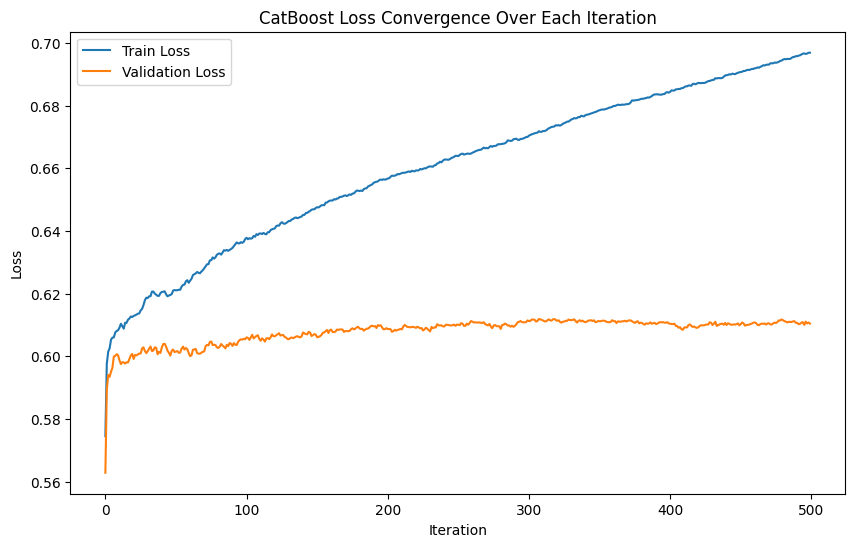

In [ ]:
#create an loss convergence for each boostraping tress
validation_loss = catboost_cv['test-TotalF1-mean']
train_loss = catboost_cv['train-TotalF1-mean']
iteration_tree = catboost_cv['iterations']

plt.figure(figsize=(10, 6))
plt.plot(iteration_tree, train_loss, label='Train Loss')
plt.plot(iteration_tree, validation_loss, label='Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('CatBoost Loss Convergence Over Each Iteration')
plt.legend()
plt.show()

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.12/dist-packages/matplotlib/pyplot.py'>

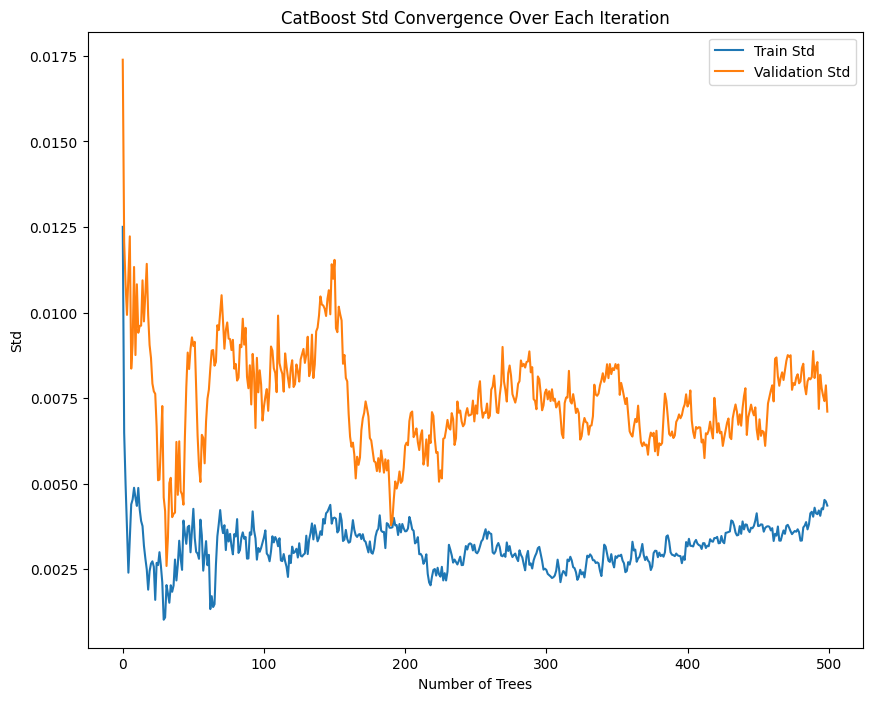

In [ ]:
#check std deviation (Training and testing varaince for catboost Model) for each bootstrap trees (Finding Stability for training and testing)
validation_std = catboost_cv['test-TotalF1-std']
train_std = catboost_cv['train-TotalF1-std']

plt.figure(figsize=(10,8))
plt.plot(iteration_tree, train_std, label='Train Std')
plt.plot(iteration_tree, validation_std, label='Validation Std')
plt.xlabel('Number of Trees')
plt.ylabel('Std')
plt.legend()
plt.title('CatBoost Std Convergence Over Each Iteration')
plt

from Above Analyis we can see that Stability for Catboost model after Bootstrap tree validation get stability which improves the recall but training std aggressively drops after Each to full maximum length of Tree

In [ ]:
def retrain_catboost_model(catboost_random_search, new_X_train, new_y_train,new_X_test,new_y_test):
    """
    Retrain the CatBoost model using early stopping.

    Args:
        catboost_random_search: Hyperparameter-tuned CatBoost model (e.g., from RandomizedSearchCV or GridSearchCV)
        new_X_train: Training features
        new_y_train: Training labels

    Returns:
        retrained CatBoost model fitted on new_X_train and new_y_train
    """
    stopping_iterations = 30

    # Get the best estimator (which is a Pipeline) from the RandomizedSearchCV result
    retrained_pipeline = catboost_random_search.best_estimator_

    # Re-fit the best pipeline with early stopping parameters
    # The 'model__' prefix directs parameters to the 'model' step within the pipeline
    trained_catboost = retrained_pipeline.fit(
        new_X_train,
        new_y_train,
        model__early_stopping_rounds=stopping_iterations,  #apply early stop callbacks for tree to stop on best validation loss,
        model__verbose=False  #do not show output logs
    )

    # return best model with best pipeline
    return retrained_pipeline , catboost_random_search.best_params_ , trained_catboost

retrained_catboost_model  , retrained_catboost_best_params , trained_catboost = retrain_catboost_model(catboost_random_search, new_X_train, new_y_train,new_X_test,new_y_test)
print(retrained_catboost_model)

Pipeline(steps=[('Catboost_preprocessing_workflow',
                 ColumnTransformer(remainder='passthrough', transformers=[])),
                ('model',
                 <catboost.core.CatBoostClassifier object at 0x7bb6796e9d30>)])


In [ ]:
print(classification_report(new_y_test,trained_catboost_model.predict(new_X_test)))

catbooost_classification = classification_report(new_y_test,trained_catboost_model.predict(new_X_test),output_dict=True)


              precision    recall  f1-score   support

           0       0.50      0.63      0.56       724
           1       0.63      0.61      0.62      1081
           2       0.68      0.63      0.66      1945

    accuracy                           0.63      3750
   macro avg       0.61      0.62      0.61      3750
weighted avg       0.63      0.63      0.63      3750



In [ ]:
#apply catboost cross validation to check overfitting issue over each parameters loss
from catboost import cv , Pool

retrain_params = {
    'subsample': retrained_catboost_best_params['model__subsample'],
  'loss_function': 'MultiClass',  #apply multiclass loss function
  'eval_metric': 'TotalF1',  #evalauet based on F1-score
 'random_strength': retrained_catboost_best_params['model__random_strength'],
 'learning_rate': retrained_catboost_best_params['model__learning_rate'],
 'l2_leaf_reg': retrained_catboost_best_params['model__l2_leaf_reg'],
 'iterations': retrained_catboost_best_params['model__iterations'],
 'depth': retrained_catboost_best_params['model__depth'],
 'bootstrap_type': retrained_catboost_best_params['model__bootstrap_type']
}

#define categorical features
categorical_cols = ['Credit_Mix', 'Payment_of_Min_Amount_Encoded']
retrained_pool = Pool(
    data=new_X_train,
    label=new_y_train,
    cat_features=categorical_cols
)

#apply catboost cross validation for each fold on training set
training_fold = 5
retrained_catboost_cv = cv(
    pool=retrained_pool,  #assign training data
    params=retrain_params, #assign best parameters for trained catboost model
    fold_count=training_fold,
    plot=True,  #Assign loss visualization
    verbose=False
)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.6255854428
bestIteration = 478

Training on fold [1/5]

bestTest = 0.618894732
bestIteration = 252

Training on fold [2/5]

bestTest = 0.6071817
bestIteration = 431

Training on fold [3/5]

bestTest = 0.6171960152
bestIteration = 148

Training on fold [4/5]

bestTest = 0.6117718138
bestIteration = 325



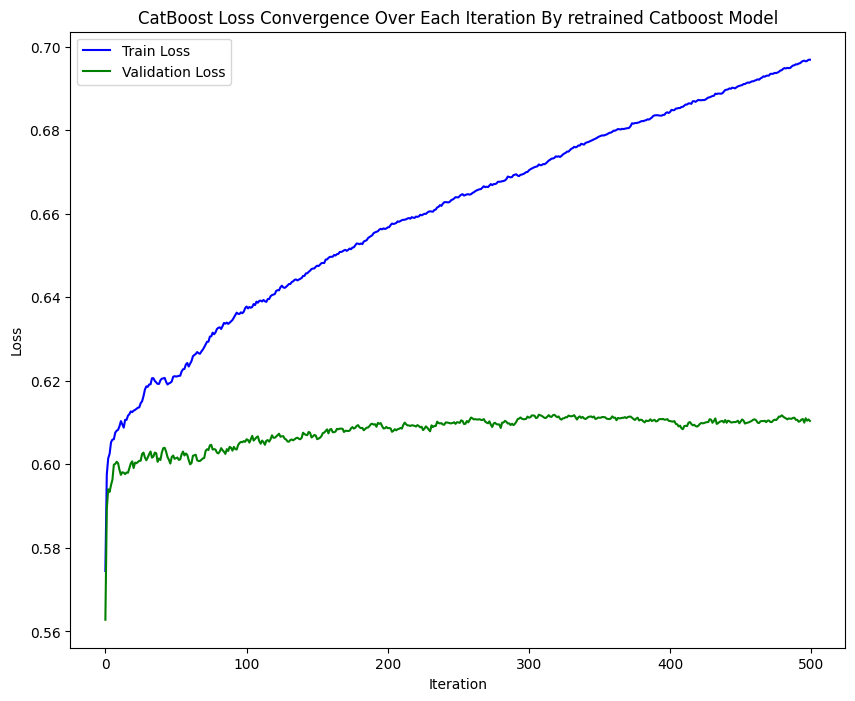

In [ ]:
#plot the convergence for loss for retrained model to check whether there is improvement in stability in model or not
validation_loss = retrained_catboost_cv['test-TotalF1-mean']
train_loss = retrained_catboost_cv['train-TotalF1-mean']
iteration_tree = retrained_catboost_cv['iterations']

plt.figure(figsize=(10,8))  #define figure size for retrained model
plt.plot(iteration_tree, train_loss, label='Train Loss', color='blue')
plt.plot(iteration_tree, validation_loss, label='Validation Loss',color='Green')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('CatBoost Loss Convergence Over Each Iteration By retrained Catboost Model')
plt.legend()
plt.show()

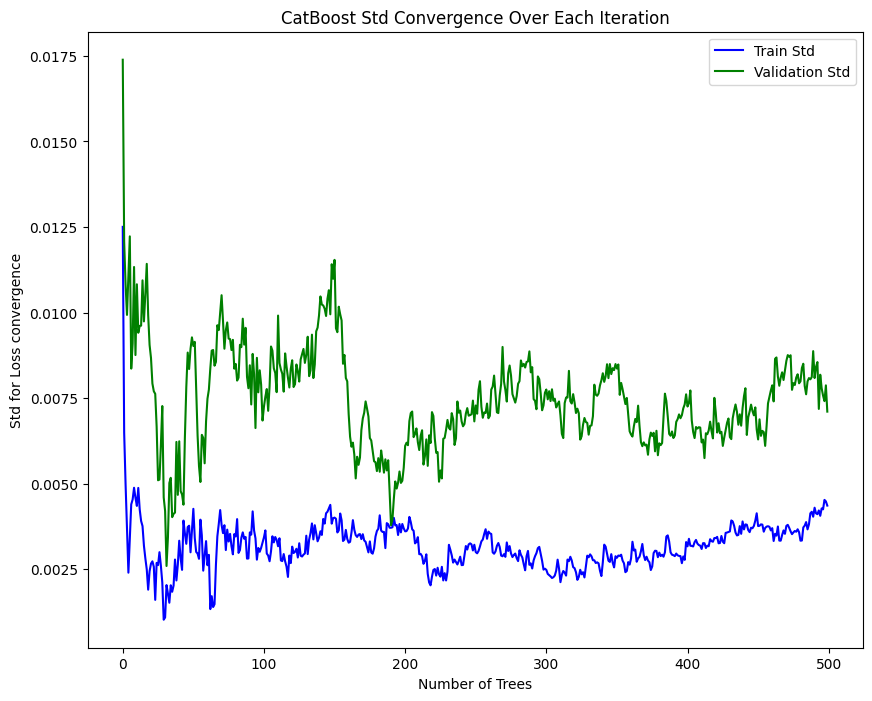

In [ ]:
#plot figure to check stability of loss variance for training and validation loss using std
validation_std = retrained_catboost_cv['test-TotalF1-std']
train_std = retrained_catboost_cv['train-TotalF1-std']
iteration_tree = retrained_catboost_cv['iterations']

plt.figure(figsize=(10,8))  #define figure object for line graph
plt.plot(iteration_tree, train_std, label='Train Std',color='blue')
plt.plot(iteration_tree, validation_std, label='Validation Std',color='Green')
plt.xlabel('Number of Trees')
plt.ylabel('Std for Loss convergence')
plt.title('CatBoost Std Convergence Over Each Iteration By retrained Catboost Model')
plt.legend()
plt.title('CatBoost Std Convergence Over Each Iteration')
plt.show()

The standard deviation curves demonstrate improved stability during training. The training loss variance decreases rapidly and remains low, while validation loss variance shows a consistent and bounded pattern, indicating stable loss optimization and reliable generalization across iterations.

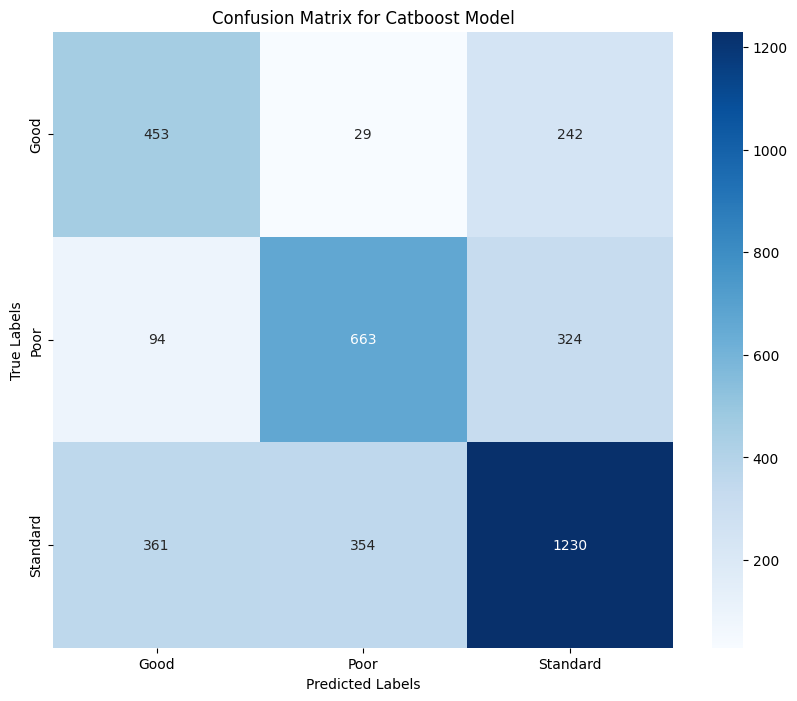

In [ ]:
#plot confusion matrix to check how well model is assigned labels to each
catboost_predictions = trained_catboost_model.predict(new_X_test)
predictions_copy = catboost_predictions.copy()

catboost_eval_matrix = confusion_matrix(new_y_test,predictions_copy)

#plot figure object with heatmap for visualizing evaluation metrics
plt.figure(figsize=(10,8))
sns.heatmap(catboost_eval_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Good', 'Poor', 'Standard'], yticklabels=['Good', 'Poor', 'Standard'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Catboost Model')
plt.show()

In [ ]:
from sklearn.metrics import classification_report # Re-import to ensure it's a callable function
import numpy as np # Import numpy for argmax

catboost_prob = retrained_catboost_model.predict_proba(new_X_test)
catboost_predictions = np.argmax(catboost_prob, axis=1)


catboost_report = classification_report(new_y_test, catboost_predictions,output_dict=True)
print(catboost_report)

{'0': {'precision': 0.4988986784140969, 'recall': 0.6256906077348067, 'f1-score': 0.5551470588235294, 'support': 724.0}, '1': {'precision': 0.6338432122370937, 'recall': 0.6133209990749307, 'f1-score': 0.6234132581100141, 'support': 1081.0}, '2': {'precision': 0.6848552338530067, 'recall': 0.6323907455012854, 'f1-score': 0.6575781876503609, 'support': 1945.0}, 'accuracy': 0.6256, 'macro avg': {'precision': 0.6058657081680657, 'recall': 0.6238007841036742, 'f1-score': 0.6120461681946349, 'support': 3750.0}, 'weighted avg': {'precision': 0.6342481561184541, 'recall': 0.6256, 'f1-score': 0.6279535406893634, 'support': 3750.0}}


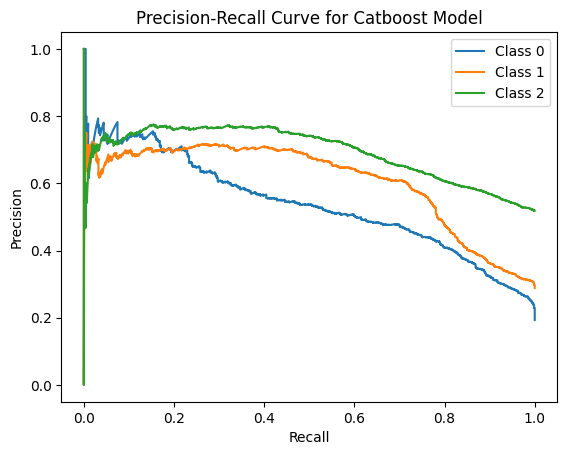

In [ ]:
#plot to check precison and recall curve how model is stable in catching genuine customers with probability

#binarize data into One vs Rest approach
labels = np.unique(new_y_test.values.flatten())
binarized_y_test = label_binarize(new_y_test.values.flatten(), classes=labels)

for i , class_labels in enumerate(labels):
  precision, recall, _ = precision_recall_curve(binarized_y_test[:, i], catboost_prob[:, i])  #check precision and recall for binary data
  plt.plot(recall, precision, label=f'Class {class_labels}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Catboost Model')
plt.legend()
plt.show()

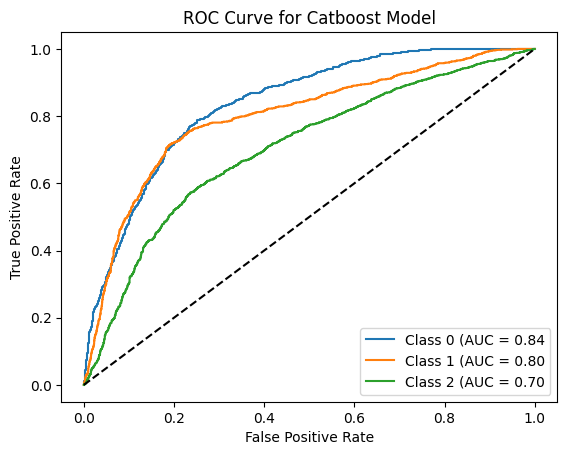

In [ ]:
#plot the roc curve to check probabilit or discrimination between one class

labels = np.unique(new_y_test.values.flatten())
new_y_test_binarized = label_binarize(new_y_test.values.flatten(), classes=labels)

for i, class_label in enumerate(labels):
    fpr, tpr, _ = roc_curve(new_y_test_binarized[:, i], catboost_prob[:, i])
    auc_score = roc_auc_score(new_y_test_binarized[:, i], catboost_prob[:, i])
    plt.plot(fpr, tpr, label=f'Class {class_label} (AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Catboost Model')
plt.legend()
plt.show()

In [ ]:
new_X_train

In [ ]:
from sklearn.metrics import f1_score # Re-import f1_score to ensure it's a callable function

#create an dict object to compare each model with macro f1 score and weighted F1 score
baseline_model_macro_f1 = f1_score(y_test,rf_model_prediction,average='macro')
baseline_model_weighted_f1 = f1_score(y_test,rf_model_prediction,average='weighted')

Xgboost_model_macro_f1 = f1_score(new_y_test,xgb_model_prediction,average='macro')
Xgboost_model_weighted_f1 = f1_score(new_y_test,xgb_model_prediction,average='weighted')

catboost_model_macro_f1 = f1_score(new_y_test,catboost_predictions,average='macro')
catboost_model_weighted_f1 = f1_score(new_y_test,catboost_predictions,average='weighted')

#create an list object
models = ['Random Forest','XGBoost','Catboost']
macro_f1_scores = [baseline_model_macro_f1,Xgboost_model_macro_f1,catboost_model_macro_f1]
weighted_f1_scores = [baseline_model_weighted_f1,Xgboost_model_weighted_f1,catboost_model_weighted_f1]


#create an stack bar chart with plotly Graphical object

#define Graphical Object with Figure
fig = go.Figure(data=[
    go.Bar(name='Macro F1 Score', x=models, y=macro_f1_scores),  #add barplots
    go.Bar(name='Weighted F1 Score', x=models, y=weighted_f1_scores)
])
fig.update_layout(
    title='Model Performance Comparison (Macro and Weighted F1 Scores)',
    xaxis_title='Models',
    yaxis_title='Scores',
    barmode='group'
)
fig.show()

In [ ]:
#best Model with feature importance
best_model = retrained_catboost_model

#fetch Catboost model from Pipeline
catboost_model = best_model.named_steps['model']
print(f" Type of Catboost Model : {type(catboost_model)}")

#calculate the feature importance results from catboost model
importance_value = catboost_model.feature_importances_
feature_columns = [best_model.feature_names_in_]
result_data = {
    'Importance_level':importance_value
}
df = pd.DataFrame(result_data,index=feature_columns)
df.sort_values(by='Importance_level',ascending=False,inplace=True)
df.reset_index(inplace=True)
df

 Type of Catboost Model : <class 'catboost.core.CatBoostClassifier'>


level_0  Importance_level
0                   Interest_Rate         10.608376
1             Delay_from_due_date         10.398533
2            Debt_to_income_ratio          9.331579
3             Total_EMI_per_month          9.210539
4                      Credit_Mix          8.654843
5                Outstanding_Debt          7.923280
6                 Num_Credit_Card          7.856705
7            Changed_Credit_Limit          6.717793
8                   Risk_Spending          5.817341
9                   Annual_Income          5.685651
10              Num_Bank_Accounts          5.552525
11         Financial_Stress_Index          4.203331
12  Payment_of_Min_Amount_Encoded          4.166320
13                    Num_of_Loan          3.873184

In [ ]:
import plotly.express as px

# df should have columns: 'level_0' (feature name), 'Importance_level' (importance)
fig = px.bar(
    df,
    x='level_0',  # feature names
    y='Importance_level',
    color='Importance_level',  # optional, color by importance
    color_continuous_scale='Viridis',
    text='Importance_level',  # show importance value on bar
    labels={'level_0':'Features', 'Importance_level':'Importance Level'}
)

fig.update_layout(
    title='Feature Importance',
    xaxis_title='Features',
    yaxis_title='Importance Level',
    xaxis_tickangle=-45,
    width=1000,
    height=600
)

# Show hover info nicely
fig.update_traces(
    hovertemplate='<b>%{x}</b><br>Importance: %{y}<extra></extra>',
    textposition='outside'
)

fig.show()


# Deploy Tested Models into Databricks

Flow of experiment Models into Databricks server

1. Connect with Databricks uri server
2. Create an Experiment Repository in Databricks server
3. Create an Schema Validation with each model for both input and output (Model Signature , inputschema and ouptut schema for each Model)
4. With Running experiment (Run experiment based on its exp id and exp name) log model , log params , log metrics (Json , Dictionary type)
5. Move the Model into registery model repository of Stagging Areas
6. Move Model from stagging areas to production (Version 2)

1. Import Modules requirement for Mlflow

In [ ]:
!pip install mlflow databricks-cli

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 79.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 71.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 74.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.3/150.3 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.5/780.5 kB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 18.7 MB/s eta 0:00:00


In [ ]:
pip install databricks-sdk


In [ ]:
import mlflow
import mlflow.sklearn  #accept only sklearn models
import mlflow.xgboost  #accept only xgboost models
import mlflow.catboost  #accept only catboost models
from mlflow.tracking import MlflowClient
from mlflow.client import MlflowClient
from mlflow.config import get_tracking_uri , get_registry_uri
from mlflow.pyfunc import load_model
from mlflow.entities import experiment , experiment_tag
from mlflow.types.schema import Schema , ColSpec
from mlflow.models.signature import ModelSignature
from mlflow.exceptions import MlflowTracingException , MlflowException
import os
import json

2. import Databricks Connection requirements from Google colab storage

In [ ]:
import os, json

configuration_file_location = "/content/configuration.json"

with open(configuration_file_location) as f:
    configuration = json.load(f)

Databricks_HOST = configuration["Databricks_Host"].strip()
Databricks_Token = configuration["Databricks_Token"].strip()

assert Databricks_HOST.startswith("https://")
assert Databricks_Token.startswith("dapi")

os.environ["DATABRICKS_HOST"] = Databricks_HOST
os.environ["DATABRICKS_TOKEN"] = Databricks_Token

print("Databricks Auth set")

Databricks Auth set


3. Connect with Datbricks URI server

In [ ]:
#initialize the function for connecting wiht Databricks Server
def connect_to_databricks_server(Databricks_Tracking_uri : str):

  """ Create an exception case handing for validating the connection server status"""
  try:

    databricks_conenction_obj = mlflow.set_tracking_uri(Databricks_Tracking_uri)  #connecting to databricks server

    #validate if connection is success or not
    if mlflow.get_tracking_uri() == "databricks":  #assign databricsk to local server

      print(" Databricks Server Connection Status : Success")  #return the success as result if configured

    else:
      print(" Databricks Server Connection Status : Failed")  #retrun the failed as result if not configures

  #throws rest exception if URI path is incorrect or not found
  except RestException as e:
    print(" Databricks Server Connection Status : Error") #

#call the function to track the status result
connect_to_databricks_server(Databricks_Tracking_uri = "databricks")


 Databricks Server Connection Status : Success


In [ ]:
# Create a function to set experiments for tracking the Baseline Model experiments
def create_experiments_for_baseline_model(experiment_name : str,experiment_location : str):
  """ Create an exception case handing for validating the connection server status"""
  try:
    # Set the experiment name in databricks
    experiment_tags = {
        "Project_Name":"Credit_Score_Classification_ML_Experiments",
        "Project_Descriptions":"This is an Experiments Repository for Ml model tracking for Credit based Application"
    }
    experiments_obj = mlflow.set_experiment(f"/Users/{experiment_location}/{experiment_name}")

    return f" Experiment Name : {experiment_name} \n Experiment Location : {experiment_location} Running with Experiment ID : {experiments_obj.experiment_id}"  #return result message

  except MlflowException as e:
    return f"MLflow Error creating experiment: {e}"
  except Exception as e:
    return f"General Error creating experiment: {e}"

experiment_name = "Credit_Score_ML_experiments"
experiment_location = "shivanshbajpai2011@gmail.com"
print(create_experiments_for_baseline_model(experiment_name,experiment_location))

2026/01/13 08:19:50 INFO mlflow.tracking.fluent: Experiment with name '/Users/shivanshbajpai2011@gmail.com/Credit_Score_ML_experiments' does not exist. Creating a new experiment.


 Experiment Name : Credit_Score_ML_experiments 
 Experiment Location : shivanshbajpai2011@gmail.com Running with Experiment ID : 1227047532016531


4. Create an Schema (Input and Ouptu Schema) for first experiment models

In [ ]:
#define an input schema for Baseline Model (Random Forest Model)

baseline_input_schema = Schema([
    ColSpec("double", "Age"),
    ColSpec("string", "Occupation"),
    ColSpec("double", "Annual_Income"),
    ColSpec("double", "Monthly_Inhand_Salary"),
    ColSpec("double", "Num_Bank_Accounts"),
    ColSpec("double", "Num_Credit_Card"),
    ColSpec("double", "Interest_Rate"),
    ColSpec("double", "Num_of_Loan"),
    ColSpec("string", "Type_of_Loan"),
    ColSpec("double", "Delay_from_due_date"),
    ColSpec("double", "Num_of_Delayed_Payment"),
    ColSpec("double", "Changed_Credit_Limit"),
    ColSpec("double", "Num_Credit_Inquiries"),
    ColSpec("string", "Credit_Mix"),
    ColSpec("double", "Outstanding_Debt"),
    ColSpec("double", "Credit_Utilization_Ratio"),
    ColSpec("string", "Payment_of_Min_Amount"),
    ColSpec("double", "Total_EMI_per_month"),
    ColSpec("double", "Amount_invested_monthly"),
    ColSpec("double", "Monthly_Balance"),
    ColSpec("string", "Spending Level"),
    ColSpec("string", "Payment Value"),
    ColSpec("string", "Credit_History_Year"),
    ColSpec("string", "Credit_History_Month"),
    ColSpec("double", "Utilization_Change"),
    ColSpec("long", "High_Risk_Limit_Util"),
    ColSpec("double", "Risk_Spending"),
    ColSpec("double", "Financial_Stress_Index"),
    ColSpec("double", "Debt_to_income_ratio"),
])
#define an schema for output
baseline_output_schema = Schema(
    [
        ColSpec("long", "Credit_Score")
    ]
)


#combine with Model Signature
baseline_signature = ModelSignature(baseline_input_schema,baseline_output_schema)
print(baseline_signature)

inputs: 
  ['Age': double (required), 'Occupation': string (required), 'Annual_Income': double (required), 'Monthly_Inhand_Salary': double (required), 'Num_Bank_Accounts': double (required), 'Num_Credit_Card': double (required), 'Interest_Rate': double (required), 'Num_of_Loan': double (required), 'Type_of_Loan': string (required), 'Delay_from_due_date': double (required), 'Num_of_Delayed_Payment': double (required), 'Changed_Credit_Limit': double (required), 'Num_Credit_Inquiries': double (required), 'Credit_Mix': string (required), 'Outstanding_Debt': double (required), 'Credit_Utilization_Ratio': double (required), 'Payment_of_Min_Amount': string (required), 'Total_EMI_per_month': double (required), 'Amount_invested_monthly': double (required), 'Monthly_Balance': double (required), 'Spending Level': string (required), 'Payment Value': string (required), 'Credit_History_Year': string (required), 'Credit_History_Month': string (required), 'Utilization_Change': double (required), 'High

5. Log Baseline Models into Experiment

In [ ]:
#define credentials to log experiment in databricks
experiment_name = "Credit_Score_ML_experiments"
experiment_id =  1227047532016531
baseline_run_name = "Baseline_Model (Random forest)"

#log best paramters trained by baseline model
baseline_best_params =  {
    'Baseline_Model__n_estimators': 100,
    'Baseline_Model__min_samples_split': 10,
    'Baseline_Model__max_features': 'sqrt',
    'Baseline_Model__max_depth': 7
}

with mlflow.start_run(run_name=baseline_run_name, experiment_id=experiment_id) as run:


  mlflow.set_tag("model_description", "Baseline Random Forest model with preprocessor pipeline. "
                 "Trained using RandomizedSearchCV with balanced class weights. "
                 "Used for predicting Credit_Score classes: Good, Poor, Standard.")
  mlflow.log_params(baseline_best_params)

  #log metrics evaluated by baseline model
  #log metrics for class 0 (Good)
  mlflow.log_metric("Good_Credit_Score_precision",baseline_classification_report["0"]["precision"])
  mlflow.log_metric("Good_Credit_Score_recall",baseline_classification_report["0"]["recall"])
  mlflow.log_metric("Good_Credit_Score_f1-score",baseline_classification_report["0"]["f1-score"])
  mlflow.log_metric("Good_Credit_Score_support_weight",baseline_classification_report["0"]["support"])

  #log metrics for class 1 (Poor)
  mlflow.log_metric("Poor_Credit_Score_precision",baseline_classification_report["1"]["precision"])
  mlflow.log_metric("Poor_Credit_Score_recall",baseline_classification_report["1"]["recall"])
  mlflow.log_metric("Poor_Credit_Score_f1-score",baseline_classification_report["1"]["f1-score"])
  mlflow.log_metric("Poor_Credit_Score_support_weight",baseline_classification_report["1"]["support"])

  #log metrics for class 2 (Standard)
  mlflow.log_metric("Standard_Credit_Score_precision",baseline_classification_report["2"]["precision"])
  mlflow.log_metric("Standard_Credit_Score_recall",baseline_classification_report["2"]["recall"])
  mlflow.log_metric("Standard_Credit_Score_f1-score",baseline_classification_report["2"]["f1-score"])
  mlflow.log_metric("Standard_Credit_Score_support_weight",baseline_classification_report["2"]["support"])

  #log the f1 score for all training set
  mlflow.log_metric("f1_score_set_1",baseline_score[0])
  mlflow.log_metric("f1_score_set_2",baseline_score[1])
  mlflow.log_metric("f1_score_set_3",baseline_score[2])
  mlflow.log_metric("f1_score_set_4",baseline_score[3])
  mlflow.log_metric("f1_score_set_5",baseline_score[4])

  #mean of f1 score
  baseline_f1_mean = np.mean(baseline_score)
  mlflow.log_metric("mean_f1_score",baseline_f1_mean)

  #log sklearn model
  rf_model = rf_model_architecture.best_estimator_
  mlflow.sklearn.log_model(sk_model=rf_model,artifact_path="Baseline_Model",signature=baseline_signature,
                           pyfunc_predict_fn="predict_proba")



2026/01/13 09:13:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run Baseline_Model (Random forest) at: https://dbc-d405abcd-c052.cloud.databricks.com/ml/experiments/1227047532016531/runs/579f21a98c654e0381767f3efdf44e60
🧪 View experiment at: https://dbc-d405abcd-c052.cloud.databricks.com/ml/experiments/1227047532016531


7. Log Experiments for Second Model which is XGBOOST

Create an Input Schema and Output Schema for XGBOOST model and combine as signature for Validation

In [ ]:
input_schema_xgboost = Schema([
    ColSpec("double", "Credit_Mix"), # Changed from string to double
    ColSpec("double", "Annual_Income"),
    ColSpec("double", "Num_Bank_Accounts"),
    ColSpec("double", "Num_Credit_Card"),
    ColSpec("double", "Interest_Rate"),
    ColSpec("double", "Num_of_Loan"),
    ColSpec("double", "Delay_from_due_date"),
    ColSpec("double", "Changed_Credit_Limit"),
    ColSpec("double", "Outstanding_Debt"),
    ColSpec("double", "Total_EMI_per_month"),
    ColSpec("double", "Risk_Spending"),
    ColSpec("double", "Financial_Stress_Index"),
    ColSpec("double", "Debt_to_income_ratio"),
    ColSpec("double", "Payment_of_Min_Amount_Encoded")
])

output_schema_xgboost = Schema([
    ColSpec("long", "Credit_Score")
])

xgboost_signature = ModelSignature(input_schema_xgboost,output_schema_xgboost)
print(xgboost_signature)

inputs: 
  ['Credit_Mix': double (required), 'Annual_Income': double (required), 'Num_Bank_Accounts': double (required), 'Num_Credit_Card': double (required), 'Interest_Rate': double (required), 'Num_of_Loan': double (required), 'Delay_from_due_date': double (required), 'Changed_Credit_Limit': double (required), 'Outstanding_Debt': double (required), 'Total_EMI_per_month': double (required), 'Risk_Spending': double (required), 'Financial_Stress_Index': double (required), 'Debt_to_income_ratio': double (required), 'Payment_of_Min_Amount_Encoded': double (required)]
outputs: 
  ['Credit_Score': long (required)]
params: 
  None



In [ ]:
cv_results = trained_model.cv_results_
mean_score = cv_results["mean_test_score"]
std_score = cv_results["std_test_score"]

In [ ]:
xgboost_run_name = "XGBOOST_Model"

with mlflow.start_run(run_name=xgboost_run_name, experiment_id=experiment_id) as run:

  mlflow.set_tag("model_description", "XGBoost model with preprocessor pipeline")

  #log best parameters trained  by XGboost
  xgboost_best_params = trained_model.best_params_
  mlflow.log_params(xgboost_best_params)

  #log best metrics trained by XGBOOST based on Each features
  #log metrics for class 0 (Good)
  mlflow.log_metric("Good_Credit_Score_precision",xgboost_classification_result["0"]["precision"])
  mlflow.log_metric("Good_Credit_Score_recall",xgboost_classification_result["0"]["recall"])
  mlflow.log_metric("Good_Credit_Score_f1-score",xgboost_classification_result["0"]["f1-score"])
  mlflow.log_metric("Good_Credit_Score_support_weight",xgboost_classification_result["0"]["support"])

  #log metrics for class 1 (Poor)
  mlflow.log_metric("Poor_Credit_Score_precision",xgboost_classification_result["1"]["precision"])
  mlflow.log_metric("Poor_Credit_Score_recall",xgboost_classification_result["1"]["recall"])
  mlflow.log_metric("Poor_Credit_Score_f1-score",xgboost_classification_result["1"]["f1-score"])
  mlflow.log_metric("Poor_Credit_Score_support_weight",xgboost_classification_result["1"]["support"])

  #log metrics for class 2 (Standard)
  mlflow.log_metric("Standard_Credit_Score_precision",xgboost_classification_result["2"]["precision"])
  mlflow.log_metric("Standard_Credit_Score_recall",xgboost_classification_result["2"]["recall"])
  mlflow.log_metric("Standard_Credit_Score_f1-score",xgboost_classification_result["2"]["f1-score"])
  mlflow.log_metric("Standard_Credit_Score_support_weight",xgboost_classification_result["2"]["support"])

    #log the f1 score for all training set
  mlflow.log_metric("f1_score_set_1",cv_scores[0])
  mlflow.log_metric("f1_score_set_2",cv_scores[1])
  mlflow.log_metric("f1_score_set_3",cv_scores[2])
  mlflow.log_metric("f1_score_set_4",cv_scores[3])
  mlflow.log_metric("f1_score_set_5",cv_scores[4])

  #log mean and Std (for variance stability)
  mlflow.log_metric("Iteration 1(mean)",float(mean_score[0]))
  mlflow.log_metric("Iteration 2(mean)",float(mean_score[1]))
  mlflow.log_metric("Iteration 3(mean)",float(mean_score[2]))
  mlflow.log_metric("Iteration 4(mean)",float(mean_score[3]))
  mlflow.log_metric("Iteration 5(mean)",float(mean_score[4]))

  mlflow.log_metric("Iteration 1(std)",float(std_score[0]))
  mlflow.log_metric("Iteration 2(std)",float(std_score[1]))
  mlflow.log_metric("Iteration 3(std)",float(std_score[2]))
  mlflow.log_metric("Iteration 4(std)",float(std_score[3]))
  mlflow.log_metric("Iteration 5(std)",float(std_score[4]))

  #log model for XGBOOST
  xgboost_model_pipeline = trained_model.best_estimator_ # This is the pipeline
  # Extract the actual XGBClassifier from the pipeline
  xgboost_model = xgboost_model_pipeline.named_steps['model']

  mlflow.xgboost.log_model(xgb_model=xgboost_model,artifact_path="XGBoost_Model",
                           signature=xgboost_signature
  )


2026/01/13 10:03:30 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run XGBOOST_Model at: https://dbc-d405abcd-c052.cloud.databricks.com/ml/experiments/1227047532016531/runs/46222b83eb46420b84a1f78ed265caf6
🧪 View experiment at: https://dbc-d405abcd-c052.cloud.databricks.com/ml/experiments/1227047532016531


Logging experiment for Catboost model

In [ ]:
report_dict = classification_report(new_y_test, trained_catboost_model.predict(new_X_test), output_dict=True)
report_dict

{'0': {'precision': 0.4988986784140969,
  'recall': 0.6256906077348067,
  'f1-score': 0.5551470588235294,
  'support': 724.0},
 '1': {'precision': 0.6338432122370937,
  'recall': 0.6133209990749307,
  'f1-score': 0.6234132581100141,
  'support': 1081.0},
 '2': {'precision': 0.6848552338530067,
  'recall': 0.6323907455012854,
  'f1-score': 0.6575781876503609,
  'support': 1945.0},
 'accuracy': 0.6256,
 'macro avg': {'precision': 0.6058657081680657,
  'recall': 0.6238007841036742,
  'f1-score': 0.6120461681946349,
  'support': 3750.0},
 'weighted avg': {'precision': 0.6342481561184541,
  'recall': 0.6256,
  'f1-score': 0.6279535406893634,
  'support': 3750.0}}

In [ ]:
catboost_run_name = "Catboost_Model"

with mlflow.start_run(run_name=catboost_run_name, experiment_id=experiment_id) as run:

  mlflow.set_tag("model_description", "Catboost model with preprocessor pipeline")

  #log best parameters trained  by Catboost
  catboost_best_params = trained_catboost_model.best_params_
  mlflow.log_params(catboost_best_params)


  #log metrics for catboost model
  mlflow.log_metric("Good_Credit_Score_precision",report_dict["0"]["precision"])
  mlflow.log_metric("Good_Credit_Score_recall",report_dict["0"]["recall"])
  mlflow.log_metric("Good_Credit_Score_f1-score",report_dict["0"]["f1-score"])
  mlflow.log_metric("Good_Credit_Score_support_weight",report_dict["0"]["support"])

  #log metrics for class 1 (Poor)
  mlflow.log_metric("Poor_Credit_Score_precision",report_dict["1"]["precision"])
  mlflow.log_metric("Poor_Credit_Score_recall",report_dict["1"]["recall"])
  mlflow.log_metric("Poor_Credit_Score_f1-score",report_dict["1"]["f1-score"])
  mlflow.log_metric("Poor_Credit_Score_support_weight",report_dict["1"]["support"])

  #log metrics for class 2 (Standard)
  mlflow.log_metric("Standard_Credit_Score_precision",report_dict["2"]["precision"])
  mlflow.log_metric("Standard_Credit_Score_recall",report_dict["2"]["recall"])
  mlflow.log_metric("Standard_Credit_Score_f1-score",report_dict["2"]["f1-score"])
  mlflow.log_metric("Standard_Credit_Score_support_weight",report_dict["2"]["support"])


#log model in databricks
  # Extract the actual CatBoostClassifier model from the pipeline
  catboost_model_instance = trained_catboost_model.best_estimator_.named_steps['model']

  mlflow.catboost.log_model(cb_model=catboost_model_instance, name="Catboost_Model",
                            signature=xgboost_signature
  )


2026/01/13 10:28:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run Catboost_Model at: https://dbc-d405abcd-c052.cloud.databricks.com/ml/experiments/1227047532016531/runs/07900ebf03464730848ff65fe21f4e75
🧪 View experiment at: https://dbc-d405abcd-c052.cloud.databricks.com/ml/experiments/1227047532016531


Connect with MLfLow Local Server

In [ ]:
from mlflow.client import MlflowClient

client = MlflowClient()

#search all experiments running on Databricks server
experiments = client.search_experiments()
for experiment in experiments:

  print(f" Running Experiments in Databricks server : {experiment.experiment_id}")

 Running Experiments in Databricks server 1227047532016531


In [ ]:
runs = client.search_runs(
    experiment_ids=["1227047532016531"],  # replace
    order_by=["metrics.accuracy DESC"]
)

#fetch best runs (Catboost Model)
best_runs = runs[0]
run_id = "07900ebf03464730848ff65fe21f4e75"

#download artifacts of Model
local_path = mlflow.artifacts.download_artifacts(run_id=run_id,artifact_path="Catboost_Model")
print(local_path)


/tmp/tmpp5g4koa1/Catboost_Model/


for Using Free version of Databricks lasting Model tracking for More advanced till with mlflow register model

In [ ]:
!pip install catboost==1.2.8


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.8 MB/s eta 0:00:00


In [ ]:
import mlflow

model_id = 'models:/m-a0aa19a9972345238b65257a66f5acbf'

catboost_model = mlflow.pyfunc.load_model(model_id)

In [ ]:
import pandas as pd

# Sample data matching your schema
sample_data = pd.DataFrame([
    [0.5, 75000, 3, 2, 13.5, 1, 5, 2000, 10000, 1500, 0.2, 0.3, 0.25, 1],
    [0.7, 120000, 5, 4, 10.2, 2, 0, 5000, 20000, 2500, 0.15, 0.2, 0.4, 0],
    [0.3, 40000, 2, 1, 18.0, 0, 10, 1000, 5000, 800, 0.3, 0.5, 0.6, 1],
    [0.9, 95000, 4, 3, 12.0, 1, 2, 3000, 15000, 1800, 0.1, 0.25, 0.3, 0],
    [0.6, 60000, 3, 2, 15.0, 1, 3, 2500, 12000, 1200, 0.25, 0.4, 0.35, 1]
], columns=[
    "Credit_Mix",
    "Annual_Income",
    "Num_Bank_Accounts",
    "Num_Credit_Card",
    "Interest_Rate",
    "Num_of_Loan",
    "Delay_from_due_date",
    "Changed_Credit_Limit",
    "Outstanding_Debt",
    "Total_EMI_per_month",
    "Risk_Spending",
    "Financial_Stress_Index",
    "Debt_to_income_ratio",
    "Payment_of_Min_Amount_Encoded"
])

print(sample_data)


   Credit_Mix  Annual_Income  Num_Bank_Accounts  Num_Credit_Card  \
0         0.5          75000                  3                2   
1         0.7         120000                  5                4   
2         0.3          40000                  2                1   
3         0.9          95000                  4                3   
4         0.6          60000                  3                2   

   Interest_Rate  Num_of_Loan  Delay_from_due_date  Changed_Credit_Limit  \
0           13.5            1                    5                  2000   
1           10.2            2                    0                  5000   
2           18.0            0                   10                  1000   
3           12.0            1                    2                  3000   
4           15.0            1                    3                  2500   

   Outstanding_Debt  Total_EMI_per_month  Risk_Spending  \
0             10000                 1500           0.20   
1             20

In [89]:
import pandas as pd

# Single sample row
sample_data = pd.DataFrame([[
    0.2,       # Credit_Mix (low risk, class 0)
    45000,     # Annual_Income
    2,         # Num_Bank_Accounts
    1,         # Num_Credit_Card
    18.0,      # Interest_Rate
    0,         # Num_of_Loan
    10,        # Delay_from_due_date
    1000,      # Changed_Credit_Limit
    5000,      # Outstanding_Debt
    400,       # Total_EMI_per_month
    0.35,      # Risk_Spending
    0.4,       # Financial_Stress_Index
    0.5,       # Debt_to_income_ratio
    1          # Payment_of_Min_Amount_Encoded
]], columns=[
    "Credit_Mix",
    "Annual_Income",
    "Num_Bank_Accounts",
    "Num_Credit_Card",
    "Interest_Rate",
    "Num_of_Loan",
    "Delay_from_due_date",
    "Changed_Credit_Limit",
    "Outstanding_Debt",
    "Total_EMI_per_month",
    "Risk_Spending",
    "Financial_Stress_Index",
    "Debt_to_income_ratio",
    "Payment_of_Min_Amount_Encoded"
])

print(sample_data)


   Credit_Mix  Annual_Income  Num_Bank_Accounts  Num_Credit_Card  \
0         0.2          45000                  2                1   

   Interest_Rate  Num_of_Loan  Delay_from_due_date  Changed_Credit_Limit  \
0           18.0            0                   10                  1000   

   Outstanding_Debt  Total_EMI_per_month  Risk_Spending  \
0              5000                  400           0.35   

   Financial_Stress_Index  Debt_to_income_ratio  Payment_of_Min_Amount_Encoded  
0                     0.4                   0.5                              1  


In [94]:
import pandas as pd

# Single sample likely to be class 2 (standard/good credit score)
sample_data_class2 = pd.DataFrame([[
    0.7,       # Credit_Mix (high mix / good)
    120000,    # Annual_Income (high)
    5,         # Num_Bank_Accounts
    4,         # Num_Credit_Card
    10.5,      # Interest_Rate (low)
    1,         # Num_of_Loan
    0,         # Delay_from_due_date
    5000,      # Changed_Credit_Limit (increased)
    20000,     # Outstanding_Debt
    2500,      # Total_EMI_per_month
    0.15,      # Risk_Spending (low risk spending)
    0.2,       # Financial_Stress_Index (low)
    0.25,      # Debt_to_income_ratio (healthy)
    0          # Payment_of_Min_Amount_Encoded (full payment made)
]], columns=[
    "Credit_Mix",
    "Annual_Income",
    "Num_Bank_Accounts",
    "Num_Credit_Card",
    "Interest_Rate",
    "Num_of_Loan",
    "Delay_from_due_date",
    "Changed_Credit_Limit",
    "Outstanding_Debt",
    "Total_EMI_per_month",
    "Risk_Spending",
    "Financial_Stress_Index",
    "Debt_to_income_ratio",
    "Payment_of_Min_Amount_Encoded"
])

print(sample_data_class2)


   Credit_Mix  Annual_Income  Num_Bank_Accounts  Num_Credit_Card  \
0         0.7         120000                  5                4   

   Interest_Rate  Num_of_Loan  Delay_from_due_date  Changed_Credit_Limit  \
0           10.5            1                    0                  5000   

   Outstanding_Debt  Total_EMI_per_month  Risk_Spending  \
0             20000                 2500           0.15   

   Financial_Stress_Index  Debt_to_income_ratio  Payment_of_Min_Amount_Encoded  
0                     0.2                  0.25                              0  


In [103]:
import mlflow

# Load original CatBoost model
catboost_model_1 = mlflow.catboost.load_model(model_id)

#fetch probability score of each
predicted_prob = catboost_model_1.predict_proba(sample_data_class1)

#define threshold frequency of each
thresholds = [0.35, 0.4, 0.3]

#define an iterative list
final_class = []
if predicted_prob[0][0] > thresholds[0]:
    final_class.append(0)
elif predicted_prob[0][1] > thresholds[1]:
    final_class.append(1)
else:
    final_class.append(2)


In [102]:
import pandas as pd

# Single sample likely to be class 1 (standard / medium credit score)
sample_data_class1 = pd.DataFrame([[
    0.5,       # Credit_Mix (moderate mix)
    75000,     # Annual_Income (medium income)
    3,         # Num_Bank_Accounts
    2,         # Num_Credit_Card
    13.5,      # Interest_Rate (moderate)
    1,         # Num_of_Loan
    5,         # Delay_from_due_date (few delays)
    2000,      # Changed_Credit_Limit
    10000,     # Outstanding_Debt
    1500,      # Total_EMI_per_month
    0.2,       # Risk_Spending (moderate risk)
    0.3,       # Financial_Stress_Index
    0.25,      # Debt_to_income_ratio (healthy)
    1          # Payment_of_Min_Amount_Encoded (paid minimum)
]], columns=[
    "Credit_Mix",
    "Annual_Income",
    "Num_Bank_Accounts",
    "Num_Credit_Card",
    "Interest_Rate",
    "Num_of_Loan",
    "Delay_from_due_date",
    "Changed_Credit_Limit",
    "Outstanding_Debt",
    "Total_EMI_per_month",
    "Risk_Spending",
    "Financial_Stress_Index",
    "Debt_to_income_ratio",
    "Payment_of_Min_Amount_Encoded"
])

print(sample_data_class1)


   Credit_Mix  Annual_Income  Num_Bank_Accounts  Num_Credit_Card  \
0         0.5          75000                  3                2   

   Interest_Rate  Num_of_Loan  Delay_from_due_date  Changed_Credit_Limit  \
0           13.5            1                    5                  2000   

   Outstanding_Debt  Total_EMI_per_month  Risk_Spending  \
0             10000                 1500            0.2   

   Financial_Stress_Index  Debt_to_income_ratio  Payment_of_Min_Amount_Encoded  
0                     0.3                  0.25                              1  


In [98]:
#test sample of class 0
import pandas as pd

# Single sample likely to be class 0 (poor credit score)
sample_data_class0 = pd.DataFrame([[
    0.2,       # Credit_Mix (low / poor mix)
    30000,     # Annual_Income (low)
    1,         # Num_Bank_Accounts (few accounts)
    0,         # Num_Credit_Card (none)
    20.0,      # Interest_Rate (high)
    2,         # Num_of_Loan (multiple active loans)
    15,        # Delay_from_due_date (frequent late payments)
    500,       # Changed_Credit_Limit (very low / decreased)
    10000,     # Outstanding_Debt (high relative to income)
    800,       # Total_EMI_per_month
    0.4,       # Risk_Spending (high)
    0.5,       # Financial_Stress_Index (high stress)
    0.6,       # Debt_to_income_ratio (poor)
    1          # Payment_of_Min_Amount_Encoded (only minimum paid)
]], columns=[
    "Credit_Mix",
    "Annual_Income",
    "Num_Bank_Accounts",
    "Num_Credit_Card",
    "Interest_Rate",
    "Num_of_Loan",
    "Delay_from_due_date",
    "Changed_Credit_Limit",
    "Outstanding_Debt",
    "Total_EMI_per_month",
    "Risk_Spending",
    "Financial_Stress_Index",
    "Debt_to_income_ratio",
    "Payment_of_Min_Amount_Encoded"
])

print(sample_data_class0)


   Credit_Mix  Annual_Income  Num_Bank_Accounts  Num_Credit_Card  \
0         0.2          30000                  1                0   

   Interest_Rate  Num_of_Loan  Delay_from_due_date  Changed_Credit_Limit  \
0           20.0            2                   15                   500   

   Outstanding_Debt  Total_EMI_per_month  Risk_Spending  \
0             10000                  800            0.4   

   Financial_Stress_Index  Debt_to_income_ratio  Payment_of_Min_Amount_Encoded  
0                     0.5                   0.6                              1  
